### Unconventional Reservoir Characterization utilizing Bayesian Neural Learning via Langevin Dynamics: A Bakken Case Study
#### Jackson R. Tomski, Master's Thesis Code – University of Texas at  Austin – Jackson School of Geosciences – Institute for Geophysics
#### Six major parts to this workflow in order to perform unconventional reservoir characterization on Bakken field data:
1. Read in and clean up well log, horizon, and 3D seismic data
    * Plot data and make interpretations if necessary
2. Perform cluster analysis
    * Get to know the data and how they relate to each other given the computed well log that correlates to the seismic volume attributes and given the desired petrophysical target log
3. The train and test problem
    * Derive a perfered way and also an unideal way to show the difference in model performance for training and testing the prediction model in order to tune the hyperparameters of the Bayesian Neural Network (BNN)
4. Tune the hyperparameters of the BNN
    * Do this for a particular testing and training dataset derived within part 3 of this workflow
5. Predict target petrophysical log(s) across seismic volume given the trained BNN predictive model
    * Perform prediction specifically between desired seismic horizons (ideally between the Bakken and Three Forks horizons; thus, generating predictions for the Bakken reservoir)
    * Feed in seismic traces and see how the BNN predicts the target petrophysical log across the volume given the trained BNN model
6. Analyze results and make interpretations
    * Tweak the model hyperparameters and or the data types/ranges used to either make the workflow better/more accurate and or help with making interpretations

In [1]:
import scipy.io as sio
import segyio
import re
import numpy as np                                              # ndarrys for gridded data
import pandas as pd                                             # DataFrames for tabular data
import os                                                       # Set working directory, run executables
import math                                                     # Trigonometry etc.
import random                                                   # For randon numbers
import copy                                                     # For deep copies
import time                                                     # Track computational time
import shutil                                                   # To help direct folder to output figures
import warnings                                                 # Allows the code to ignore uneccessary warnings
import seaborn as sns                                           # For matrix scatter plots
import matplotlib.pyplot as plt                                 # For plotting
import matplotlib.cm as cm                                      # Assignment of colorplot color
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from scipy import linalg                                        # For linear regression
from scipy import stats                                         # Summary statistics
from sklearn import preprocessing                               # Allows for feature engineering
from sklearn.preprocessing import MinMaxScaler                  # Min/max normalization
from sklearn.cluster import KMeans                              # K-mens clustering – for data clustering
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split            # Dataset spplit to get training and testing datasets
from sklearn.metrics import explained_variance_score            # Measures to check our models for explained variance score
from IPython.display import clear_output
import scipy.interpolate as interp
from numpy import zeros, newaxis
warnings.filterwarnings('ignore')

### Part 1: Data Reading, Cleaning and Plotting
Set the working directory and folder location to save the results to throughout the workflow

In [2]:
###################################################################################################################
os.chdir("/Users/jacksontomski/Desktop/Desktop_Folders/xx_Thesis_New/")
# os.chdir("/home/u1/jrt3658/Thesis_BNN_Bakken_Code/")
###################################################################################################################
name = 'BNN_Code_Results'
problemfolder_db = 'Thesis_Bakken'                      # Save main results
path_db = (problemfolder_db + '_' + name)               # Name of the folder within the mcmc results folder
print(path_db)
###################################################################################################################
if not os.path.exists(path_db):                         # If the directory does not exist
    os.makedirs(path_db)                                # Make the directory
else:                                                   # Else, the directory exists
    shutil.rmtree(path_db)
    os.makedirs(path_db)
###################################################################################################################

Thesis_Bakken_BNN_Code_Results


#### Load the well log datasets into a Pandas DataFrame

In [3]:
###################################################################################################################
df_well_lucy = pd.read_excel("WellLogData.xlsx", sheet_name='Lucy_New')        # Read a .xlsx file in as a DataFrame
df_well_edwards = pd.read_excel("WellLogData.xlsx", sheet_name='Edwards_New')  # Read a .xlsx file in as a DataFrame
###################################################################################################################
print("df_well_lucy length:    ", len(df_well_lucy))
print("df_well_edwards length: ", len(df_well_edwards))
###################################################################################################################

df_well_lucy length:     763
df_well_edwards length:  15205


In [4]:
###################################################################################################################
df_well_lucy_seismic = pd.read_excel("WellLogData.xlsx", sheet_name='Lucy_Seismic_Scaled_New')
df_well_edwards_seismic  = pd.read_excel("WellLogData.xlsx", sheet_name='Edwards_Seismic_Scaled_New')
###################################################################################################################
print("df_well_lucy_seismic length:    ", len(df_well_lucy_seismic))
print("df_well_edwards_seismic length: ", len(df_well_edwards_seismic))
###################################################################################################################

df_well_lucy_seismic length:     401
df_well_edwards_seismic length:  401


#### Cleanup the well log data

In [5]:
###################################################################################################################
# Lucy Well
df_well_lucy = df_well_lucy.replace(-999.25, np.NaN)
df_well_lucy = df_well_lucy.dropna(how='any',axis=0)
df_well_lucy = df_well_lucy.reset_index(drop=True)
###################################################################################################################
# Edwards Well
df_well_edwards = df_well_edwards.replace(-999.25, np.NaN)
df_well_edwards = df_well_edwards.dropna(how='any',axis=0)
df_well_edwards = df_well_edwards.reset_index(drop=True)
###################################################################################################################
print("df_well_lucy length:    ", len(df_well_lucy))
print("df_well_edwards length: ", len(df_well_edwards))
###################################################################################################################

df_well_lucy length:     650
df_well_edwards length:  3916


In [6]:
df_well_lucy.describe().T

count          mean           std           min  \
MD_KB_ft              650.0  8.838250e+03  9.389156e+01  8.676000e+03   
TWT_ms                650.0  1.802063e+03  1.440183e+01  1.775610e+03   
X                     650.0  1.478020e+06  2.330100e-10  1.478020e+06   
Y                     650.0  6.156474e+05  0.000000e+00  6.156474e+05   
P_Velo                650.0  6.792146e+01  1.582193e+01  5.070920e+01   
Computed_P_Impedance  650.0  4.035490e+04  8.561057e+03  1.697348e+04   
DPOR_Low_Res          650.0  6.082015e-02  9.879308e-02 -2.940000e-02   
DPOR_High_Res         650.0  5.938062e-02  1.004453e-01 -4.650000e-02   
NPHI_Low_Res          650.0  1.614600e-01  1.042652e-01  6.400000e-03   
NPHI_High_Res         650.0  1.533435e-01  1.057707e-01  2.800000e-03   
TPHI_Low_Res          650.0  1.269547e-01  9.529147e-02  8.139410e-03   
TPHI_High_Res         650.0  1.215045e-01  9.691876e-02  3.661967e-03   
RHOZ                  650.0  2.607662e+00  1.703414e-01  2.055300e+00   
TOC                   650.0  2.280938e+00  4.521697e+00 -1.287882e+00   

                               25%           50%           75%           max  
MD_KB_ft              8.757125e+03  8.838250e+03  8.919375e+03  9.000500e+03  
TWT_ms                1.789903e+03  1.804020e+03  1.814275e+03  1.824780e+03  
X                     1.478020e+06  1.478020e+06  1.478020e+06  1.478020e+06  
Y                     6.156474e+05  6.156474e+05  6.156474e+05  6.156474e+05  
P_Velo                5.983000e+01  6.336860e+01  6.703907e+01  1.212355e+02  
Computed_P_Impedance  3.979652e+04  4.219636e+04  4.491544e+04  5.319823e+04  
DPOR_Low_Res          1.242500e-02  2.465000e-02  4.527500e-02  3.840000e-01  
DPOR_High_Res         1.102500e-02  2.425000e-02  4.300000e-02  4.077000e-01  
NPHI_Low_Res          1.004500e-01  1.542000e-01  1.897250e-01  4.996000e-01  
NPHI_High_Res         8.990000e-02  1.405000e-01  1.765250e-01  5.732000e-01  
TPHI_Low_Res          7.452081e-02  1.104636e-01  1.358466e-01  4.455649e-01  
TPHI_High_Res         6.879099e-02  1.010822e-01  1.268648e-01  4.570775e-01  
RHOZ                  2.633550e+00  2.671500e+00  2.691775e+00  2.760200e+00  
TOC                   1.349562e-01  5.705554e-01  1.403920e+00  1.790905e+01

In [7]:
df_well_edwards.describe().T

count          mean           std           min  \
MD_KB_ft              3916.0  8.481750e+03  5.652981e+02  7.503000e+03   
TWT_ms                3916.0  1.749761e+03  6.441810e+01  1.641630e+03   
X                     3916.0  1.469664e+06  4.657208e-10  1.469664e+06   
Y                     3916.0  5.924755e+05  0.000000e+00  5.924755e+05   
P_Velo                3916.0  5.509253e+01  8.170338e+00  4.602080e+01   
Computed_P_Impedance  3916.0  5.058107e+04  5.335263e+03  2.347524e+04   
DPOR_Low_Res          3916.0  3.245398e-01  1.323978e+01 -1.817000e-01   
DPOR_High_Res         3916.0  3.225365e-01  1.323984e+01 -1.877000e-01   
NPHI_Low_Res          3916.0  5.232344e-02  7.717439e-02 -1.820000e-02   
NPHI_High_Res         3916.0  5.144528e-02  7.565463e-02 -4.950000e-02   
TPHI_Low_Res          3916.0  2.675835e-01  9.361157e+00  3.807887e-04   
TPHI_High_Res         3916.0  2.676082e-01  9.361156e+00  5.700877e-04   
RHOZ                  3916.0  2.666703e+00  1.298415e-01  1.962200e+00   
TOC                   3916.0  8.283541e-01  3.186684e+00 -6.113215e+00   

                               25%           50%           75%           max  
MD_KB_ft              7.992375e+03  8.481750e+03  8.971125e+03  9.460500e+03  
TWT_ms                1.695548e+03  1.746515e+03  1.797082e+03  1.869260e+03  
X                     1.469664e+06  1.469664e+06  1.469664e+06  1.469664e+06  
Y                     5.924755e+05  5.924755e+05  5.924755e+05  5.924755e+05  
P_Velo                5.086032e+01  5.240330e+01  5.660377e+01  1.193385e+02  
Computed_P_Impedance  4.863172e+04  5.205336e+04  5.367157e+04  6.331454e+04  
DPOR_Low_Res          7.175000e-03  1.695000e-02  3.510000e-02  5.859415e+02  
DPOR_High_Res         4.600000e-03  1.455000e-02  3.350000e-02  5.859415e+02  
NPHI_Low_Res          7.800000e-03  1.590000e-02  6.662500e-02  4.608000e-01  
NPHI_High_Res         7.700000e-03  2.170000e-02  6.450000e-02  5.190000e-01  
TPHI_Low_Res          1.304775e-02  2.484758e-02  8.282968e-02  4.143232e+02  
TPHI_High_Res         1.370803e-02  2.749300e-02  8.180259e-02  4.143232e+02  
RHOZ                  2.650475e+00  2.680950e+00  2.697700e+00  3.020600e+00  
TOC                   8.896579e-03  3.667066e-01  1.029306e+00  2.147562e+01

In [8]:
df_well_lucy_seismic.describe().T

count          mean           std           min           25%  \
Time_ms        401.0  1.800000e+03  1.159030e+02  1.600000e+03  1.700000e+03   
X              401.0  1.478020e+06  2.331215e-10  1.478020e+06  1.478020e+06   
Y              401.0  6.156474e+05  1.165608e-10  6.156474e+05  6.156474e+05   
P_Velo         401.0 -3.975908e+02  5.248231e+02 -9.992500e+02 -9.992500e+02   
P_Imped_Trans  401.0  2.382258e+04  2.463949e+04 -9.992500e+02 -9.992500e+02   
DPOR_Low_Res   401.0 -8.529293e+02  3.574997e+02 -9.992500e+02 -9.992500e+02   
DPOR_High_Res  401.0 -8.529295e+02  3.574994e+02 -9.992500e+02 -9.992500e+02   
NPHI_Low_Res   401.0 -8.546953e+02  3.519714e+02 -9.992500e+02 -9.992500e+02   
NPHI_High_Res  401.0 -8.546966e+02  3.519683e+02 -9.992500e+02 -9.992500e+02   
TPHI_Low_Res   401.0  8.559979e+02  3.494274e+02  1.225255e-02  9.992500e+02   
TPHI_High_Res  401.0  8.559972e+02  3.494291e+02  1.444991e-02  9.992500e+02   
RHOZ           401.0 -4.795627e+02  5.012233e+02 -9.992500e+02 -9.992500e+02   
TOC            401.0 -2.696649e+01  2.947513e+01 -5.741561e+01 -5.741561e+01   

                        50%           75%           max  
Time_ms        1.800000e+03  1.900000e+03  2.000000e+03  
X              1.478020e+06  1.478020e+06  1.478020e+06  
Y              6.156474e+05  6.156474e+05  6.156474e+05  
P_Velo         5.089970e+01  5.526650e+01  1.166198e+02  
P_Imped_Trans  2.181511e+04  5.009336e+04  5.837273e+04  
DPOR_Low_Res  -9.992500e+02 -9.992500e+02  5.859415e+02  
DPOR_High_Res -9.992500e+02 -9.992500e+02  5.859415e+02  
NPHI_Low_Res  -9.992500e+02 -9.992500e+02  4.699000e-01  
NPHI_High_Res -9.992500e+02 -9.992500e+02  4.759000e-01  
TPHI_Low_Res   9.992500e+02  9.992500e+02  9.992500e+02  
TPHI_High_Res  9.992500e+02  9.992500e+02  9.992500e+02  
RHOZ           2.226800e+00  2.680800e+00  2.991100e+00  
TOC           -3.002027e+00  4.194181e-01  1.651980e+01

In [9]:
df_well_edwards_seismic.describe().T

count          mean           std           min           25%  \
Time_ms        401.0  1.800000e+03  1.159030e+02  1.600000e+03  1.700000e+03   
X              401.0  1.469664e+06  4.662430e-10  1.469664e+06  1.469664e+06   
Y              401.0  5.924755e+05  2.331215e-10  5.924755e+05  5.924755e+05   
P_Velo         401.0 -2.804063e+02  4.928875e+02 -9.992500e+02 -9.992500e+02   
P_Imped_Trans  401.0  3.208174e+04  2.366560e+04 -9.992500e+02 -9.992500e+02   
DPOR_Low_Res   401.0 -4.273552e+02  4.968672e+02 -9.992500e+02 -9.992500e+02   
DPOR_High_Res  401.0 -4.273564e+02  4.968662e+02 -9.992500e+02 -9.992500e+02   
NPHI_Low_Res   401.0 -3.239081e+02  4.683310e+02 -9.992500e+02 -9.992500e+02   
NPHI_High_Res  401.0 -3.239093e+02  4.683302e+02 -9.992500e+02 -9.992500e+02   
TPHI_Low_Res   401.0  3.988586e+02  4.666406e+02  3.201562e-03  2.684194e-02   
TPHI_High_Res  401.0  3.988579e+02  4.666412e+02  3.522783e-03  2.946871e-02   
RHOZ           401.0 -3.221557e+02  4.695463e+02 -9.992500e+02 -9.992500e+02   
TOC            401.0 -1.773786e+01  2.772378e+01 -5.741561e+01 -5.741561e+01   

                        50%           75%           max  
Time_ms        1.800000e+03  1.900000e+03  2.000000e+03  
X              1.469664e+06  1.469664e+06  1.469664e+06  
Y              5.924755e+05  5.924755e+05  5.924755e+05  
P_Velo         5.150580e+01  5.628010e+01  1.115502e+02  
P_Imped_Trans  4.484809e+04  5.142951e+04  5.963400e+04  
DPOR_Low_Res   1.800000e-03  2.390000e-02  4.943004e+02  
DPOR_High_Res -1.000000e-03  2.040000e-02  4.942950e+02  
NPHI_Low_Res   9.900000e-03  4.570000e-02  3.829000e-01  
NPHI_High_Res  1.160000e-02  4.940000e-02  3.851000e-01  
TPHI_Low_Res   1.245649e-01  9.992500e+02  9.992500e+02  
TPHI_High_Res  1.133516e-01  9.992500e+02  9.992500e+02  
RHOZ           2.634200e+00  2.688600e+00  2.977100e+00  
TOC            8.896579e-03  6.811692e-01  1.928709e+01

#### Now write the newly updated Lucy and Edwards well data to a .xlsx file to be used in the workflow down below

In [10]:
###################################################################################################################
well_filename = "WellLogData_CleanedUp.xlsx"
###################################################################################################################
with pd.ExcelWriter(well_filename) as writer:
    df_well_lucy.to_excel(writer, sheet_name='Lucy_Cleaned')
    df_well_edwards.to_excel(writer, sheet_name='Edwards_Cleaned')
    df_well_lucy_seismic.to_excel(writer, sheet_name='Lucy_Seismic_Scaled_Cleaned')
    df_well_edwards_seismic.to_excel(writer, sheet_name='Edwards_Seismic_Scaled_Cleaned')
###################################################################################################################
print("Successfully Written to Excel File")
###################################################################################################################

Successfully Written to Excel File


#### Reservoir info at the Lucy Well

In [11]:
###################################################################################################################
MD_KB_ft_min_lucy = df_well_lucy['MD_KB_ft'].min()
MD_KB_max_lucy = df_well_lucy['MD_KB_ft'].max()
###################################################################################################################
print("Length of Lucy Well Log Dataset is now:", len(df_well_lucy))
print("Lucy log with deleted null values has a minimum depth of " + str(MD_KB_ft_min_lucy) + " MD_ft_KB")
print("Lucy log with deleted null values has a maximum depth of " + str(MD_KB_max_lucy) + " MD_ft_KB")
###################################################################################################################
# Reservoir is between 8717 MD_ft_KB and 8809 MD_ft_KB -> 92 MD_ft_KB thick at Lucy well location
# I.e., between the Upper Bakken well log top and the Three Fork well log top.... The the thickness of the Bakken
###################################################################################################################
math_min_diff_lucy = 8717 - MD_KB_ft_min_lucy
math_max_diff_lucy = MD_KB_max_lucy - 8809
###################################################################################################################
print("Difference in MD_ft_KB between well log Upper Bakken top and that of minimum MD_ft_KB value in dataset is: " + str(math_min_diff_lucy) + "ft")
print("Difference in MD_ft_KB between maximum MD_ft_KB value in dataset and well log Three Fork top is: " + str(math_max_diff_lucy) + "ft")
###################################################################################################################

Length of Lucy Well Log Dataset is now: 650
Lucy log with deleted null values has a minimum depth of 8676.0 MD_ft_KB
Lucy log with deleted null values has a maximum depth of 9000.5 MD_ft_KB
Difference in MD_ft_KB between well log Upper Bakken top and that of minimum MD_ft_KB value in dataset is: 41.0ft
Difference in MD_ft_KB between maximum MD_ft_KB value in dataset and well log Three Fork top is: 191.5ft


#### Reservoir info at the Edwards Well

In [12]:
###################################################################################################################
MD_KB_ft_min_edwards = df_well_edwards['MD_KB_ft'].min()
MD_KB_max_edwards = df_well_edwards['MD_KB_ft'].max()
###################################################################################################################
print("Length of Edwards Well Log Dataset is now:", len(df_well_edwards))
print("Edwards log with deleted null values has a minimum depth of " + str(MD_KB_ft_min_edwards) + " MD_ft_KB")
print("Edwards log with deleted null values has a maximum depth of " + str(MD_KB_max_edwards) + " MD_ft_KB")
###################################################################################################################
# Reservoir is between 9042 MD_ft_KB and 9135 MD_ft_KB -> 93 MD_ft_KB thick at Lucy well location
# I.e., between the Upper Bakken well log top and the Three Fork well log top.... The the thickness of the Bakken
###################################################################################################################
math_min_diff_edwards = 9042 - MD_KB_ft_min_edwards
math_max_diff_edwards = MD_KB_max_edwards - 9135
###################################################################################################################
print("Difference in MD_ft_KB between well log Upper Bakken top and that of minimum MD_ft_KB value in dataset is: " + str(math_min_diff_edwards) + "ft")
print("Difference in MD_ft_KB between maximum MD_ft_KB value in dataset and well log Three Fork top is: " + str(math_max_diff_edwards) + "ft")
###################################################################################################################

Length of Edwards Well Log Dataset is now: 3916
Edwards log with deleted null values has a minimum depth of 7503.0 MD_ft_KB
Edwards log with deleted null values has a maximum depth of 9460.5 MD_ft_KB
Difference in MD_ft_KB between well log Upper Bakken top and that of minimum MD_ft_KB value in dataset is: 1539.0ft
Difference in MD_ft_KB between maximum MD_ft_KB value in dataset and well log Three Fork top is: 325.5ft


#### Read in the horizon data

In [13]:
###################################################################################################################
df_horizons = pd.read_excel("Bakken_Horizons_3D.xlsx", sheet_name='Horizon_Data')
print(df_horizons.shape)
###################################################################################################################
df_horizons.head()
###################################################################################################################

(785355, 9)


Trace_Num  Inline  Xline            X            Y  \
0          1    1001   1001  1461326.250  524806.5625   
1          2    1001   1002  1461408.625  524803.6875   
2          3    1001   1003  1461491.125  524800.7500   
3          4    1001   1004  1461573.625  524797.8750   
4          5    1001   1005  1461656.000  524795.0000   

   SmoothMean01_Bakken_Horizon  SmoothMean02_ThreeFork_Horizon  \
0                    1896.0524                       1913.9874   
1                    1896.0524                       1913.9874   
2                    1896.0522                       1905.7452   
3                    1892.9504                       1905.7755   
4                    1888.1907                       1905.9150   

   SmoothMean03_Birdbear_Horizon  SmoothMean04_Duperow_Horizon  
0                      1931.9954                     1955.9464  
1                      1931.9952                     1955.9464  
2                      1923.8311                     1952.5474  
3                      1923.6573                     1949.5359  
4                      1923.4896                     1946.5701

Since seismic is sampled at 1ms rates, lets take the floor of the Bakken horizon (so round down), and then the ceiling of the three fork horizon (round up), so that way the area of interest (i.e., the reservoir) is fully covered, and that the time [ms] numbers line up with each other

In [14]:
###################################################################################################################
df_horizons_Bakken1 = df_horizons['SmoothMean01_Bakken_Horizon'].values
df_horizons_ThreeFork1 = df_horizons['SmoothMean02_ThreeFork_Horizon'].values
df_horizons_Birdbear1 = df_horizons['SmoothMean03_Birdbear_Horizon'].values
df_horizons_Duperow1 = df_horizons['SmoothMean04_Duperow_Horizon'].values
###################################################################################################################
print("df_horizons_Bakken1.shape:     ", df_horizons_Bakken1.shape)
print("df_horizons_ThreeFork1.shape:  ", df_horizons_ThreeFork1.shape)
print("df_horizons_Birdbear1.shape:   ", df_horizons_Birdbear1.shape)
print("df_horizons_Duperow1.shape:    ", df_horizons_Duperow1.shape)
###################################################################################################################
df_horizons_Bakken2 = df_horizons_Bakken1.reshape(1277, 615)        # For shape (inline x xline) with time as data point
df_horizons_ThreeFork2 = df_horizons_ThreeFork1.reshape(1277, 615)  # For shape (inline x xline) with time as data point
df_horizons_Birdbear2 = df_horizons_Birdbear1.reshape(1277, 615)    # For shape (inline x xline) with time as data point
df_horizons_Duperow2 = df_horizons_Duperow1.reshape(1277, 615)      # For shape (inline x xline) with time as data point
###################################################################################################################
print("\ndf_horizons_Bakken2.shape:     ", df_horizons_Bakken2.shape)
print("df_horizons_ThreeFork2.shape:  ", df_horizons_ThreeFork2.shape)
print("df_horizons_Birdbear2.shape:   ", df_horizons_Birdbear2.shape)
print("df_horizons_Duperow2.shape:    ", df_horizons_Duperow2.shape)
###################################################################################################################
df_bakken_horizon_floor = np.floor(df_horizons_Bakken1)
df_threefork_horizon_ceiling = np.ceil(df_horizons_ThreeFork1)
###################################################################################################################
bakken_frame = np.array([df_horizons['Inline'].values, df_horizons['Xline'].values, df_horizons['X'].values, df_horizons['Y'].values, df_bakken_horizon_floor], dtype=np.float64).transpose()
threefork_frame = np.array([df_horizons['Inline'].values, df_horizons['Xline'].values, df_horizons['X'].values, df_horizons['Y'].values, df_threefork_horizon_ceiling], dtype=np.float64).transpose()
###################################################################################################################
df_bakken_horizon_floor = pd.DataFrame(bakken_frame, columns=['Inline', 'Xline', 'X', 'Y', 'Bakken_Horizon_Floor_Time_ms'])
df_threefork_horizon_ceiling = pd.DataFrame(threefork_frame, columns=['Inline', 'Xline', 'X', 'Y', 'ThreeFork_Horizon_Ceiling_Time_ms'])
###################################################################################################################
df_bak_tf_update = pd.DataFrame(columns=['Inline', 'Xline', 'X', 'Y', 'Bakken_Horizon_Floor_Time_ms', 'ThreeFork_Horizon_Ceiling_Time_ms'])
df_bak_tf_horiz_rounded = pd.concat([df_bakken_horizon_floor, df_threefork_horizon_ceiling['ThreeFork_Horizon_Ceiling_Time_ms']], axis=1)
###################################################################################################################
df_bak_tf_horiz_rounded.head(15)
###################################################################################################################

df_horizons_Bakken1.shape:      (785355,)
df_horizons_ThreeFork1.shape:   (785355,)
df_horizons_Birdbear1.shape:    (785355,)
df_horizons_Duperow1.shape:     (785355,)

df_horizons_Bakken2.shape:      (1277, 615)
df_horizons_ThreeFork2.shape:   (1277, 615)
df_horizons_Birdbear2.shape:    (1277, 615)
df_horizons_Duperow2.shape:     (1277, 615)


Inline   Xline            X            Y  Bakken_Horizon_Floor_Time_ms  \
0   1001.0  1001.0  1461326.250  524806.5625                        1896.0   
1   1001.0  1002.0  1461408.625  524803.6875                        1896.0   
2   1001.0  1003.0  1461491.125  524800.7500                        1896.0   
3   1001.0  1004.0  1461573.625  524797.8750                        1892.0   
4   1001.0  1005.0  1461656.000  524795.0000                        1888.0   
5   1001.0  1006.0  1461738.500  524792.1250                        1887.0   
6   1001.0  1007.0  1461820.875  524789.2500                        1887.0   
7   1001.0  1008.0  1461903.375  524786.3750                        1887.0   
8   1001.0  1009.0  1461985.875  524783.5000                        1888.0   
9   1001.0  1010.0  1462068.250  524780.6250                        1888.0   
10  1001.0  1011.0  1462150.750  524777.7500                        1888.0   
11  1001.0  1012.0  1462233.125  524774.8750                        1888.0   
12  1001.0  1013.0  1462315.625  524772.0000                        1888.0   
13  1001.0  1014.0  1462398.125  524769.0625                        1888.0   
14  1001.0  1015.0  1462480.500  524766.1875                        1888.0   

    ThreeFork_Horizon_Ceiling_Time_ms  
0                              1914.0  
1                              1914.0  
2                              1906.0  
3                              1906.0  
4                              1906.0  
5                              1906.0  
6                              1906.0  
7                              1906.0  
8                              1906.0  
9                              1906.0  
10                             1905.0  
11                             1905.0  
12                             1905.0  
13                             1905.0  
14                             1905.0

#### Begin loading in the seismic data
Function for plotting 3D seismic data at a given time slice, inline, and or xline for which ever seismic volume that is inputted

In [15]:
def plot3dseis(seis, d1, d2, d3, d1_sel=None, d2_sel=None, d3_sel=None, id1='Z', id2='IL', id3='XL', cmm='RdBu', vmin=None, vmax=None, cb_label=None):
    '''
    plot3dseis (C) aadm 2016
    Plot inline, crossline or horizontal (time/depth) slice from 3D seismic volume.
    INPUT
    seis:        3D seismic cube numpy array, shape (a,b,c);
                 usually this will be (twt.size, inl.size, crl.size)
    d1, d2, d3:  numpy array containing the range of first, second and third dimension in the cube;
                 usually d1=twt, d2=inl, d3=crl are defined beforehand,
                 e.g. inl=np.arange(1000,2000,4)
    d1_sel, ...: to select one horizontal slice, one inline or on crossline
                 e.g., d2_sel=1500 to plot IL 1500 (if d2=inl); only set one, the others must be None
    id1, ...:    names for first, second, third dimensions
    cmap:        colormap to use (choose one of the matplotlib colormaps)
    '''

    if (d1_sel is None) & (d2_sel is None) & (d3_sel is None):
        d2_sel = d2[int(d2.size / 2)]
    if d1_sel is not None:
        ssplot = seis[d1.tolist().index(d1_sel), :, :]
        nome1, nome2, nomey, nomex = id1, str(d1_sel+1600), id2, id3
        xleft, xrite = d2.min(), d2.max()
        ytop, ybot = d3.min(), d3.max()
    if d2_sel is not None:
        ssplot = seis[:, d2.tolist().index(d2_sel), :]
        nome1, nome2, nomex, nomey = id2, str(d2_sel), id3, id1
        xleft, xrite = d3.min(), d3.max()
        ytop, ybot = d1.min(), d1.max()
    if d3_sel is not None:
        ssplot = seis[:, :, d3.tolist().index(d3_sel)]
        nome1, nome2, nomex, nomey = id3, str(d3_sel), id2, id1
        xleft, xrite = d2.min(), d2.max()
        ytop, ybot = d1.min(), d1.max()

    print('\nInput 3D dimensions: {}'.format(seis.shape))
    print('{0}:   {1} - {2}'.format(id1, d1.min(), d1.max()))
    print('{0}:     {1} - {2}'.format(id2, d2.min(), d2.max()))
    print('{0}:      {1} - {2}'.format(id3, d3.min(), d3.max()))
    print('Dataset to plot dimensions: {}'.format(ssplot.shape))
    
    if d1_sel is not None:
        fig = plt.figure(figsize=(8, 18))
        ax = fig.add_subplot(1, 1, 1)
        ext = [ytop, ybot, xleft, xrite]
        amp = ax.imshow(ssplot.T.T, cmap=cmm, vmin=vmin, vmax=vmax, aspect='auto', extent=ext, origin='lower', interpolation='bicubic')
        lucy_inl = 2108; lucy_xl = 1165
        edwards_inl = 1824; edwards_xl = 1073
        ax.plot(lucy_xl, lucy_inl, 'bo', markersize=12)
        ax.plot(edwards_xl, edwards_inl, 'go', markersize=12)
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel(cb_label, rotation=270)

    if d2_sel is not None:
        fig = plt.figure(figsize=(18, 8))
        ax = fig.add_subplot(1, 1, 1)
        twt_min = twt[0] + 100
        twt_max = twt[-1] + 100
        ytop = twt_min; ybot = twt_max
        print("TWT [ms] min: ", ytop)  # should be 1600 ms
        print("TWT [ms] max: ", ybot)  # should be 2000 ms
        ext = [xleft, xrite, ybot, ytop]
        amp = ax.imshow(ssplot, cmap=cmm, vmin=vmin, vmax=vmax, aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel(cb_label, rotation=270)
        
        # Plot well and well log tops for the well on the given inline
        well_name_loc = 1593
        if d2_sel == 2108:   # Then plot the Lucy well
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal')
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=2)
            ax.text(well_xl_lucy+15, BKKNU_lucy, 'BKKU', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=2)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=2)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=2)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black')

        if d2_sel == 1824:   # Then plot the Edwards well
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal')
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=2)
            ax.text(well_xl_edwards+15, BKKNU_edwards, 'BKKU', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=2)
            ax.text(well_xl_edwards+15, BKKNM_edwards, 'BKKM', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=2)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=2)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black')
        
        # Plot horizons        
        horzion_inline = df_horizons.loc[df_horizons['Inline'].values == d2_sel]
        bakk_horiz = horzion_inline['SmoothMean01_Bakken_Horizon'].values
        three_fork_horiz = horzion_inline['SmoothMean02_ThreeFork_Horizon'].values
        birdbear_horiz = horzion_inline['SmoothMean03_Birdbear_Horizon'].values
        duperow_horiz = horzion_inline['SmoothMean04_Duperow_Horizon'].values
    
        bakk_horiz = bakk_horiz[ssplot[0] != 0]
        three_fork_horiz = three_fork_horiz[ssplot[0] != 0]
        birdbear_horiz = birdbear_horiz[ssplot[0] != 0]
        duperow_horiz = duperow_horiz[ssplot[0] != 0]
        d3_new = d3; d3_new = d3_new[ssplot[0] != 0]
        ax.plot(d3_new, bakk_horiz, color='c')
        ax.text(1617, 1747.0, '01Horizon_Bakken', ha='center', va='center', rotation='horizontal')
        ax.plot(d3_new, three_fork_horiz, color='b')
        ax.text(1617, 1761.0, '02Horizon_ThreeFork', ha='center', va='center', rotation='horizontal')
        ax.plot(d3_new, birdbear_horiz, color='g')
        ax.text(1617, 1780.0, '03Horizon_Birdbear', ha='center', va='center', rotation='horizontal')
        ax.plot(d3_new, duperow_horiz, color='r')
        ax.text(1617, 1797.0, '04Horizon_Duperow', ha='center', va='center', rotation='horizontal')
        
    if d3_sel is not None:
        fig = plt.figure(figsize=(18, 8))
        ax = fig.add_subplot(1, 1, 1)
        twt_min = twt[0] + 100
        twt_max = twt[-1] + 100
        ytop = twt_min; ybot = twt_max
        print("TWT [ms] min: ", ytop)  # should be 1600 ms
        print("TWT [ms] max: ", ybot)  # should be 2000 ms
        ext = [xleft, xrite, ybot, ytop]
        amp = ax.imshow(ssplot, cmap=cmm, vmin=vmin, vmax=vmax, aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel(cb_label, rotation=270)
        
        # Plot well and well log tops for the well on the given xline
        well_name_loc = 1593
        if d3_sel == 1165:   # Then plot the Lucy well
            apx_max_well_twt_lucy = 1828
            well_inl_lucy = 2108
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_inl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_inl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal')
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_inl_lucy-6, xmax=well_inl_lucy+6, color='black', linewidth=2)
            ax.text(well_inl_lucy+15, BKKNU_lucy, 'BKKU', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=BKKNM_lucy, xmin=well_inl_lucy-6, xmax=well_inl_lucy+6, color='black', linewidth=2)
            ax.text(well_inl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=BKKNL_lucy, xmin=well_inl_lucy-6, xmax=well_inl_lucy+6, color='black', linewidth=2)
            ax.text(well_inl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=TRFK_lucy, xmin=well_inl_lucy-6, xmax=well_inl_lucy+6, color='black', linewidth=2)
            ax.text(well_inl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black')

        if d3_sel == 1073:   # Then plot the Edwards well
            apx_max_well_twt_edwards = 1872
            well_inl_edwards = 1824
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_inl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_inl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal')
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_inl_edwards-6, xmax=well_inl_edwards+6, color='black', linewidth=2)
            ax.text(well_inl_edwards+15, BKKNU_edwards, 'BKKU', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=BKKNM_edwards, xmin=well_inl_edwards-6, xmax=well_inl_edwards+6, color='black', linewidth=2)
            ax.text(well_inl_edwards+15, BKKNM_edwards, 'BKKM', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=BKKNL_edwards, xmin=well_inl_edwards-6, xmax=well_inl_edwards+6, color='black', linewidth=2)
            ax.text(well_inl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black')
            ax.hlines(y=TRFK_edwards, xmin=well_inl_edwards-6, xmax=well_inl_edwards+6, color='black', linewidth=2)
            ax.text(well_inl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black')
                
        # Plot horizons        
        horzion_xline = df_horizons.loc[df_horizons['Xline'].values == d3_sel]
        bakk_horiz = horzion_xline['SmoothMean01_Bakken_Horizon'].values
        three_fork_horiz = horzion_xline['SmoothMean02_ThreeFork_Horizon'].values
        birdbear_horiz = horzion_xline['SmoothMean03_Birdbear_Horizon'].values
        duperow_horiz = horzion_xline['SmoothMean04_Duperow_Horizon'].values
      
        bakk_horiz = bakk_horiz[ssplot[0] != 0]
        three_fork_horiz = three_fork_horiz[ssplot[0] != 0]
        birdbear_horiz = birdbear_horiz[ssplot[0] != 0]
        duperow_horiz = duperow_horiz[ssplot[0] != 0]
        d2_new = d2; d2_new = d2_new[ssplot[0] != 0]
        ax.plot(d2_new, bakk_horiz, color='c')
        ax.text(2280, 1747.0, '01Horizon_Bakken', ha='center', va='center', rotation='horizontal')
        ax.plot(d2_new, three_fork_horiz, color='b')
        ax.text(2280, 1761.0, '02Horizon_ThreeFork', ha='center', va='center', rotation='horizontal')
        ax.plot(d2_new, birdbear_horiz, color='g')
        ax.text(2280, 1780.0, '03Horizon_Birdbear', ha='center', va='center', rotation='horizontal')
        ax.plot(d2_new, duperow_horiz, color='r')
        ax.text(2280, 1797.0, '04Horizon_Duperow', ha='center', va='center', rotation='horizontal')
    
    # Finish touching up the seismic plot
    plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.title(nome1 + ' ' + nome2)
    plt.xlabel(nomex)
    plt.ylabel(nomey)

#### Read in the pre-stack inverted (so now stacked) seismic volume, and can view it at a specific inline, xline, or time slice given the function above... Now let's get basic attributes and parse headers
* Importing segy volumes from Hampson and Russell Software as .sgy files
* The file reading is done within a with statement
* Using the geometry of iline=189, xline=193

Amplitude Inline range:    1001 - 2277
Amplitude Crossline range: 1001 - 1615
seismic_data_raw.shape:  (785355, 401)
seis_data shape: (TWT_ms Samples, Inline * Xline):  (401, 785355)
seis_data shape: (TWT_ms Samples, Inline, Xline):   (401, 1277, 615)

Input 3D dimensions: (401, 1277, 615)
Time [ms]:   0.0 - 400.0
Inline:     1001 - 2277
Xline:      1001 - 1615
Dataset to plot dimensions: (401, 615)
TWT [ms] min:  1600.0
TWT [ms] max:  2000.0


'N Traces: 785355, TWT_N Samples: 401, Sample rate: 1.0ms'

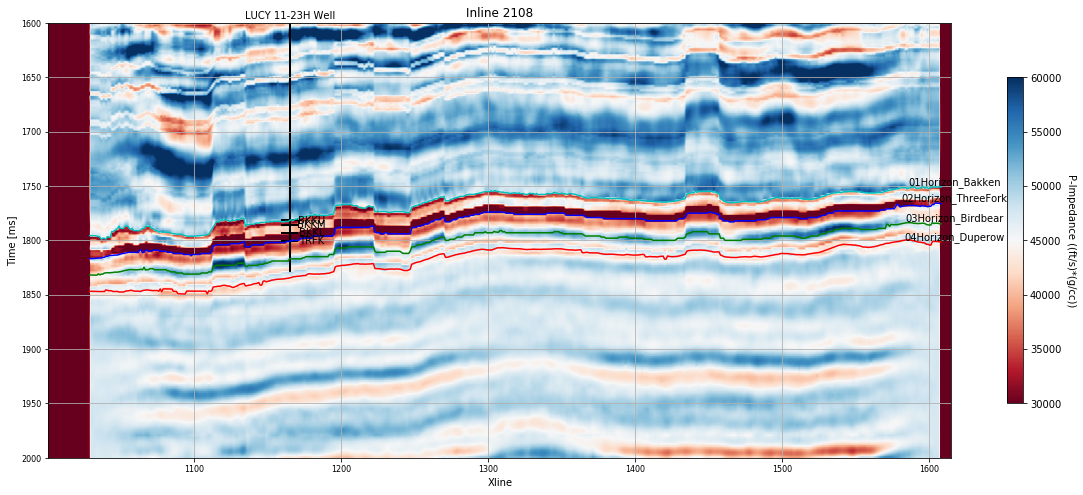

In [16]:
###################################################################################################################
filename = 'InvertedVol_EdgePreserving_3Samples_Model_20Iter_9Radius_FullVol_Zp_Resampled_1ms.sgy'
# filename = 'InvertedVol_EdgePreserving_3Samples_Model_20Iter_9Radius_FullVol_Zs_Resampled_1ms.sgy'
# filename = 'InvertedVol_EdgePreserving_3Samples_Model_20Iter_9Radius_FullVol_Dn_Resampled_1ms.sgy'
# filename = 'InvertedVol_EdgePreserving_3Samples_Model_20Iter_9Radius_FullVol_VpVs_Resampled_1ms.sgy'
###################################################################################################################
with segyio.open(filename, iline=189, xline=193) as segyfile:
    ###############################################################################################################
    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    print('Amplitude Inline range:    ' + str(np.amin(segyfile.ilines)) + ' - ' +str(np.amax(segyfile.ilines))) 
    print('Amplitude Crossline range: ' + str(np.amin(segyfile.xlines)) + ' - ' +str(np.amax(segyfile.xlines)))
    ###############################################################################################################
    # Get basic attributes
    n_traces = segyfile.tracecount
    sample_rate = segyio.tools.dt(segyfile) / 1000
    twt = segyfile.samples
    ##################################################
    twt_n_samples = segyfile.samples.size
    inl = segyfile.ilines
    xl = segyfile.xlines
    ###############################################################################################################
    seismic_data_raw = segyfile.trace.raw[:]    # Get all data into memory (could cause on big files)
    seismic_data = seismic_data_raw.T
    print("seismic_data_raw.shape: ", seismic_data_raw.shape)
    print("seis_data shape: (TWT_ms Samples, Inline * Xline): ", seismic_data.shape)
    seismic_data = seismic_data.reshape(twt_n_samples, inl.size, xl.size)
    print("seis_data shape: (TWT_ms Samples, Inline, Xline):  ", seismic_data.shape)
    ###############################################################################################################
    # Min and max ranges of inlines and xlines, and obtain the time axis data, which is 'z' here
    inl_min = np.amin(inl); inl_max = np.amax(inl)
    xl_min = np.amin(xl); xl_max = np.amax(xl)
    inl_array = np.arange(inl_min, inl_max + 1, 1)
    xl_array = np.arange(xl_min, xl_max + 1, 1)
    z = np.arange(0, twt_n_samples * sample_rate, sample_rate)
    ###############################################################################################################
    # Plot seismic data using the above function
    Lucy_Well_Inline = 2108; Lucy_Well_Xline = 1165; Apx_MidBakken_TimeSlice_Lucy = 190 # == 1790 ms
    Edwards_Well_Inline = 1824; Edwards_Well_Xline = 1073; Apx_MidBakken_TimeSlice_Edwards = 215 # == 1815 ms
    ###############################################################################################################
    if filename == 'InvertedVol_EdgePreserving_3Samples_Model_20Iter_9Radius_FullVol_Zp_Resampled_1ms.sgy':
        vmin = 30000; vmax = 60000
        cb_label = 'P-Impedance ((ft/s)*(g/cc))'
        plot3dseis(seismic_data, z, inl_array, xl_array, d1_sel=None, d2_sel=Lucy_Well_Inline, d3_sel=None, id1='Time [ms]', id2='Inline', id3='Xline', vmin=vmin, vmax=vmax, cb_label=cb_label)
    if filename == 'InvertedVol_EdgePreserving_3Samples_Model_20Iter_9Radius_FullVol_Zs_Resampled_1ms.sgy':
        vmin = 14000; vmax = 30000
        cb_label = 'S-Impedance ((ft/s)*(g/cc))'
        plot3dseis(seismic_data, z, inl_array, xl_array, d1_sel=Apx_MidBakken_TimeSlice_Lucy, d2_sel=None, d3_sel=None, id1='Time [ms]', id2='Inline', id3='Xline', vmin=vmin, vmax=vmax, cb_label=cb_label)
    if filename == 'InvertedVol_EdgePreserving_3Samples_Model_20Iter_9Radius_FullVol_Dn_Resampled_1ms.sgy':
        vmin = 2.48; vmax = 2.925
        cb_label = 'Density (g/cc)'
        plot3dseis(seismic_data, z, inl_array, xl_array, d1_sel=Apx_MidBakken_TimeSlice_Lucy, d2_sel=None, d3_sel=None, id1='Time [ms]', id2='Inline', id3='Xline', vmin=vmin, vmax=vmax, cb_label=cb_label)
    if filename == 'InvertedVol_EdgePreserving_3Samples_Model_20Iter_9Radius_FullVol_VpVs_Resampled_1ms.sgy':
        vmin = 1.4; vmax = 2.1
        cb_label = 'VpVs Ratio (Unitless)'
        plot3dseis(seismic_data, z, inl_array, xl_array, d1_sel=Apx_MidBakken_TimeSlice_Lucy, d2_sel=None, d3_sel=None, id1='Time [ms]', id2='Inline', id3='Xline', vmin=vmin, vmax=vmax, cb_label=cb_label)
    ###############################################################################################################
    # Load headers
    bin_headers = segyfile.bin
    ###############################################################################################################
f'N Traces: {n_traces}, TWT_N Samples: {twt_n_samples}, Sample rate: {sample_rate}ms'
###################################################################################################################

#### Get Zp values across a given horizon, specifically that of the Bakken and Three Forks horizons

In [17]:
###################################################################################################################
run_this = False
###################################################################################################################
z = np.array(np.arange(0, twt_n_samples * sample_rate, sample_rate)+1600, dtype=np.int64)
df_inl_array = df_bak_tf_horiz_rounded['Inline'].values
df_xl_array = df_bak_tf_horiz_rounded['Xline'].values
df_x_array = df_bak_tf_horiz_rounded['X'].values
df_y_array = df_bak_tf_horiz_rounded['Y'].values
df_bak_horiz_time_array = df_bak_tf_horiz_rounded['Bakken_Horizon_Floor_Time_ms'].values
df_tf_horiz_time_array = df_bak_tf_horiz_rounded['ThreeFork_Horizon_Ceiling_Time_ms'].values
np_bak_tf_horiz_rounded = df_bak_tf_horiz_rounded.values
###################################################################################################################
bak_tf_update_inline = []; bak_tf_update_xline = []; bak_tf_update_x = []; bak_tf_update_y = []
bak_update_time_update = []; tf_update_time_update = []; bak_update_zp = []; tf_update_zp = []
###################################################################################################################
if run_this == True:
    # if df_bak_tf_update is not None: df_bak_tf_update = df_bak_tf_update.iloc[0:0]
    ###############################################################################################################
    timer01 = time.time()
    with segyio.open(filename, iline=189, xline=193) as segyfile:
        ###########################################################################################################
        # Memory map file for faster reading (especially if file is big...)
        segyfile.mmap()
        ###########################################################################################################
        for index in range(0, len(np_bak_tf_horiz_rounded)):
            df_inl = df_inl_array[index]
            df_xl = df_xl_array[index]
            df_x = df_x_array[index]
            df_y = df_y_array[index]
            df_bak_horiz_time = df_bak_horiz_time_array[index]
            df_tf_horiz_time = df_tf_horiz_time_array[index]

            d1_bakken = z.tolist().index(df_bak_horiz_time); d1_threefork = z.tolist().index(df_tf_horiz_time)
            d2_inl = inl_array.tolist().index(df_inl); d3_xl = xl_array.tolist().index(df_xl)

            map_horiz_bak_horiz = seismic_data[d1_bakken, d2_inl, d3_xl]
            map_horiz_tf_horiz = seismic_data[d1_threefork, d2_inl, d3_xl]

            df_bak_horiz_time_update = df_bak_horiz_time[map_horiz_bak_horiz != 0]
            df_tf_horiz_time_update = df_tf_horiz_time[map_horiz_tf_horiz != 0]

            if len(df_bak_horiz_time_update) != 0:
                df_bak_horiz_time_update = df_bak_horiz_time_update[0]
            else:
                df_bak_horiz_time_update = 0

            if len(df_tf_horiz_time_update) != 0:
                df_tf_horiz_time_update = df_tf_horiz_time_update[0]
            else:
                df_tf_horiz_time_update = 0
            
            bak_tf_update_inline.append(df_inl)
            bak_tf_update_xline.append(df_xl)
            bak_tf_update_x.append(df_x)
            bak_tf_update_y.append(df_y)
            bak_update_time_update.append(df_bak_horiz_time_update)
            tf_update_time_update.append(df_tf_horiz_time_update)
            bak_update_zp.append(map_horiz_bak_horiz)
            tf_update_zp.append(map_horiz_tf_horiz)
            
            if index % 50000 == 0: print(str(index) + ', ', end=" ")
            # if index == 100000: break
        ###########################################################################################################
    timer02 = time.time()
    timetotal_min00 = (timer02 - timer01) / 60
    print('\n' + str(round(timetotal_min00, 5)) + '  minutes to evaluate for ' + str(index) + ' iterations')
    # 7.4879  minutes to evaluate for 785,354 iterations
    ###############################################################################################################
    np_inline = np.array(bak_tf_update_inline, dtype=np.int64)
    np_xline = np.array(bak_tf_update_xline, dtype=np.int64)
    np_x = np.array(bak_tf_update_x, dtype=np.float64)
    np_y = np.array(bak_tf_update_y, dtype=np.float64)
    np_bakken_horizon_floor_time_ms = np.array(bak_update_time_update, dtype=np.int64)
    np_three_fork_horizon_ceiling_time_ms = np.array(tf_update_time_update, dtype=np.int64)
    np_bakken_horizon_floor_amp = np.array(bak_update_zp, dtype=np.float64)
    np_three_fork_horizon_ceiling_amp = np.array(tf_update_zp, dtype=np.float64)
    ###############################################################################################################
    bak_tf_update_inline.clear()
    bak_tf_update_xline.clear()
    bak_tf_update_x.clear()
    bak_tf_update_y.clear()
    bak_update_time_update.clear()
    tf_update_time_update.clear()
    bak_update_zp.clear()
    tf_update_zp.clear()
    ###############################################################################################################
    frame_updated_horiz_amp_data = np.array([np_inline, np_xline, np_x, np_y, np_bakken_horizon_floor_time_ms, np_three_fork_horizon_ceiling_time_ms, np_bakken_horizon_floor_amp, np_three_fork_horizon_ceiling_amp]).transpose()
    columns_updated = ['Inline', 'Xline', 'X', 'Y', 'Bakken_Horizon_Floor_Time_ms', 'ThreeFork_Horizon_Ceiling_Time_ms', 'Bakken_Horizon_Floor_Zp', 'ThreeFork_Horizon_Ceiling_Zp']
    df_updated_horizon_amp_data = pd.DataFrame(frame_updated_horiz_amp_data, columns=columns_updated)
    ###############################################################################################################
    with pd.ExcelWriter("Rounded_Horizon_Data_with_Zp_Data_floor_Ceil_switch.xlsx") as writer:
        df_updated_horizon_amp_data.to_excel(writer, sheet_name='Horizon_Data_Cleaned')
    print("Successfully Written to Excel File")
###################################################################################################################
df_horizons_updated = pd.read_excel("Rounded_Horizon_Data_with_Zp_Data.xlsx", sheet_name='Horizon_Data_Cleaned')
# df_horizons_updated = pd.read_excel("Rounded_Horizon_Data_with_Zp_Data_floor_Ceil_switch.xlsx", sheet_name='Horizon_Data_Cleaned')
df_horizons_updated = df_horizons_updated.drop(columns=['Unnamed: 0'])
print("df_horizons_updated.shape:", df_horizons_updated.shape)
integer_location = np.where(df_horizons_updated.index == 1118)[0][0]
start = max(0, integer_location - 5)
end = max(1, integer_location + 5)
dfRange = df_horizons_updated.iloc[start:end]
dfRange.head(10)
###################################################################################################################

df_horizons_updated.shape: (785355, 8)


Inline  Xline            X            Y  Bakken_Horizon_Floor_Time_ms  \
1113    1002   1499  1502389.000  523454.4375                             0   
1114    1002   1500  1502471.500  523451.5625                             0   
1115    1002   1501  1502554.000  523448.6562                             0   
1116    1002   1502  1502636.375  523445.7812                          1904   
1117    1002   1503  1502718.875  523442.9062                          1904   
1118    1002   1504  1502801.250  523440.0312                          1904   
1119    1002   1505  1502883.750  523437.1562                          1904   
1120    1002   1506  1502966.250  523434.2500                          1904   
1121    1002   1507  1503048.625  523431.3750                          1904   
1122    1002   1508  1503131.125  523428.5000                          1904   

      ThreeFork_Horizon_Ceiling_Time_ms  Bakken_Horizon_Floor_Zp  \
1113                                  0                 0.000000   
1114                                  0                 0.000000   
1115                                  0                 0.000000   
1116                               1924             49169.371094   
1117                               1924             49211.125000   
1118                               1924             49282.230469   
1119                               1924             49373.726562   
1120                               1924             49012.863281   
1121                               1923             48308.886719   
1122                               1923             49648.152344   

      ThreeFork_Horizon_Ceiling_Zp  
1113                      0.000000  
1114                      0.000000  
1115                      0.000000  
1116                  41822.730469  
1117                  41974.449219  
1118                  42315.281250  
1119                  42822.980469  
1120                  49398.265625  
1121                  49153.339844  
1122                  48391.562500

#### Plot Bakken and Three Forks Horizons with apx Zp values, as well as the time difference between the two at each point

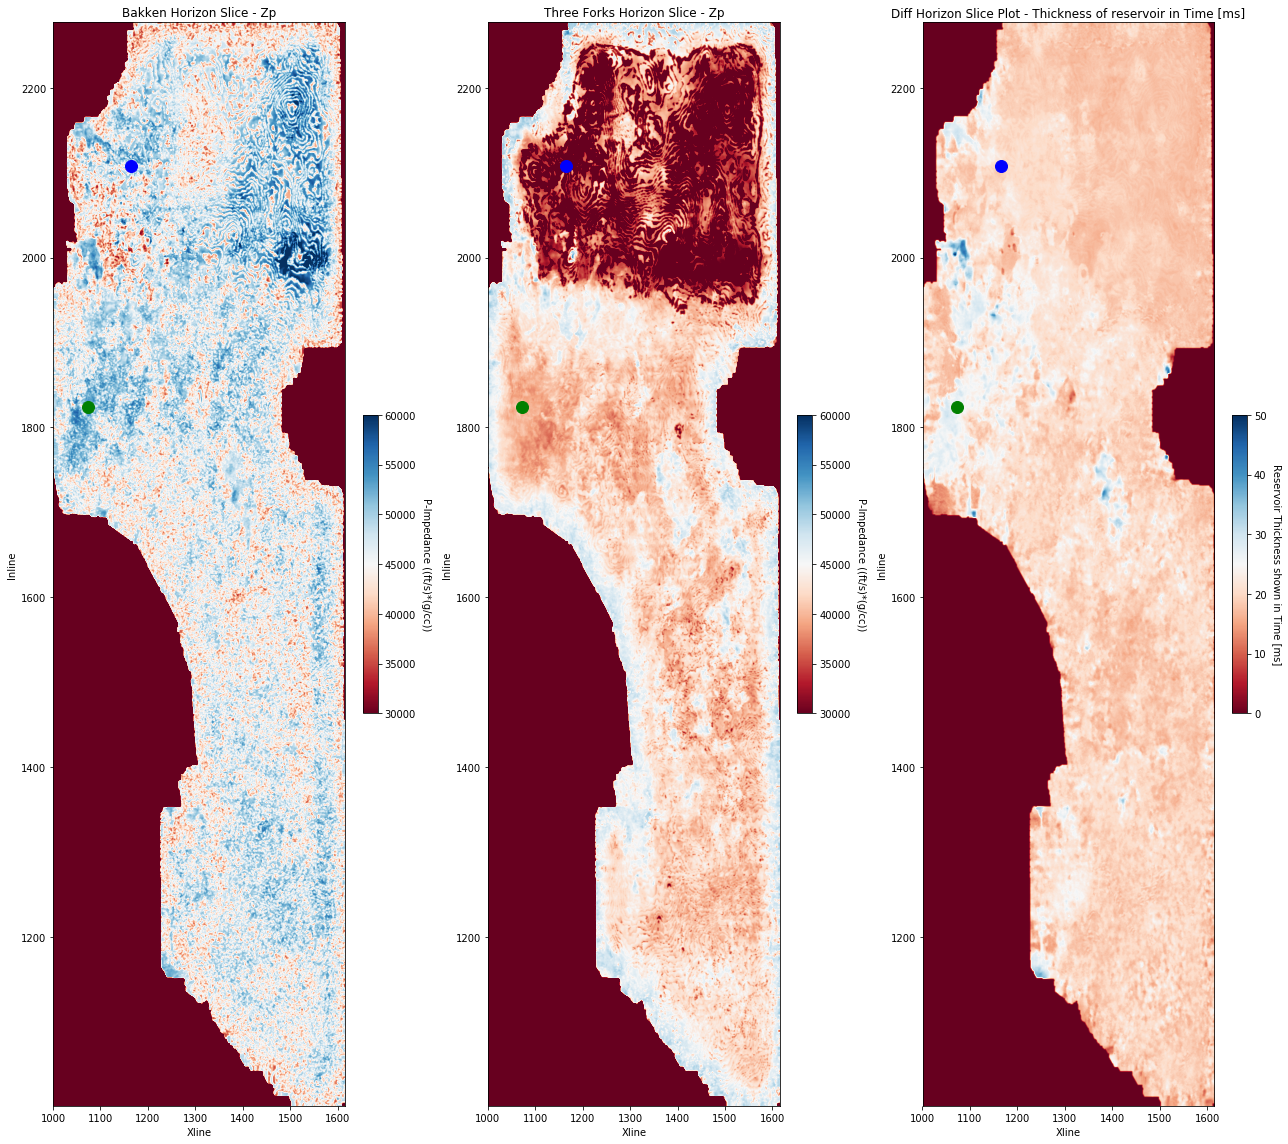

In [18]:
###################################################################################################################
df_horizons_Bakken_amp = df_horizons_updated['Bakken_Horizon_Floor_Zp'].values
df_horizons_Bakken3 = df_horizons_updated['Bakken_Horizon_Floor_Time_ms'].values
df_horizons_ThreeFork_amp = df_horizons_updated['ThreeFork_Horizon_Ceiling_Zp'].values
df_horizons_ThreeFork3 = df_horizons_updated['ThreeFork_Horizon_Ceiling_Time_ms'].values
###################################################################################################################
df_horizons_Bakken_amp = df_horizons_Bakken_amp.reshape(1277, 615)
df_horizons_Bakken3 = df_horizons_Bakken3.reshape(1277, 615)
df_horizons_ThreeFork_amp = df_horizons_ThreeFork_amp.reshape(1277, 615)
df_horizons_ThreeFork3 = df_horizons_ThreeFork3.reshape(1277, 615)
###################################################################################################################
with segyio.open(filename, iline=189, xline=193) as segyfile:
    ###############################################################################################################
    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    ###############################################################################################################
    xleft, xrite = inl_array.min(), inl_array.max()
    ytop, ybot = xl_array.min(), xl_array.max()
    ###############################################################################################################
    fig = plt.figure(figsize=(18, 16))
    ext = [ytop, ybot, xleft, xrite]
    # vmin = 1600; vmax = 2000
    vmin = 30000; vmax = 60000
    ###############################################################################################################
    ax = fig.add_subplot(1, 3, 1)
    amp = ax.imshow(df_horizons_Bakken_amp.T.T, cmap='RdBu', vmin=vmin, vmax=vmax, aspect='auto', extent=ext, origin='lower', interpolation='bicubic')
    lucy_inl = 2108; lucy_xl = 1165
    edwards_inl = 1824; edwards_xl = 1073
    ax.plot(lucy_xl, lucy_inl, 'bo', markersize=12)
    ax.plot(edwards_xl, edwards_inl, 'go', markersize=12)
    cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('P-Impedance ((ft/s)*(g/cc))', rotation=270)
    plt.title("Bakken Horizon Slice - Zp")
    plt.ylabel("Inline")
    plt.xlabel("Xline")
    ###############################################################################################################
    ax = fig.add_subplot(1, 3, 2)
    amp = ax.imshow(df_horizons_ThreeFork_amp.T.T, cmap='RdBu', vmin=vmin, vmax=vmax, aspect='auto', extent=ext, origin='lower', interpolation='bicubic')
    lucy_inl = 2108; lucy_xl = 1165
    edwards_inl = 1824; edwards_xl = 1073
    ax.plot(lucy_xl, lucy_inl, 'bo', markersize=12)
    ax.plot(edwards_xl, edwards_inl, 'go', markersize=12)
    cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('P-Impedance ((ft/s)*(g/cc))', rotation=270)
    plt.title("Three Forks Horizon Slice - Zp")
    plt.ylabel("Inline")
    plt.xlabel("Xline")
    ###############################################################################################################
    ax = fig.add_subplot(1, 3, 3)
    vmin = 0; vmax = 50
    diff_bakken_threeforks3 = df_horizons_ThreeFork3 - df_horizons_Bakken3
    amp = ax.imshow(diff_bakken_threeforks3.T.T, cmap='RdBu', vmin=vmin, vmax=vmax, aspect='auto', extent=ext, origin='lower', interpolation='bicubic')
    lucy_inl = 2108; lucy_xl = 1165
    edwards_inl = 1824; edwards_xl = 1073
    ax.plot(lucy_xl, lucy_inl, 'bo', markersize=12)
    ax.plot(edwards_xl, edwards_inl, 'go', markersize=12)
    cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Reservoir Thickness shown in Time [ms]', rotation=270)
    plt.title("Diff Horizon Slice Plot - Thickness of reservoir in Time [ms]")
    plt.ylabel("Inline")
    plt.xlabel("Xline")
    plt.tight_layout()
###################################################################################################################

#### Iteratively plot the seismic inverted P-Imepedance - Parameters

In [19]:
###################################################################################################################
vmin_plt = 30000; vmax_plt = 60000; run = True
###################################################################################################################
if run == True:
    # os.chdir("/home/u1/jrt3658/Thesis_BNN_Bakken_Code/Thesis_Bakken_BNN_Code_Results/")
    os.chdir("/Users/jacksontomski/Desktop/Desktop_Folders/xx_Thesis_New/")
    problemfolder_db_new = 'Inverted_zp'
    name_new_ts = 'time_slice'
    name_new_xl = 'xline'
    name_new_inl = 'inline'
    path_db_new_ts = (problemfolder_db_new + '_' + name_new_ts)
    path_db_new_xl = (problemfolder_db_new + '_' + name_new_xl)
    path_db_new_inl = (problemfolder_db_new + '_' + name_new_inl)
    # If the directory does not exist
    if not (os.path.exists(path_db_new_ts) or os.path.exists(path_db_new_xl) or os.path.exists(path_db_new_inl)):
        os.makedirs(path_db_new_ts)                             # Make the directory
        os.makedirs(path_db_new_xl)                             # Make the directory
        os.makedirs(path_db_new_inl)                            # Make the directory
    else:                                                       # Else, the directory exists
        shutil.rmtree(path_db_new_ts)
        shutil.rmtree(path_db_new_xl)
        shutil.rmtree(path_db_new_inl)
        os.makedirs(path_db_new_ts)
        os.makedirs(path_db_new_xl)
        os.makedirs(path_db_new_inl)
###################################################################################################################

#### Iteratively plot the seismic inverted P-Imepedance between the time of 1725ms and 2000ms

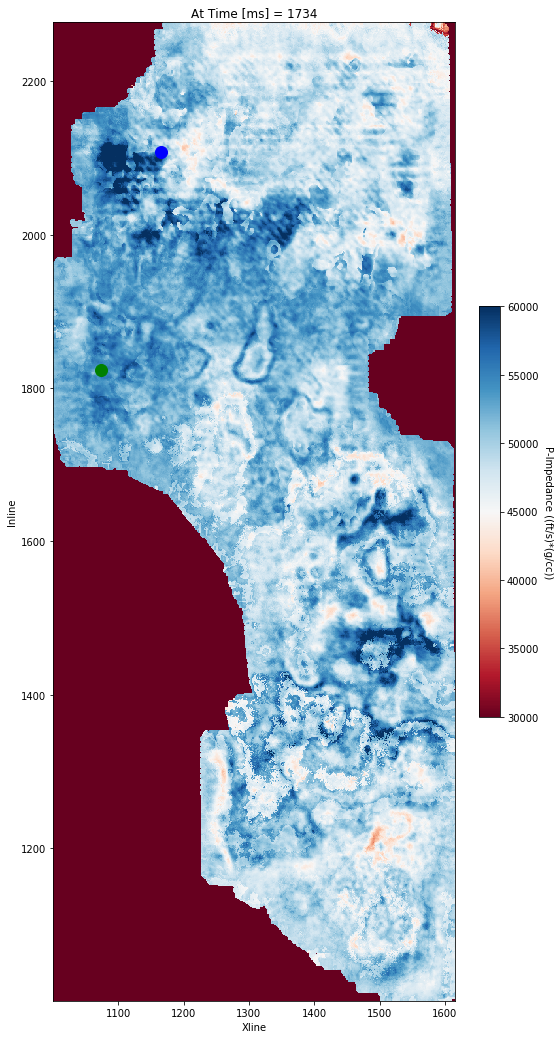

In [20]:
###################################################################################################################
# Index01: Time Slice Range:          1723 - 2000 (range of interest)
# Index02: Amplitude Inline range:    1001 - 2277
# Index03: Amplitude Crossline range: 1001 - 1615
###################################################################################################################
def plot_twt_iteratively(plot_bool, vmin, vmax, cb_label, path_db):
    if plot_bool == True:
        z = np.arange(0, twt_n_samples * sample_rate, sample_rate)+1600
        xleft, xrite = xl_array.min(), xl_array.max()
        ytop, ybot = inl_array.min(), inl_array.max()
        ext = [xleft, xrite, ytop, ybot]
        i = 1723
        while i <= 1734: # 1954
            fig = plt.figure(figsize=(8, 18))
            ax = fig.add_subplot(1, 1, 1)
            map_horiz_bak_time_slice = seismic_data[z.tolist().index(i), :, :]
            
            amp = ax.imshow(map_horiz_bak_time_slice, cmap='RdBu', vmin=vmin, vmax=vmax, aspect='auto', extent=ext, origin='lower')
            lucy_inl = 2108; lucy_xl = 1165
            edwards_inl = 1824; edwards_xl = 1073
            ax.plot(lucy_xl, lucy_inl, 'bo', markersize=12)
            ax.plot(edwards_xl, edwards_inl, 'go', markersize=12)
            
            cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel(cb_label, rotation=270)
            plt.title('At Time [ms] = %d' % i)
            plt.ylabel("Inline")
            plt.xlabel("Xline")
            plt.savefig(path_db + '/plot_twt_iteratively_at_time_ms_' + str(i) + '.png')
            plt.pause(0.00000000000001)
            clear_output(wait=True)
            i += 1
    plt.show()
###################################################################################################################
if run == True:
    plot_twt_iteratively(plot_bool=True, vmin=vmin_plt, vmax=vmax_plt, cb_label=cb_label, path_db=path_db_new_ts)
else:
    plot_twt_iteratively(plot_bool=True, vmin=vmin_plt, vmax=vmax_plt, cb_label=cb_label, path_db=path_db)
###################################################################################################################

#### Iteratively plot the seismic inverted P-Imepedance between xline of 1001 and 1615

(1277,)
(253,)


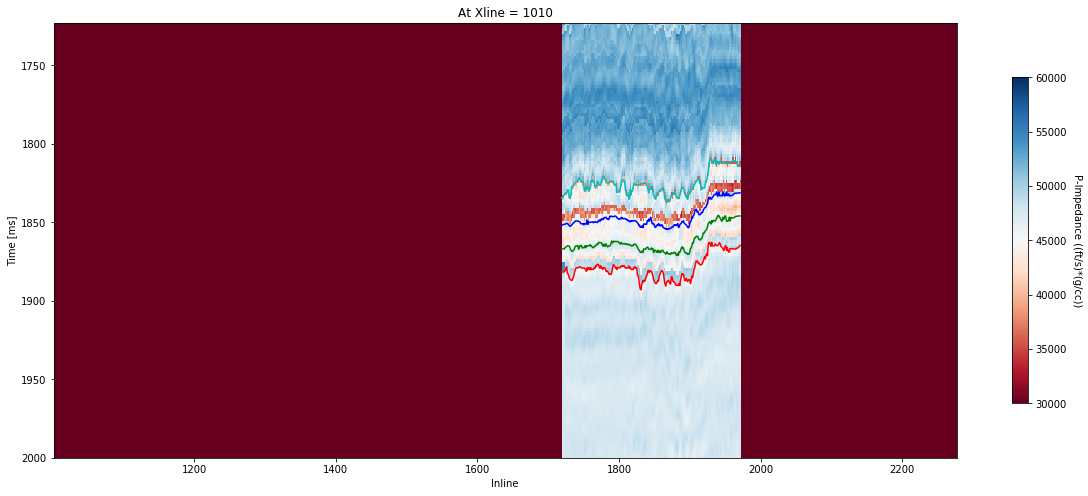

In [21]:
###################################################################################################################
# Index01: Time Slice Range:          1723 - 2000 (range of interest)
# Index02: Amplitude Inline range:    1001 - 2277
# Index03: Amplitude Crossline range: 1001 - 1615
###################################################################################################################
def plot_xline_iteratively(plot_bool, vmin, vmax, cb_label, path_db):
    if plot_bool == True:
        z = np.arange(0, twt_n_samples * sample_rate, sample_rate)+1600
        xleft, xrite = inl_array.min(), inl_array.max()
        twt_min = 1723; twt_max = 2000 # 1954
        ext = [xleft, xrite, twt_max, twt_min]

        i = 1001
        while i <= 1010: # 1615:
            fig = plt.figure(figsize=(18, 8))
            ax = fig.add_subplot(1, 1, 1)
            
            horzion_xline = df_horizons.loc[df_horizons['Xline'].values == i]
            bakk_horiz = horzion_xline['SmoothMean01_Bakken_Horizon'].values
            print(bakk_horiz.shape)
            three_fork_horiz = horzion_xline['SmoothMean02_ThreeFork_Horizon'].values
            birdbear_horiz = horzion_xline['SmoothMean03_Birdbear_Horizon'].values
            duperow_horiz = horzion_xline['SmoothMean04_Duperow_Horizon'].values

            map_horiz_bak_xline = seismic_data[:, :, xl_array.tolist().index(i)]        
            map_horiz_bak_xline = map_horiz_bak_xline[np.arange(126, 401, 1), :]
            bakk_horiz = bakk_horiz[map_horiz_bak_xline[0] != 0]
            print(bakk_horiz.shape)
            three_fork_horiz = three_fork_horiz[map_horiz_bak_xline[0] != 0]
            birdbear_horiz = birdbear_horiz[map_horiz_bak_xline[0] != 0]
            duperow_horiz = duperow_horiz[map_horiz_bak_xline[0] != 0]

            inl_array_new = inl_array
            inl_array_new = inl_array_new[map_horiz_bak_xline[0] != 0]
            
            amp = ax.imshow(map_horiz_bak_xline, cmap='RdBu', vmin=vmin, vmax=vmax, aspect='auto', extent=ext)

            cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel(cb_label, rotation=270)

            ax.plot(inl_array_new, bakk_horiz, color='c')
            ax.plot(inl_array_new, three_fork_horiz, color='b')
            ax.plot(inl_array_new, birdbear_horiz, color='g')
            ax.plot(inl_array_new, duperow_horiz, color='r')

            plt.title('At Xline = %d' % i)
            plt.ylabel("Time [ms]")
            plt.xlabel("Inline")
            plt.savefig(path_db + '/plot_iteratively_at_xline_' + str(i) + '.png')
            plt.pause(0.00000000000001)
            clear_output(wait=True)
            i += 1
    plt.show()
###################################################################################################################
if run == True:
    plot_xline_iteratively(plot_bool=True, vmin=vmin_plt, vmax=vmax_plt, cb_label=cb_label, path_db=path_db_new_xl)
else:
    plot_xline_iteratively(plot_bool=True, vmin=vmin_plt, vmax=vmax_plt, cb_label=cb_label, path_db=path_db)
###################################################################################################################

#### Iteratively plot the seismic inverted P-Imepedance between inline of 1001 and 2277

(615,)
(118,)


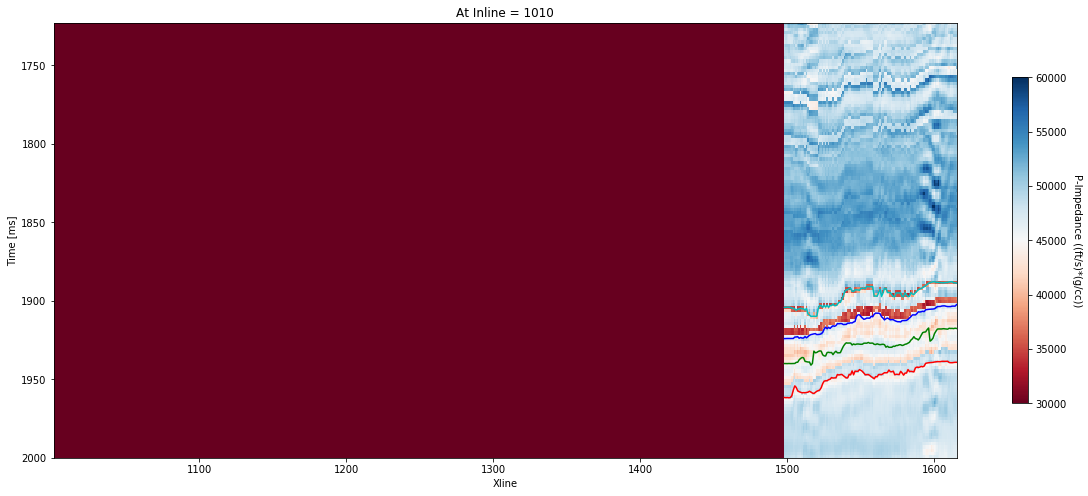

In [22]:
###################################################################################################################
# Index01: Time Slice Range:          1723 - 2000 (range of interest)
# Index02: Amplitude Inline range:    1001 - 2277
# Index03: Amplitude Crossline range: 1001 - 1615
###################################################################################################################
def plot_inline_iteratively(plot_bool, vmin, vmax, cb_label, path_db):
    if plot_bool == True:
        z = np.arange(0, twt_n_samples * sample_rate, sample_rate)+1600
        xleft, xrite = xl_array.min(), xl_array.max()
        twt_min = 1723; twt_max = 2000 # 1954
        ext = [xleft, xrite, twt_max, twt_min]

        i = 1001
        while i <= 1010: # 2277:
            fig = plt.figure(figsize=(18, 8))
            ax = fig.add_subplot(1, 1, 1)
            
            horzion_inline = df_horizons.loc[df_horizons['Inline'].values == i]
            bakk_horiz = horzion_inline['SmoothMean01_Bakken_Horizon'].values
            print(bakk_horiz.shape)
            three_fork_horiz = horzion_inline['SmoothMean02_ThreeFork_Horizon'].values
            birdbear_horiz = horzion_inline['SmoothMean03_Birdbear_Horizon'].values
            duperow_horiz = horzion_inline['SmoothMean04_Duperow_Horizon'].values

            map_horiz_bak_inline = seismic_data[:, inl_array.tolist().index(i), :]        
            map_horiz_bak_inline = map_horiz_bak_inline[np.arange(126, 401, 1), :]
            bakk_horiz = bakk_horiz[map_horiz_bak_inline[0] != 0]
            print(bakk_horiz.shape)
            three_fork_horiz = three_fork_horiz[map_horiz_bak_inline[0] != 0]
            birdbear_horiz = birdbear_horiz[map_horiz_bak_inline[0] != 0]
            duperow_horiz = duperow_horiz[map_horiz_bak_inline[0] != 0]

            xl_array_new = xl_array
            xl_array_new = xl_array_new[map_horiz_bak_inline[0] != 0]
            
            amp = ax.imshow(map_horiz_bak_inline, cmap='RdBu', vmin=vmin, vmax=vmax, aspect='auto', extent=ext)

            cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.055, shrink=0.75)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel(cb_label, rotation=270)

            ax.plot(xl_array_new, bakk_horiz, color='c')
            ax.plot(xl_array_new, three_fork_horiz, color='b')
            ax.plot(xl_array_new, birdbear_horiz, color='g')
            ax.plot(xl_array_new, duperow_horiz, color='r')

            plt.title('At Inline = %d' % i)
            plt.ylabel("Time [ms]")
            plt.xlabel("Xline")
            plt.savefig(path_db + '/plot_iteratively_at_inline_' + str(i) + '.png')
            plt.pause(0.00000000000001)
            clear_output(wait=True)
            i += 1
    plt.show()
###################################################################################################################
if run == True:
    plot_inline_iteratively(plot_bool=True, vmin=vmin_plt, vmax=vmax_plt, cb_label=cb_label, path_db=path_db_new_inl)
else:
    plot_inline_iteratively(plot_bool=True, vmin=vmin_plt, vmax=vmax_plt, cb_label=cb_label, path_db=path_db)
###################################################################################################################

### Part 2: Begin Cluster Analysis
#### Well vs. seismic crossplots --- At Lucy well

In [23]:
###################################################################################################################
df_horizons_updated_bak_test = df_horizons_updated['Bakken_Horizon_Floor_Time_ms']
df_horizons_updated_bak_test = df_horizons_updated_bak_test.replace(0, np.nan)
df_horizons_updated_bak_test = df_horizons_updated_bak_test.dropna(how='all', axis=0)
df_horizons_updated_bak_test = df_horizons_updated_bak_test.replace(np.nan, 0)
###################################################################################################################
df_horizons_updated_tf_test = df_horizons_updated['ThreeFork_Horizon_Ceiling_Time_ms']
df_horizons_updated_tf_test = df_horizons_updated_tf_test.replace(0, np.nan)
df_horizons_updated_tf_test = df_horizons_updated_tf_test.dropna(how='all', axis=0)
df_horizons_updated_tf_test = df_horizons_updated_tf_test.replace(np.nan, 0)
###################################################################################################################
print(min(df_horizons_updated_bak_test))
print(max(df_horizons_updated_tf_test))
###################################################################################################################
z_new = np.array(np.arange(1724.0, 1953.0 + 1.0, 1.0), dtype=np.int64)
z_new_inx = np.array(np.arange(1724.0-1600.0, (1953.0 + 1.0)-1600.0, 1.0), dtype=np.int64)
print(z_new.shape)
###################################################################################################################

1724.0
1953.0
(230,)


In [24]:
###################################################################################################################
''' BKKNU_lucy:  [1781.51] , BKKNM_lucy:  [1785.45] , BKKNL_lucy:  [1793.04] , TRFK_lucy:   [1800.38] '''
seismic_data_raw1 = pd.DataFrame(seismic_data_raw)
print(seismic_data_raw1.shape)
###################################################################################################################
seismic_data_raw1 = seismic_data_raw1.rename(columns={column_name: 'Zp_time_' + str(index+1600) for index, column_name in enumerate(seismic_data_raw1.columns)})
seismic_data_raw_test = seismic_data_raw1.drop(seismic_data_raw1.iloc[:, 0:123], axis=1)
seismic_data_raw_test1 = seismic_data_raw_test.drop(seismic_data_raw_test.iloc[:, 232:278], axis=1)
# seismic_data_raw_test1.head(pd.set_option('display.max_rows', 200))
print(seismic_data_raw_test1.shape)
###################################################################################################################
print("Bakken_Horizon_Floor_Time_ms.shape: ", df_horizons_updated['Bakken_Horizon_Floor_Time_ms'].shape)
inline_xl = df_horizons_updated.iloc[:, [0, 1]]
seismic_data_raw_inl_xl1 = pd.concat([inline_xl, seismic_data_raw1], axis=1)
seismic_data_raw_inl_xl = pd.concat([inline_xl, seismic_data_raw_test1], axis=1)
print("seismic_data_raw_inl_xl.shape:      ", seismic_data_raw_inl_xl.shape)
seismic_data_raw_inl_xl.tail(20)
###################################################################################################################

(785355, 401)
(785355, 232)
Bakken_Horizon_Floor_Time_ms.shape:  (785355,)
seismic_data_raw_inl_xl.shape:       (785355, 234)


Inline  Xline  Zp_time_1723  Zp_time_1724  Zp_time_1725  Zp_time_1726  \
785335    2277   1596  45556.015625  45556.015625  46617.355469  46617.355469   
785336    2277   1597  45082.847656  45082.847656  46002.902344  46002.902344   
785337    2277   1598  45809.832031  45809.832031  45817.914062  45817.914062   
785338    2277   1599  46158.601562  46158.601562  46035.464844  46035.464844   
785339    2277   1600      0.000000      0.000000      0.000000      0.000000   
785340    2277   1601      0.000000      0.000000      0.000000      0.000000   
785341    2277   1602      0.000000      0.000000      0.000000      0.000000   
785342    2277   1603      0.000000      0.000000      0.000000      0.000000   
785343    2277   1604      0.000000      0.000000      0.000000      0.000000   
785344    2277   1605      0.000000      0.000000      0.000000      0.000000   
785345    2277   1606      0.000000      0.000000      0.000000      0.000000   
785346    2277   1607      0.000000      0.000000      0.000000      0.000000   
785347    2277   1608      0.000000      0.000000      0.000000      0.000000   
785348    2277   1609      0.000000      0.000000      0.000000      0.000000   
785349    2277   1610      0.000000      0.000000      0.000000      0.000000   
785350    2277   1611      0.000000      0.000000      0.000000      0.000000   
785351    2277   1612      0.000000      0.000000      0.000000      0.000000   
785352    2277   1613      0.000000      0.000000      0.000000      0.000000   
785353    2277   1614      0.000000      0.000000      0.000000      0.000000   
785354    2277   1615      0.000000      0.000000      0.000000      0.000000   

        Zp_time_1727  Zp_time_1728  Zp_time_1729  Zp_time_1730  ...  \
785335  48084.812500  48084.812500  49361.488281  49361.488281  ...   
785336  47591.597656  47591.597656  49376.410156  49376.410156  ...   
785337  46112.226562  46112.226562  46723.597656  46723.597656  ...   
785338  46038.847656  46038.847656  46273.062500  46273.062500  ...   
785339      0.000000      0.000000      0.000000      0.000000  ...   
785340      0.000000      0.000000      0.000000      0.000000  ...   
785341      0.000000      0.000000      0.000000      0.000000  ...   
785342      0.000000      0.000000      0.000000      0.000000  ...   
785343      0.000000      0.000000      0.000000      0.000000  ...   
785344      0.000000      0.000000      0.000000      0.000000  ...   
785345      0.000000      0.000000      0.000000      0.000000  ...   
785346      0.000000      0.000000      0.000000      0.000000  ...   
785347      0.000000      0.000000      0.000000      0.000000  ...   
785348      0.000000      0.000000      0.000000      0.000000  ...   
785349      0.000000      0.000000      0.000000      0.000000  ...   
785350      0.000000      0.000000      0.000000      0.000000  ...   
785351      0.000000      0.000000      0.000000      0.000000  ...   
785352      0.000000      0.000000      0.000000      0.000000  ...   
785353      0.000000      0.000000      0.000000      0.000000  ...   
785354      0.000000      0.000000      0.000000      0.000000  ...   

        Zp_time_1945  Zp_time_1946  Zp_time_1947  Zp_time_1948  Zp_time_1949  \
785335  47593.277344  47593.277344  47593.414062  47593.414062  47594.046875   
785336  47592.730469  47592.730469  47592.687500  47592.687500  47593.320312   
785337  47593.820312  47593.820312  47593.777344  47593.777344  47594.140625   
785338  47593.867188  47593.867188  47593.820312  47593.820312  47594.183594   
785339      0.000000      0.000000      0.000000      0.000000      0.000000   
785340      0.000000      0.000000      0.000000      0.000000      0.000000   
785341      0.000000      0.000000      0.000000      0.000000      0.000000   
785342      0.000000      0.000000      0.000000      0.000000      0.000000   
785343      0.000000      0.000000      0.000000      0.000000      0.000000   
785344      0.

In [25]:
###################################################################################################################
seismic_inline_lucy = seismic_data_raw_inl_xl.loc[seismic_data_raw_inl_xl1['Inline'] == 2108]
seismic_inline_xline_lucy = seismic_inline_lucy.loc[seismic_inline_lucy['Xline'] == 1165]
print(seismic_inline_xline_lucy.iloc[:, 60].name)
print(seismic_inline_xline_lucy.iloc[:, 80].name)
seismic_inline_xline_lucy_sub = seismic_inline_xline_lucy.iloc[:, 60:81].T
print(seismic_inline_xline_lucy_sub.shape)
###################################################################################################################
np_seismic_zp_lucy_time = np.arange(1781, 1802, 1)
np_seismic_inline_xline_lucy_sub = np.array(seismic_inline_xline_lucy_sub).transpose()
np_seismic_inline_xline_lucy_sub = np_seismic_inline_xline_lucy_sub[0]
np_seismic_zp_lucy = np.array([np_seismic_zp_lucy_time, np_seismic_inline_xline_lucy_sub]).transpose()
df_seismic_zp_lucy = pd.DataFrame(np_seismic_zp_lucy, columns=['Time_ms', 'Zp'])
df_seismic_zp_lucy
###################################################################################################################

Zp_time_1781
Zp_time_1801
(21, 1)


Time_ms            Zp
0    1781.0  46576.074219
1    1782.0  46576.074219
2    1783.0  30375.136719
3    1784.0  30375.136719
4    1785.0  37679.804688
5    1786.0  37679.804688
6    1787.0  41105.003906
7    1788.0  41105.003906
8    1789.0  40598.964844
9    1790.0  40598.964844
10   1791.0  41262.027344
11   1792.0  41262.027344
12   1793.0  40822.597656
13   1794.0  40822.597656
14   1795.0  23468.054688
15   1796.0  23468.054688
16   1797.0  23543.015625
17   1798.0  23543.015625
18   1799.0  22536.960938
19   1800.0  22536.960938
20   1801.0  39793.820312

In [26]:
###################################################################################################################
df_well_lucy_seismic_subset = df_well_lucy_seismic[(df_well_lucy_seismic['Time_ms'] >= 1781) & (df_well_lucy_seismic['Time_ms'] <= 1801)]
df_well_lucy_seismic_subset = df_well_lucy_seismic_subset.reset_index(drop=True)
###################################################################################################################
print(df_well_lucy_seismic_subset.shape)
df_well_lucy_seismic_subset
###################################################################################################################

(21, 13)


Time_ms           X          Y    P_Velo  P_Imped_Trans  DPOR_Low_Res  \
0      1781  1478020.46  615647.36   54.1737     49763.6797        0.0072   
1      1782  1478020.46  615647.36   73.0941     35886.9297        0.1195   
2      1783  1478020.46  615647.36  116.6198     18008.0859        0.3677   
3      1784  1478020.46  615647.36  107.6707     19822.5000        0.3391   
4      1785  1478020.46  615647.36  108.1936     19757.8535        0.3401   
5      1786  1478020.46  615647.36   71.9660     37244.7578        0.1292   
6      1787  1478020.46  615647.36   65.8795     40024.1523        0.0472   
7      1788  1478020.46  615647.36   64.2033     41136.6250        0.0398   
8      1789  1478020.46  615647.36   63.2873     41417.9883        0.0529   
9      1790  1478020.46  615647.36   60.6576     43489.7656        0.0539   
10     1791  1478020.46  615647.36   61.4322     42693.0977        0.0465   
11     1792  1478020.46  615647.36   61.0964     42960.4141        0.0501   
12     1793  1478020.46  615647.36   60.7326     43397.9531        0.0403   
13     1794  1478020.46  615647.36   98.5837     24356.4082        0.2597   
14     1795  1478020.46  615647.36  112.4749     19066.9434        0.3299   
15     1796  1478020.46  615647.36  103.2937     21550.2793        0.2860   
16     1797  1478020.46  615647.36  104.7553     21317.2812        0.2803   
17     1798  1478020.46  615647.36  102.2146     21818.4102        0.2834   
18     1799  1478020.46  615647.36  101.7875     21815.1113        0.2821   
19     1800  1478020.46  615647.36  105.0937     21475.9629        0.2801   
20     1801  1478020.46  615647.36   77.2882     34127.5625        0.0631   

    DPOR_High_Res  NPHI_Low_Res  NPHI_High_Res  TPHI_Low_Res  TPHI_High_Res  \
0          0.0058        0.0252         0.0301      0.018532       0.021675   
1          0.1233        0.1660         0.1901      0.144631       0.160220   
2          0.3706        0.4699         0.4759      0.421906       0.426512   
3          0.3388        0.3812         0.3774      0.360765       0.358620   
4          0.3363        0.3796         0.3636      0.360392       0.350216   
5          0.1260        0.2180         0.2230      0.179188       0.181115   
6          0.0472        0.1237         0.1149      0.093620       0.087835   
7          0.0380        0.1261         0.1155      0.093502       0.085977   
8          0.0488        0.1012         0.0969      0.080746       0.076717   
9          0.0537        0.0760         0.0732      0.065883       0.064195   
10         0.0455        0.0782         0.0749      0.064333       0.061969   
11         0.0483        0.0736         0.0712      0.062956       0.060837   
12         0.0368        0.0756         0.0733      0.060578       0.057996   
13         0.2626        0.3571         0.3550      0.312221       0.312237   
14         0.3355        0.4515         0.4541      0.395402       0.399229   
15         0.2726        0.3431         0.3370      0.315843       0.306496   
16         0.2799        0.3414         0.3291      0.312348       0.305492   
17         0.2826        0.3308         0.3202      0.308013       0.301986   
18         0.2786        0.3380         0.3224      0.311307       0.301297   
19         0.2778        0.3767         0.3809      0.331933       0.333360   
20         0.0602        0.1962         0.1757      0.145733       0.131329   

      RHOZ        TOC  
0   2.6953   0.059892  
1   2.4162   6.681141  
2   2.0940  16.519802  
3   2.1316  15.218358  
4   2.1354  15.089379  
5   2.5370   3.636517  
6   2.6301   1.480873  
7   2.6400   1.260591  
8   2.6154   1.811035  
9   2.6277   1.534525  
10  2.6227   1.646614  
11  2.6246   1.603970  
12  2.6353   1.364963  
13  2.2551  11.249044  
14  2.1414  14.886660  
15  2.2226  12.250833  
16  2.2315  11.973596  
17  2.2300  12.020166  
18  2.2204  12.319706  
19  2.2316  11.970493  
20  2.6236   1.626407

In [27]:
###################################################################################################################
df_well_lucy_subset = df_well_lucy[(df_well_lucy['TWT_ms'] >= 1781.5) & (df_well_lucy['TWT_ms'] <= 1800.5)]
df_well_lucy_subset = df_well_lucy_subset.drop(columns=['MD_KB_ft'])
df_well_lucy_subset = df_well_lucy_subset.reset_index(drop=True)
###################################################################################################################
print(df_well_lucy_subset.shape)
df_well_lucy_subset.head()
###################################################################################################################

(183, 13)


TWT_ms           X          Y   P_Velo  Computed_P_Impedance  \
0  1781.51  1478020.46  615647.36  71.0911            35073.4492   
1  1781.63  1478020.46  615647.36  95.0941            24523.2891   
2  1781.73  1478020.46  615647.36  76.3843            28706.8145   
3  1781.84  1478020.46  615647.36  81.9938            25919.6465   
4  1781.96  1478020.46  615647.36  88.6805            23709.6113   

   DPOR_Low_Res  DPOR_High_Res  NPHI_Low_Res  NPHI_High_Res  TPHI_Low_Res  \
0        0.0261        -0.0255        0.0371         0.0172      0.032075   
1        0.0889         0.0978        0.1204         0.0772      0.105829   
2        0.1866         0.2533        0.2488         0.2764      0.219910   
3        0.2753         0.2988        0.3885         0.5732      0.336692   
4        0.3317         0.3354        0.4508         0.5087      0.395756   

   TPHI_High_Res    RHOZ        TOC  
0       0.021750  2.4934   4.701381  
1       0.088104  2.3320   8.989858  
2       0.265102  2.1927  13.198707  
3       0.457077  2.1253  15.433208  
4       0.430853  2.1026  16.218026

In [28]:
###################################################################################################################
np_seismic_zp_lucy_Time_ms = df_seismic_zp_lucy['Time_ms'].values
np_well_lucy_seismic_subset_x = df_well_lucy_seismic_subset['X'].values
np_well_lucy_seismic_subset_y = df_well_lucy_seismic_subset['Y'].values
np_well_lucy_seismic_subset_P_Velo = df_well_lucy_seismic_subset['P_Velo'].values
np_seismic_zp_lucy_zp = df_seismic_zp_lucy['Zp'].values
np_well_lucy_seismic_subset_DPOR_Low_Res = df_well_lucy_seismic_subset['DPOR_Low_Res'].values
np_well_lucy_seismic_subset_DPOR_High_Res = df_well_lucy_seismic_subset['DPOR_High_Res'].values
np_well_lucy_seismic_subset_NPHI_Low_Res = df_well_lucy_seismic_subset['NPHI_Low_Res'].values
np_well_lucy_seismic_subset_NPHI_High_Res = df_well_lucy_seismic_subset['NPHI_High_Res'].values
np_well_lucy_seismic_subset_TPHI_Low_Res = df_well_lucy_seismic_subset['TPHI_Low_Res'].values
np_well_lucy_seismic_subset_TPHI_High_Res = df_well_lucy_seismic_subset['TPHI_High_Res'].values
np_seismic_zp_lucy_rhoz = df_well_lucy_seismic_subset['RHOZ'].values
np_seismic_zp_lucy_toc = df_well_lucy_seismic_subset['TOC'].values
###################################################################################################################
np_lucy_all_new = np.vstack([np_seismic_zp_lucy_Time_ms, np_well_lucy_seismic_subset_x, np_well_lucy_seismic_subset_y, np_well_lucy_seismic_subset_P_Velo, np_seismic_zp_lucy_zp, np_well_lucy_seismic_subset_DPOR_Low_Res, np_well_lucy_seismic_subset_DPOR_High_Res, np_well_lucy_seismic_subset_NPHI_Low_Res, np_well_lucy_seismic_subset_NPHI_High_Res, np_well_lucy_seismic_subset_TPHI_Low_Res, np_well_lucy_seismic_subset_TPHI_High_Res, np_seismic_zp_lucy_rhoz, np_seismic_zp_lucy_toc])
np_lucy_all_new = np_lucy_all_new.transpose()
df_lucy_all_new = pd.DataFrame(np_lucy_all_new, columns=['Time_ms', 'X', 'Y', 'P_Velo_from_Well', 'Zp_from_Seismic', 'DPOR_Low_Res_from_Well', 'DPOR_High_Res_from_Well', 'NPHI_Low_Res_from_Well', 'NPHI_High_Res_from_Well', 'TPHI_Low_Res_from_Well', 'TPHI_High_Res_from_Well', 'RHOZ', 'TOC'])
###################################################################################################################
print(df_lucy_all_new.shape)
df_lucy_all_new.head()
###################################################################################################################

(21, 13)


Time_ms           X          Y  P_Velo_from_Well  Zp_from_Seismic  \
0   1781.0  1478020.46  615647.36           54.1737     46576.074219   
1   1782.0  1478020.46  615647.36           73.0941     46576.074219   
2   1783.0  1478020.46  615647.36          116.6198     30375.136719   
3   1784.0  1478020.46  615647.36          107.6707     30375.136719   
4   1785.0  1478020.46  615647.36          108.1936     37679.804688   

   DPOR_Low_Res_from_Well  DPOR_High_Res_from_Well  NPHI_Low_Res_from_Well  \
0                  0.0072                   0.0058                  0.0252   
1                  0.1195                   0.1233                  0.1660   
2                  0.3677                   0.3706                  0.4699   
3                  0.3391                   0.3388                  0.3812   
4                  0.3401                   0.3363                  0.3796   

   NPHI_High_Res_from_Well  TPHI_Low_Res_from_Well  TPHI_High_Res_from_Well  \
0                   0.0301                0.018532                 0.021675   
1                   0.1901                0.144631                 0.160220   
2                   0.4759                0.421906                 0.426512   
3                   0.3774                0.360765                 0.358620   
4                   0.3636                0.360392                 0.350216   

     RHOZ        TOC  
0  2.6953   0.059892  
1  2.4162   6.681141  
2  2.0940  16.519802  
3  2.1316  15.218358  
4  2.1354  15.089379

In [29]:
###################################################################################################################
np_well_lucy_seismic_subset_new = df_lucy_all_new.values
np_well_lucy_subset_new = df_well_lucy_subset.values
np_lucy_all = np.vstack([np_well_lucy_seismic_subset_new, np_well_lucy_subset_new])
###################################################################################################################
df_lucy_all = pd.DataFrame(np_lucy_all, columns=['Time_ms', 'X', 'Y', 'P_Velo', 'Zp', 'DPOR_Low_Res', 'DPOR_High_Res', 'NPHI_Low_Res', 'NPHI_High_Res', 'TPHI_Low_Res', 'TPHI_High_Res', 'RHOZ', 'TOC'])
df_lucy_all = df_lucy_all.sort_values('Time_ms', ascending=True)
df_lucy_all = df_lucy_all.reset_index(drop=True)
###################################################################################################################
print(df_lucy_all.shape)
df_lucy_all.head()
###################################################################################################################

(204, 13)


Time_ms           X          Y   P_Velo            Zp  DPOR_Low_Res  \
0  1781.00  1478020.46  615647.36  54.1737  46576.074219        0.0072   
1  1781.51  1478020.46  615647.36  71.0911  35073.449200        0.0261   
2  1781.63  1478020.46  615647.36  95.0941  24523.289100        0.0889   
3  1781.73  1478020.46  615647.36  76.3843  28706.814500        0.1866   
4  1781.84  1478020.46  615647.36  81.9938  25919.646500        0.2753   

   DPOR_High_Res  NPHI_Low_Res  NPHI_High_Res  TPHI_Low_Res  TPHI_High_Res  \
0         0.0058        0.0252         0.0301      0.018532       0.021675   
1        -0.0255        0.0371         0.0172      0.032075       0.021750   
2         0.0978        0.1204         0.0772      0.105829       0.088104   
3         0.2533        0.2488         0.2764      0.219910       0.265102   
4         0.2988        0.3885         0.5732      0.336692       0.457077   

     RHOZ        TOC  
0  2.6953   0.059892  
1  2.4934   4.701381  
2  2.3320   8.989858  
3  2.1927  13.198707  
4  2.1253  15.433208

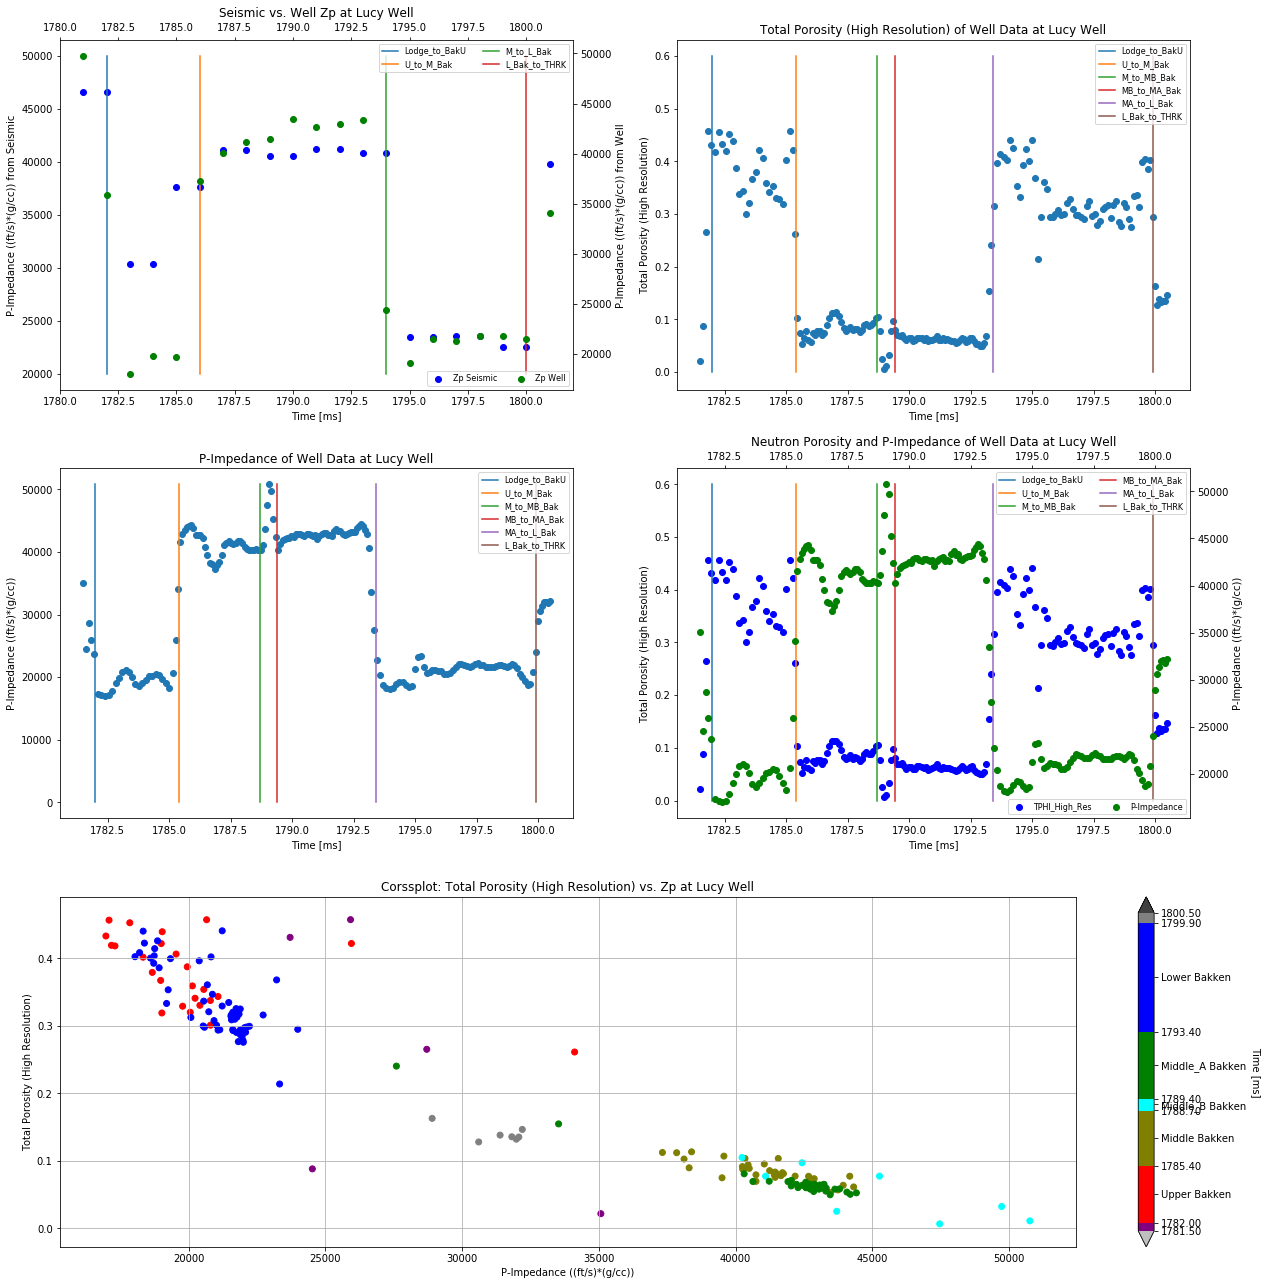

In [30]:
###################################################################################################################
fig = plt.figure(figsize=(18, 18))
###################################################################################################################
Lodge_to_BakU = 1782
U_to_M_Bak = 1785.4
M_to_MB_Bak = 1788.7
MB_to_MA_Bak = 1789.4
MA_to_L_Bak = 1793.4
L_Bak_to_THRK = 1799.9
###################################################################################################################
ax01 = fig.add_subplot(3, 2, 1, label="1")
seismic_zp_plot = ax01.scatter(df_seismic_zp_lucy['Time_ms'].values, df_seismic_zp_lucy['Zp'].values, c='b')
ax01.plot([1782, 1782], [50000, 20000], label='Lodge_to_BakU')    # 1782 ms
ax01.plot([1786, 1786], [50000, 20000], label='U_to_M_Bak')       # 1786 ms
ax01.plot([1794, 1794], [50000, 20000], label='M_to_L_Bak')       # 1794 ms
ax01.plot([1800, 1800], [50000, 20000], label='L_Bak_to_THRK')    # 1800 ms
ax01.yaxis.tick_left()
ax01.set_ylabel("P-Impedance ((ft/s)*(g/cc)) from Seismic")
ax01.yaxis.set_label_position('left') 
ax01.xaxis.tick_bottom()
ax01.set_xlabel("Time [ms]")
plt.legend(loc='upper right', ncol=2, fontsize=8)
###################################################################################################################
ax001 = fig.add_subplot(3, 2, 1, label="2",frame_on=False)
well_zp_plot = ax001.scatter(df_well_lucy_seismic_subset['Time_ms'].values, df_well_lucy_seismic_subset['P_Imped_Trans'].values, c='g')
ax001.yaxis.tick_right()
ax001.set_ylabel("P-Impedance ((ft/s)*(g/cc)) from Well")
ax001.yaxis.set_label_position('right') 
ax001.xaxis.tick_top()
ax001.set_title("Seismic vs. Well Zp at Lucy Well")
plt.legend((seismic_zp_plot, well_zp_plot), ('Zp Seismic', 'Zp Well'), loc='lower right', ncol=2, fontsize=8)
###################################################################################################################
ax02 = fig.add_subplot(3, 2, 2)
ax02.scatter(df_well_lucy_subset['TWT_ms'].values, df_well_lucy_subset['TPHI_High_Res'].values)
ax02.plot([Lodge_to_BakU, Lodge_to_BakU], [0.6, 0], label='Lodge_to_BakU')      # 1782 ms
ax02.plot([U_to_M_Bak, U_to_M_Bak], [0.6, 0], label='U_to_M_Bak')               # 1786 ms
ax02.plot([M_to_MB_Bak, M_to_MB_Bak], [0.6, 0], label='M_to_MB_Bak')            # apx 1789 ms
ax02.plot([MB_to_MA_Bak, MB_to_MA_Bak], [0.6, 0], label='MB_to_MA_Bak')         # apx 1790 ms
ax02.plot([MA_to_L_Bak, MA_to_L_Bak], [0.6, 0], label='MA_to_L_Bak')            # 1794 ms
ax02.plot([L_Bak_to_THRK, L_Bak_to_THRK], [0.6, 0], label='L_Bak_to_THRK')      # 1800 ms
ax02.set_ylabel("Total Porosity (High Resolution)")
ax02.set_xlabel("Time [ms]")
ax02.set_title("Total Porosity (High Resolution) of Well Data at Lucy Well")
plt.legend(loc='upper right', ncol=1, fontsize=8)
###################################################################################################################
ax03 = fig.add_subplot(3, 2, 3)
ax03.scatter(df_well_lucy_subset['TWT_ms'].values, df_well_lucy_subset['Computed_P_Impedance'].values)
ax03.plot([Lodge_to_BakU, Lodge_to_BakU], [50800, 0], label='Lodge_to_BakU')    # 1782 ms
ax03.plot([U_to_M_Bak, U_to_M_Bak], [50800, 0], label='U_to_M_Bak')             # 1786 ms
ax03.plot([M_to_MB_Bak, M_to_MB_Bak], [50800, 0], label='M_to_MB_Bak')          # apx 1789 ms
ax03.plot([MB_to_MA_Bak, MB_to_MA_Bak], [50800, 0], label='MB_to_MA_Bak')       # apx 1790 ms
ax03.plot([MA_to_L_Bak, MA_to_L_Bak], [50800, 0], label='MA_to_L_Bak')          # 1794 ms
ax03.plot([L_Bak_to_THRK, L_Bak_to_THRK], [50800, 0], label='L_Bak_to_THRK')    # 1800 ms
ax03.set_ylabel("P-Impedance ((ft/s)*(g/cc))")
ax03.set_xlabel("Time [ms]")
ax03.set_title("P-Impedance of Well Data at Lucy Well")
plt.legend(loc='upper right', ncol=1, fontsize=8)
###################################################################################################################
ax002 = fig.add_subplot(3, 2, 4, label="1")
nphi_plot = ax002.scatter(df_well_lucy_subset['TWT_ms'].values, df_well_lucy_subset['TPHI_High_Res'].values, c='b')
ax002.plot([Lodge_to_BakU, Lodge_to_BakU], [0.6, 0], label='Lodge_to_BakU')      # 1782 ms
ax002.plot([U_to_M_Bak, U_to_M_Bak], [0.6, 0], label='U_to_M_Bak')               # 1786 ms
ax002.plot([M_to_MB_Bak, M_to_MB_Bak], [0.6, 0], label='M_to_MB_Bak')            # apx 1789 ms
ax002.plot([MB_to_MA_Bak, MB_to_MA_Bak], [0.6, 0], label='MB_to_MA_Bak')         # apx 1790 ms
ax002.plot([MA_to_L_Bak, MA_to_L_Bak], [0.6, 0], label='MA_to_L_Bak')            # 1794 ms
ax002.plot([L_Bak_to_THRK, L_Bak_to_THRK], [0.6, 0], label='L_Bak_to_THRK')      # 1800 ms
ax002.yaxis.tick_left()
ax002.set_ylabel("Total Porosity (High Resolution)")
ax002.yaxis.set_label_position('left') 
ax002.xaxis.tick_bottom()
ax002.set_xlabel("Time [ms]")
plt.legend(loc='upper right', ncol=2, fontsize=8)
###################################################################################################################
ax003 = fig.add_subplot(3, 2, 4, label="2",frame_on=False)
zp_plot = ax003.scatter(df_well_lucy_subset['TWT_ms'].values, df_well_lucy_subset['Computed_P_Impedance'].values, c='g')
ax003.yaxis.tick_right()
ax003.set_ylabel("P-Impedance ((ft/s)*(g/cc))")
ax003.yaxis.set_label_position('right') 
ax003.xaxis.tick_top()
ax003.set_title("Neutron Porosity and P-Impedance of Well Data at Lucy Well")
plt.legend((nphi_plot, zp_plot), ('TPHI_High_Res', 'P-Impedance'), loc='lower right', ncol=2, fontsize=8)
###################################################################################################################
gs00 = gridspec.GridSpec(3, 2)
ax = fig.add_subplot(gs00[2, :])

cmap = mpl.colors.ListedColormap(['purple', 'red', 'olive', 'cyan', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1781.5, Lodge_to_BakU, U_to_M_Bak, M_to_MB_Bak, MB_to_MA_Bak, MA_to_L_Bak, L_Bak_to_THRK, 1800.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cc = ax.scatter(df_well_lucy_subset['Computed_P_Impedance'], df_well_lucy_subset['TPHI_High_Res'], c=df_well_lucy_subset['TWT_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1781.5, Lodge_to_BakU, (Lodge_to_BakU+U_to_M_Bak)/2, U_to_M_Bak, (U_to_M_Bak+M_to_MB_Bak)/2, M_to_MB_Bak, (M_to_MB_Bak+MB_to_MA_Bak)/2, MB_to_MA_Bak, (MB_to_MA_Bak+MA_to_L_Bak)/2, MA_to_L_Bak, (MA_to_L_Bak+L_Bak_to_THRK)/2, L_Bak_to_THRK, 1800.5]
label_cbar = ["1781.50", "1782.00", "Upper Bakken", "1785.40", "Middle Bakken", "1788.70", "Middle_B Bakken", "1789.40", "Middle_A Bakken", "1793.40", "Lower Bakken", "1799.90", "1800.50"]
cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("P-Impedance ((ft/s)*(g/cc))")
ax.set_ylabel("Total Porosity (High Resolution)")
ax.set_title("Corssplot: Total Porosity (High Resolution) vs. Zp at Lucy Well")
ax.grid()
###################################################################################################################
plt.tight_layout()
plt.show()
###################################################################################################################

#### Well vs. seismic crossplots --- At Edwards well

In [31]:
###################################################################################################################
''' BKKNU_edwards:  [1804.27] , BKKNM_edwards:  [1807.27] , BKKNL_edwards:  [1822.27] , TRFK_edwards:   [1830.1] '''
seismic_inline_edwards = seismic_data_raw_inl_xl.loc[seismic_data_raw_inl_xl['Inline'] == 1824]
seismic_inline_xline_edwards = seismic_inline_edwards.loc[seismic_inline_edwards['Xline'] == 1073]
print(seismic_inline_xline_edwards.iloc[:, 83].name)
print(seismic_inline_xline_edwards.iloc[:, 110].name)
seismic_inline_xline_edwards_sub = seismic_inline_xline_edwards.iloc[:, 83:111].T
print(seismic_inline_xline_edwards_sub.shape)
###################################################################################################################
np_seismic_zp_edwards_time = np.arange(1804, 1832, 1)
np_seismic_inline_xline_edwards_sub = np.array(seismic_inline_xline_edwards_sub).transpose()
np_seismic_inline_xline_edwards_sub = np_seismic_inline_xline_edwards_sub[0]
np_seismic_zp_edwards = np.array([np_seismic_zp_edwards_time, np_seismic_inline_xline_edwards_sub]).transpose()
df_seismic_zp_edwards = pd.DataFrame(np_seismic_zp_edwards, columns=['Time_ms', 'Zp'])
df_seismic_zp_edwards
###################################################################################################################

Zp_time_1804
Zp_time_1831
(28, 1)


Time_ms            Zp
0    1804.0  52918.472656
1    1805.0  38433.636719
2    1806.0  38433.636719
3    1807.0  42863.839844
4    1808.0  42863.839844
5    1809.0  44697.937500
6    1810.0  44697.937500
7    1811.0  43470.847656
8    1812.0  43470.847656
9    1813.0  42241.414062
10   1814.0  42241.414062
11   1815.0  42205.214844
12   1816.0  42205.214844
13   1817.0  44006.093750
14   1818.0  44006.093750
15   1819.0  45230.125000
16   1820.0  45230.125000
17   1821.0  47437.167969
18   1822.0  47437.167969
19   1823.0  33294.671875
20   1824.0  33294.671875
21   1825.0  32824.410156
22   1826.0  32824.410156
23   1827.0  39370.851562
24   1828.0  39370.851562
25   1829.0  37748.574219
26   1830.0  37748.574219
27   1831.0  41565.667969

In [32]:
###################################################################################################################
df_well_edwards_seismic_subset = df_well_edwards_seismic[(df_well_edwards_seismic['Time_ms'] >= 1804) & (df_well_edwards_seismic['Time_ms'] <= 1831)]
df_well_edwards_seismic_subset = df_well_edwards_seismic_subset.reset_index(drop=True)
###################################################################################################################
print(df_well_edwards_seismic_subset.shape)
df_well_edwards_seismic_subset.head()
###################################################################################################################

(28, 13)


Time_ms           X          Y    P_Velo  P_Imped_Trans  DPOR_Low_Res  \
0     1804  1469664.39  592475.51   56.0595     47631.2539        0.0251   
1     1805  1469664.39  592475.51   91.0917     29543.5332        0.1952   
2     1806  1469664.39  592475.51  111.5502     19275.7500        0.3304   
3     1807  1469664.39  592475.51  102.6273     21250.2480        0.3156   
4     1808  1469664.39  592475.51   66.6035     39306.7617        0.0836   

   DPOR_High_Res  NPHI_Low_Res  NPHI_High_Res  TPHI_Low_Res  TPHI_High_Res  \
0         0.0241        0.0316         0.0367      0.028536       0.031046   
1         0.1902        0.2760         0.2814      0.239039       0.240169   
2         0.3307        0.3706         0.3600      0.351076       0.345661   
3         0.3192        0.3829         0.3851      0.350867       0.353688   
4         0.0686        0.1328         0.1217      0.110961       0.098785   

     RHOZ        TOC  
0  2.6671   0.665962  
1  2.3763   7.754781  
2  2.1451  14.762216  
3  2.1704  13.922653  
4  2.5671   2.922476

In [33]:
###################################################################################################################
df_well_edwards_subset = df_well_edwards[(df_well_edwards['TWT_ms'] >= 1804.0) & (df_well_edwards['TWT_ms'] <= 1830.5)]
df_well_edwards_subset = df_well_edwards_subset.drop(columns=['MD_KB_ft'])
df_well_edwards_subset = df_well_edwards_subset.reset_index(drop=True)
###################################################################################################################
print(df_well_edwards_subset.shape)
# 1804.04ms to 1830.46ms
df_well_edwards_subset.head()
###################################################################################################################

(201, 13)


TWT_ms           X          Y   P_Velo  Computed_P_Impedance  \
0  1804.04  1469664.39  592475.51  54.7983            49658.4727   
1  1804.10  1469664.39  592475.51  53.5801            50766.9766   
2  1804.16  1469664.39  592475.51  52.2791            52078.1758   
3  1804.21  1469664.39  592475.51  51.8141            52649.7578   
4  1804.27  1469664.39  592475.51  56.7936            48116.3359   

   DPOR_Low_Res  DPOR_High_Res  NPHI_Low_Res  NPHI_High_Res  TPHI_Low_Res  \
0        0.0165         0.0152        0.0127         0.0216      0.014723   
1        0.0086        -0.0011        0.0105         0.0151      0.009597   
2        0.0049        -0.0014        0.0092         0.0047      0.007371   
3        0.0124        -0.0202        0.0168         0.0039      0.014765   
4        0.0519         0.0140        0.0775         0.0334      0.065954   

   TPHI_High_Res    RHOZ       TOC  
0       0.018676  2.6817  0.350590  
1       0.010706  2.6952  0.062019  
2       0.003468  2.7017 -0.075894  
3       0.014547  2.6889  0.196325  
4       0.025608  2.6212  1.680325

In [34]:
###################################################################################################################
np_seismic_zp_edwards_Time_ms = df_seismic_zp_edwards['Time_ms'].values
np_well_edwards_seismic_subset_x = df_well_edwards_seismic_subset['X'].values
np_well_edwards_seismic_subset_y = df_well_edwards_seismic_subset['Y'].values
np_well_edwards_seismic_subset_P_Velo = df_well_edwards_seismic_subset['P_Velo'].values
np_seismic_zp_edwards_zp = df_seismic_zp_edwards['Zp'].values
np_well_edwards_seismic_subset_DPOR_Low_Res = df_well_edwards_seismic_subset['DPOR_Low_Res'].values
np_well_edwards_seismic_subset_DPOR_High_Res = df_well_edwards_seismic_subset['DPOR_High_Res'].values
np_well_edwards_seismic_subset_NPHI_Low_Res = df_well_edwards_seismic_subset['NPHI_Low_Res'].values
np_well_edwards_seismic_subset_NPHI_High_Res = df_well_edwards_seismic_subset['NPHI_High_Res'].values
np_well_edwards_seismic_subset_TPHI_Low_Res = df_well_edwards_seismic_subset['TPHI_Low_Res'].values
np_well_edwards_seismic_subset_TPHI_High_Res = df_well_edwards_seismic_subset['TPHI_High_Res'].values
np_well_edwards_seismic_subset_rhoz = df_well_edwards_seismic_subset['RHOZ'].values
np_well_edwards_seismic_subset_toc = df_well_edwards_seismic_subset['TOC'].values
###################################################################################################################
np_edwards_all_new = np.vstack([np_seismic_zp_edwards_Time_ms, np_well_edwards_seismic_subset_x, np_well_edwards_seismic_subset_y, np_well_edwards_seismic_subset_P_Velo, np_seismic_zp_edwards_zp, np_well_edwards_seismic_subset_DPOR_Low_Res, np_well_edwards_seismic_subset_DPOR_High_Res, np_well_edwards_seismic_subset_NPHI_Low_Res, np_well_edwards_seismic_subset_NPHI_High_Res, np_well_edwards_seismic_subset_TPHI_Low_Res, np_well_edwards_seismic_subset_TPHI_High_Res, np_well_edwards_seismic_subset_rhoz, np_well_edwards_seismic_subset_toc])
np_edwards_all_new = np_edwards_all_new.transpose()
df_edwards_all_new = pd.DataFrame(np_edwards_all_new, columns=['Time_ms', 'X', 'Y', 'P_Velo_from_Well', 'Zp_from_Seismic', 'DPOR_Low_Res_from_Well', 'DPOR_High_Res_from_Well', 'NPHI_Low_Res_from_Well', 'NPHI_High_Res_from_Well', 'TPHI_Low_Res_from_Well', 'TPHI_High_Res_from_Well', 'RHOZ', 'TOC'])
###################################################################################################################
print(df_edwards_all_new.shape)
df_edwards_all_new.head()
###################################################################################################################

(28, 13)


Time_ms           X          Y  P_Velo_from_Well  Zp_from_Seismic  \
0   1804.0  1469664.39  592475.51           56.0595     52918.472656   
1   1805.0  1469664.39  592475.51           91.0917     38433.636719   
2   1806.0  1469664.39  592475.51          111.5502     38433.636719   
3   1807.0  1469664.39  592475.51          102.6273     42863.839844   
4   1808.0  1469664.39  592475.51           66.6035     42863.839844   

   DPOR_Low_Res_from_Well  DPOR_High_Res_from_Well  NPHI_Low_Res_from_Well  \
0                  0.0251                   0.0241                  0.0316   
1                  0.1952                   0.1902                  0.2760   
2                  0.3304                   0.3307                  0.3706   
3                  0.3156                   0.3192                  0.3829   
4                  0.0836                   0.0686                  0.1328   

   NPHI_High_Res_from_Well  TPHI_Low_Res_from_Well  TPHI_High_Res_from_Well  \
0                   0.0367                0.028536                 0.031046   
1                   0.2814                0.239039                 0.240169   
2                   0.3600                0.351076                 0.345661   
3                   0.3851                0.350867                 0.353688   
4                   0.1217                0.110961                 0.098785   

     RHOZ        TOC  
0  2.6671   0.665962  
1  2.3763   7.754781  
2  2.1451  14.762216  
3  2.1704  13.922653  
4  2.5671   2.922476

In [35]:
###################################################################################################################
np_well_edwards_seismic_subset_new = df_edwards_all_new.values
np_well_edwards_subset_new = df_well_edwards_subset.values
np_edwards_all = np.vstack([np_well_edwards_seismic_subset_new, np_well_edwards_subset_new])
###################################################################################################################
df_edwards_all = pd.DataFrame(np_edwards_all, columns=['Time_ms', 'X', 'Y', 'P_Velo', 'Zp', 'DPOR_Low_Res', 'DPOR_High_Res', 'NPHI_Low_Res', 'NPHI_High_Res', 'TPHI_Low_Res', 'TPHI_High_Res', 'RHOZ', 'TOC'])
df_edwards_all = df_edwards_all.sort_values('Time_ms', ascending=True)
df_edwards_all = df_edwards_all.reset_index(drop=True)
###################################################################################################################
print(df_edwards_all.shape)
df_edwards_all.head()
###################################################################################################################

(229, 13)


Time_ms           X          Y   P_Velo            Zp  DPOR_Low_Res  \
0  1804.00  1469664.39  592475.51  56.0595  52918.472656        0.0251   
1  1804.04  1469664.39  592475.51  54.7983  49658.472700        0.0165   
2  1804.10  1469664.39  592475.51  53.5801  50766.976600        0.0086   
3  1804.16  1469664.39  592475.51  52.2791  52078.175800        0.0049   
4  1804.21  1469664.39  592475.51  51.8141  52649.757800        0.0124   

   DPOR_High_Res  NPHI_Low_Res  NPHI_High_Res  TPHI_Low_Res  TPHI_High_Res  \
0         0.0241        0.0316         0.0367      0.028536       0.031046   
1         0.0152        0.0127         0.0216      0.014723       0.018676   
2        -0.0011        0.0105         0.0151      0.009597       0.010706   
3        -0.0014        0.0092         0.0047      0.007371       0.003468   
4        -0.0202        0.0168         0.0039      0.014765       0.014547   

     RHOZ       TOC  
0  2.6671  0.665962  
1  2.6817  0.350590  
2  2.6952  0.062019  
3  2.7017 -0.075894  
4  2.6889  0.196325

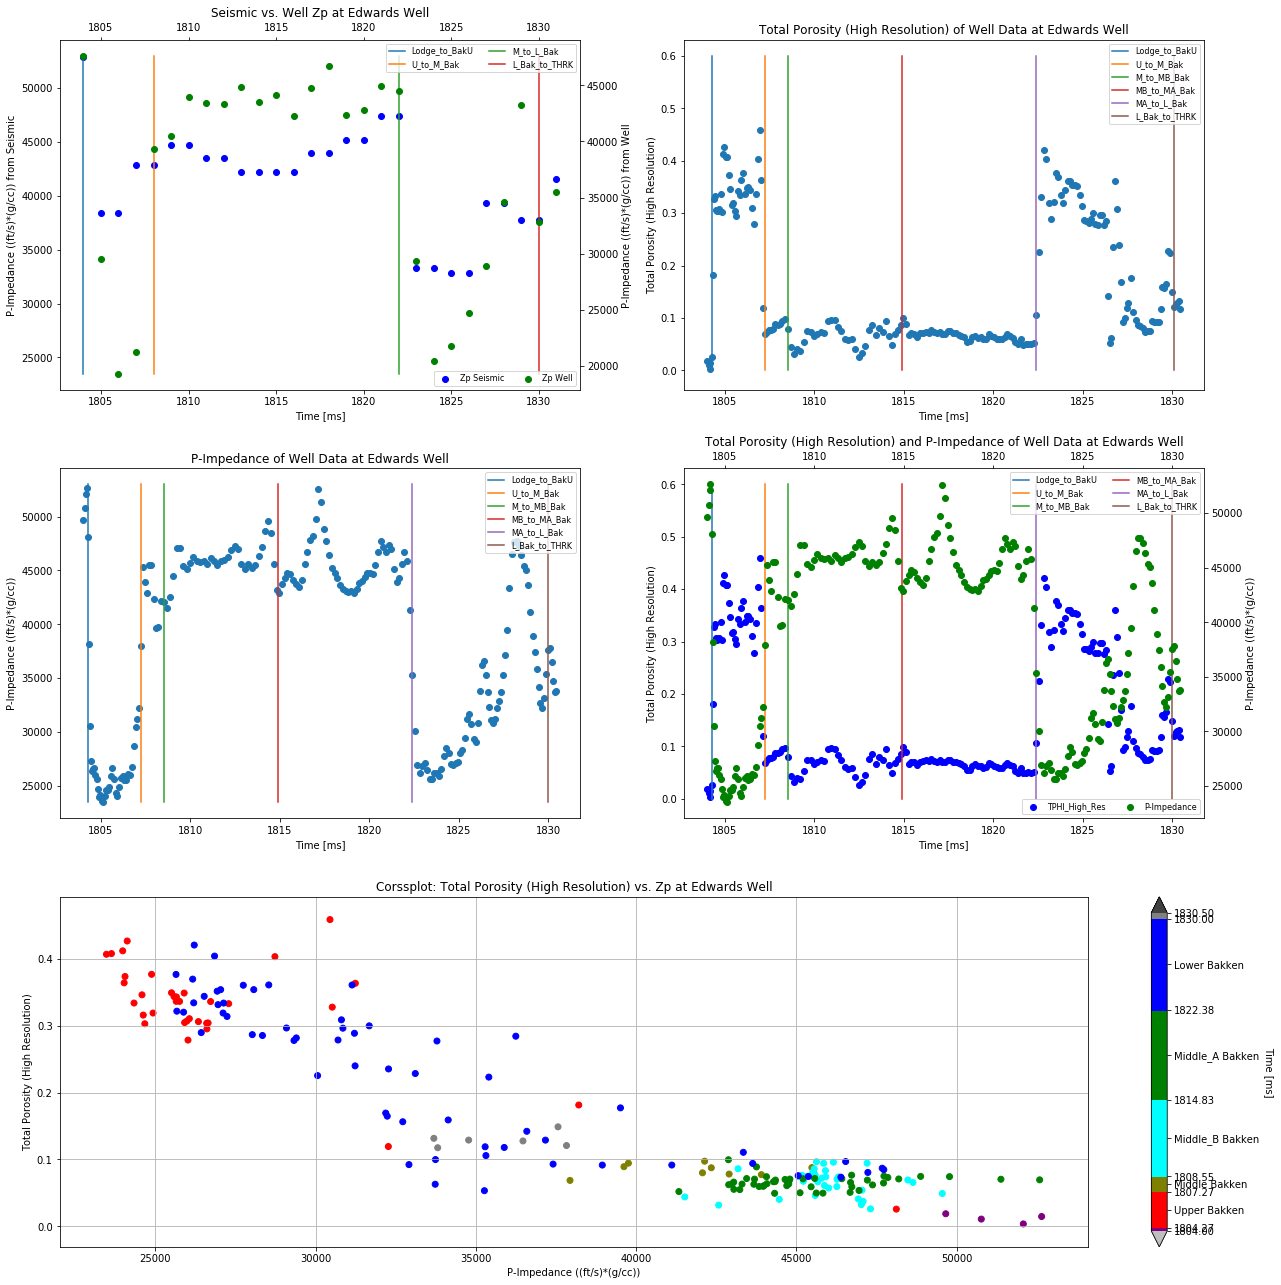

In [36]:
###################################################################################################################
fig = plt.figure(figsize=(18, 18))
###################################################################################################################
Lodge_to_BakU = 1804.27
U_to_M_Bak = 1807.27
M_to_MB_Bak = 1808.55
MB_to_MA_Bak = 1814.93
MA_to_L_Bak = 1822.38
L_Bak_to_THRK = 1830.0
###################################################################################################################
ax01 = fig.add_subplot(3, 2, 1, label="1")
seismic_zp_plot = ax01.scatter(df_seismic_zp_edwards['Time_ms'].values, df_seismic_zp_edwards['Zp'].values, c='b')
ax01.plot([1804, 1804], [53000, 23450], label='Lodge_to_BakU')    # 1782 ms
ax01.plot([1808, 1808], [53000, 23450], label='U_to_M_Bak')       # 1786 ms
ax01.plot([1822, 1822], [53000, 23450], label='M_to_L_Bak')       # 1794 ms
ax01.plot([1830, 1830], [53000, 23450], label='L_Bak_to_THRK')    # 1800 ms
ax01.yaxis.tick_left()
ax01.set_ylabel("P-Impedance ((ft/s)*(g/cc)) from Seismic")
ax01.yaxis.set_label_position('left') 
ax01.xaxis.tick_bottom()
ax01.set_xlabel("Time [ms]")
plt.legend(loc='upper right', ncol=2, fontsize=8)
###################################################################################################################
ax001 = fig.add_subplot(3, 2, 1, label="2",frame_on=False)
well_zp_plot = ax001.scatter(df_well_edwards_seismic_subset['Time_ms'].values, df_well_edwards_seismic_subset['P_Imped_Trans'].values, c='g')
ax001.yaxis.tick_right()
ax001.set_ylabel("P-Impedance ((ft/s)*(g/cc)) from Well")
ax001.yaxis.set_label_position('right') 
ax001.xaxis.tick_top()
ax001.set_title("Seismic vs. Well Zp at Edwards Well")
plt.legend((seismic_zp_plot, well_zp_plot), ('Zp Seismic', 'Zp Well'), loc='lower right', ncol=2, fontsize=8)
###################################################################################################################
ax02 = fig.add_subplot(3, 2, 2)
ax02.scatter(df_well_edwards_subset['TWT_ms'].values, df_well_edwards_subset['TPHI_High_Res'].values)
ax02.plot([Lodge_to_BakU, Lodge_to_BakU], [0.6, 0], label='Lodge_to_BakU')      # 1804.27 ms
ax02.plot([U_to_M_Bak, U_to_M_Bak], [0.6, 0], label='U_to_M_Bak')               # 1807.27 ms
ax02.plot([M_to_MB_Bak, M_to_MB_Bak], [0.6, 0], label='M_to_MB_Bak')            # apx 0 ms
ax02.plot([MB_to_MA_Bak, MB_to_MA_Bak], [0.6, 0], label='MB_to_MA_Bak')         # apx 0 ms
ax02.plot([MA_to_L_Bak, MA_to_L_Bak], [0.6, 0], label='MA_to_L_Bak')            # 1822.27 ms
ax02.plot([1830.1, 1830.1], [0.6, 0], label='L_Bak_to_THRK')                    # 1830.1 ms
ax02.set_ylabel("Total Porosity (High Resolution)")
ax02.set_xlabel("Time [ms]")
ax02.set_title("Total Porosity (High Resolution) of Well Data at Edwards Well")
plt.legend(loc='upper right', ncol=1, fontsize=8)
###################################################################################################################
ax03 = fig.add_subplot(3, 2, 3)
ax03.scatter(df_well_edwards_subset['TWT_ms'].values, df_well_edwards_subset['Computed_P_Impedance'].values)
ax03.plot([Lodge_to_BakU, Lodge_to_BakU], [53000, 23450], label='Lodge_to_BakU')    # 1804.27 ms
ax03.plot([U_to_M_Bak, U_to_M_Bak], [53000, 23450], label='U_to_M_Bak')             # 1807.27 ms
ax03.plot([M_to_MB_Bak, M_to_MB_Bak], [53000, 23450], label='M_to_MB_Bak')          # apx 0 ms
ax03.plot([MB_to_MA_Bak, MB_to_MA_Bak], [53000, 23450], label='MB_to_MA_Bak')       # apx 0 ms
ax03.plot([MA_to_L_Bak, MA_to_L_Bak], [53000, 23450], label='MA_to_L_Bak')          # 1822.27 ms
ax03.plot([L_Bak_to_THRK, L_Bak_to_THRK], [53000, 23450], label='L_Bak_to_THRK')    # 1830.1 ms
ax03.set_ylabel("P-Impedance ((ft/s)*(g/cc))")
ax03.set_xlabel("Time [ms]")
ax03.set_title("P-Impedance of Well Data at Edwards Well")
plt.legend(loc='upper right', ncol=1, fontsize=8)
###################################################################################################################
ax002 = fig.add_subplot(3, 2, 4, label="1")
nphi_plot = ax002.scatter(df_well_edwards_subset['TWT_ms'].values, df_well_edwards_subset['TPHI_High_Res'].values, c='b')
ax002.plot([Lodge_to_BakU, Lodge_to_BakU], [0.6, 0], label='Lodge_to_BakU')      # 1804.27 ms
ax002.plot([U_to_M_Bak, U_to_M_Bak], [0.6, 0], label='U_to_M_Bak')               # 1807.27 ms
ax002.plot([M_to_MB_Bak, M_to_MB_Bak], [0.6, 0], label='M_to_MB_Bak')            # apx 1810 ms
ax002.plot([MB_to_MA_Bak, MB_to_MA_Bak], [0.6, 0], label='MB_to_MA_Bak')         # apx 1816.5 ms
ax002.plot([MA_to_L_Bak, MA_to_L_Bak], [0.6, 0], label='MA_to_L_Bak')            # 1822.27 ms
ax002.plot([L_Bak_to_THRK, L_Bak_to_THRK], [0.6, 0], label='L_Bak_to_THRK')      # 1830.1 ms
ax002.yaxis.tick_left()
ax002.set_ylabel("Total Porosity (High Resolution)")
ax002.yaxis.set_label_position('left') 
ax002.xaxis.tick_bottom()
ax002.set_xlabel("Time [ms]")
plt.legend(loc='upper right', ncol=2, fontsize=8)
###################################################################################################################
ax003 = fig.add_subplot(3, 2, 4, label="2",frame_on=False)
zp_plot = ax003.scatter(df_well_edwards_subset['TWT_ms'].values, df_well_edwards_subset['Computed_P_Impedance'].values, c='g')
ax003.yaxis.tick_right()
ax003.set_ylabel("P-Impedance ((ft/s)*(g/cc))")
ax003.yaxis.set_label_position('right') 
ax003.xaxis.tick_top()
ax003.set_title("Total Porosity (High Resolution) and P-Impedance of Well Data at Edwards Well")
plt.legend((nphi_plot, zp_plot), ('TPHI_High_Res', 'P-Impedance'), loc='lower right', ncol=2, fontsize=8)
###################################################################################################################
###################################################################################################################
gs00 = gridspec.GridSpec(3, 2)
ax = fig.add_subplot(gs00[2, :])

cmap = mpl.colors.ListedColormap(['purple', 'red', 'olive', 'cyan', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1804.0, Lodge_to_BakU, U_to_M_Bak, M_to_MB_Bak, MB_to_MA_Bak, MA_to_L_Bak, L_Bak_to_THRK, 1830.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cc = ax.scatter(df_well_edwards_subset['Computed_P_Impedance'], df_well_edwards_subset['TPHI_High_Res'], c=df_well_edwards_subset['TWT_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1804.0, Lodge_to_BakU, (Lodge_to_BakU+U_to_M_Bak)/2, U_to_M_Bak, (U_to_M_Bak+M_to_MB_Bak)/2, M_to_MB_Bak, (M_to_MB_Bak+MB_to_MA_Bak)/2, MB_to_MA_Bak, (MB_to_MA_Bak+MA_to_L_Bak)/2, MA_to_L_Bak, (MA_to_L_Bak+L_Bak_to_THRK)/2, L_Bak_to_THRK, 1830.5]
label_cbar = ["1804.00", "1804.27", "Upper Bakken", "1807.27", "Middle Bakken", "1808.55", "Middle_B Bakken", "1814.83", "Middle_A Bakken", "1822.38", "Lower Bakken", "1830.00", "1830.50"]
cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("P-Impedance ((ft/s)*(g/cc))")
ax.set_ylabel("Total Porosity (High Resolution)")
ax.set_title("Corssplot: Total Porosity (High Resolution) vs. Zp at Edwards Well")
ax.grid()

###################################################################################################################
plt.tight_layout()
plt.show()
###################################################################################################################

#### Now shows both the big picture Lucy and Edwards crossplots together

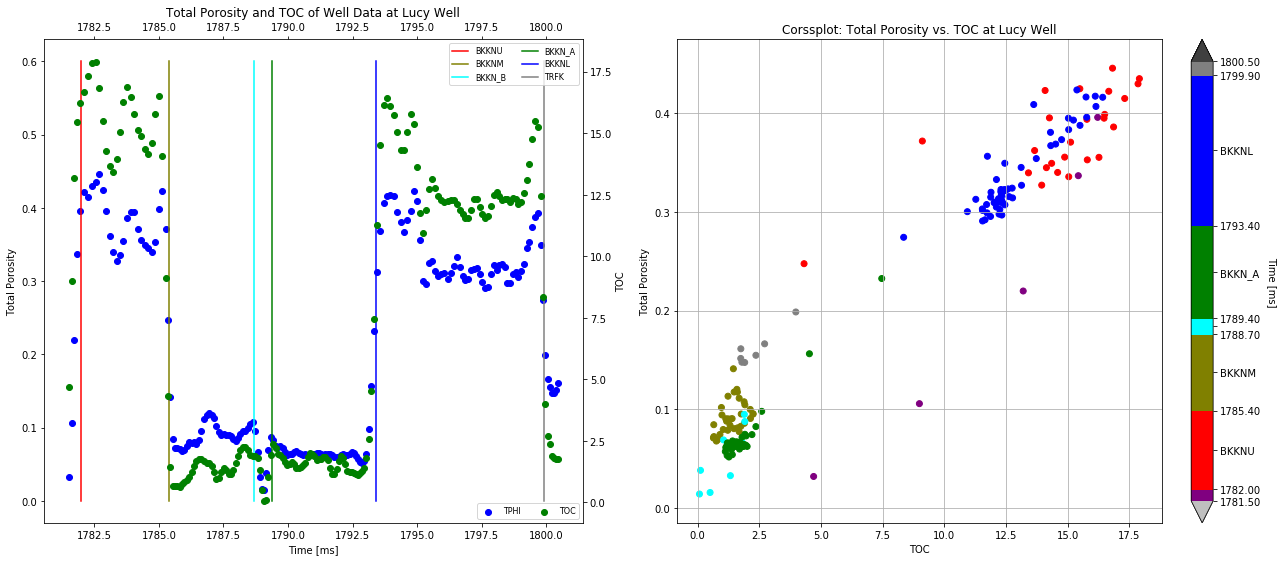

In [37]:
###################################################################################################################
# fig = plt.figure(figsize=(25, 18))
# fig = plt.figure(figsize=(20, 10))
fig = plt.figure(figsize=(18, 8))
###################################################################################################################
# Plot Lucy info, where...
Lodge_to_BakU = 1782
U_to_M_Bak = 1785.4
M_to_MB_Bak = 1788.7
MB_to_MA_Bak = 1789.4
MA_to_L_Bak = 1793.4
L_Bak_to_THRK = 1799.9
'''
###################################################################################################################
ax02 = fig.add_subplot(2, 2, 1, label="1")
nphi_plot = ax02.scatter(df_well_lucy_subset['TWT_ms'].values, df_well_lucy_subset['TPHI_Low_Res'].values, c='b')
ax02.plot([Lodge_to_BakU, Lodge_to_BakU], [0.6, 0], label='BKKNU', c='red')     # 1782 ms
ax02.plot([U_to_M_Bak, U_to_M_Bak], [0.6, 0], label='BKKNM', c='olive')         # 1786 ms
ax02.plot([M_to_MB_Bak, M_to_MB_Bak], [0.6, 0], label='BKKN_B', c='cyan')       # apx 1789 ms
ax02.plot([MB_to_MA_Bak, MB_to_MA_Bak], [0.6, 0], label='BKKN_A', c='green')    # apx 1790 ms
ax02.plot([MA_to_L_Bak, MA_to_L_Bak], [0.6, 0], label='BKKNL', c='blue')        # 1794 ms
ax02.plot([L_Bak_to_THRK, L_Bak_to_THRK], [0.6, 0], label='TRFK', c='grey')     # 1800 ms
ax02.yaxis.tick_left()
ax02.set_ylabel("Total Porosity")
ax02.yaxis.set_label_position('left') 
ax02.xaxis.tick_bottom()
ax02.set_xlabel("Time [ms]")
plt.legend(loc='upper right', ncol=2, fontsize=8)
###################################################################################################################
ax03 = fig.add_subplot(2, 2, 1, label="2",frame_on=False)
zp_plot = ax03.scatter(df_well_lucy_subset['TWT_ms'].values, df_well_lucy_subset['Computed_P_Impedance'].values, c='g')
ax03.yaxis.tick_right()
ax03.set_ylabel("P-Impedance ((ft/s)*(g/cc))")
ax03.yaxis.set_label_position('right') 
ax03.xaxis.tick_top()
ax03.set_title("Total Porosity and Zp of Well Data at Lucy Well")
plt.legend((nphi_plot, zp_plot), ('TPHI', 'P-Impedance'), loc='lower right', ncol=2, fontsize=8)
###################################################################################################################
###################################################################################################################
ax = fig.add_subplot(2, 2, 2)

cmap = mpl.colors.ListedColormap(['purple', 'red', 'olive', 'cyan', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1781.5, Lodge_to_BakU, U_to_M_Bak, M_to_MB_Bak, MB_to_MA_Bak, MA_to_L_Bak, L_Bak_to_THRK, 1800.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cc = ax.scatter(df_well_lucy_subset['Computed_P_Impedance'], df_well_lucy_subset['TPHI_Low_Res'], c=df_well_lucy_subset['TWT_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1781.5, Lodge_to_BakU, (Lodge_to_BakU+U_to_M_Bak)/2, U_to_M_Bak, (U_to_M_Bak+M_to_MB_Bak)/2, M_to_MB_Bak, (M_to_MB_Bak+MB_to_MA_Bak)/2, MB_to_MA_Bak, (MB_to_MA_Bak+MA_to_L_Bak)/2, MA_to_L_Bak, (MA_to_L_Bak+L_Bak_to_THRK)/2, L_Bak_to_THRK, 1800.5]
label_cbar = ["1781.50", "1782.00", "BKKNU", "1785.40", "BKKNM", "1788.70", "", "1789.40", "BKKN_A", "1793.40", "BKKNL", "1799.90", "1800.50"]
cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("P-Impedance ((ft/s)*(g/cc))")
ax.set_ylabel("Total Porosity")
ax.set_title("Corssplot: Total Porosity vs. Zp at Lucy Well")
ax.grid()
'''
###################################################################################################################
###################################################################################################################
ax002 = fig.add_subplot(1, 2, 1, label="1")
ax02 = ax002
nphi_plot = ax02.scatter(df_well_lucy_subset['TWT_ms'].values, df_well_lucy_subset['TPHI_Low_Res'].values, c='b')
ax02.plot([Lodge_to_BakU, Lodge_to_BakU], [0.6, 0], label='BKKNU', c='red')     # 1782 ms
ax02.plot([U_to_M_Bak, U_to_M_Bak], [0.6, 0], label='BKKNM', c='olive')         # 1786 ms
ax02.plot([M_to_MB_Bak, M_to_MB_Bak], [0.6, 0], label='BKKN_B', c='cyan')       # apx 1789 ms
ax02.plot([MB_to_MA_Bak, MB_to_MA_Bak], [0.6, 0], label='BKKN_A', c='green')    # apx 1790 ms
ax02.plot([MA_to_L_Bak, MA_to_L_Bak], [0.6, 0], label='BKKNL', c='blue')        # 1794 ms
ax02.plot([L_Bak_to_THRK, L_Bak_to_THRK], [0.6, 0], label='TRFK', c='grey')     # 1800 ms
ax02.yaxis.tick_left()
ax02.set_ylabel("Total Porosity")
ax02.yaxis.set_label_position('left') 
ax02.xaxis.tick_bottom()
ax02.set_xlabel("Time [ms]")
plt.legend(loc='upper right', ncol=2, fontsize=8)
###################################################################################################################
ax003 = fig.add_subplot(1, 2, 1, label="2",frame_on=False)
ax03 = ax003
toc_plot = ax03.scatter(df_well_lucy_subset['TWT_ms'].values, df_well_lucy_subset['TOC'].values, c='g')
ax03.yaxis.tick_right()
ax03.set_ylabel("TOC")
ax03.yaxis.set_label_position('right') 
ax03.xaxis.tick_top()
ax03.set_title("Total Porosity and TOC of Well Data at Lucy Well")
plt.legend((nphi_plot, toc_plot), ('TPHI', 'TOC'), loc='lower right', ncol=2, fontsize=8)
###################################################################################################################
###################################################################################################################
ax00 = fig.add_subplot(1, 2, 2)
ax = ax00
cmap = mpl.colors.ListedColormap(['purple', 'red', 'olive', 'cyan', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1781.5, Lodge_to_BakU, U_to_M_Bak, M_to_MB_Bak, MB_to_MA_Bak, MA_to_L_Bak, L_Bak_to_THRK, 1800.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cc = ax.scatter(df_well_lucy_subset['TOC'], df_well_lucy_subset['TPHI_Low_Res'], c=df_well_lucy_subset['TWT_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1781.5, Lodge_to_BakU, (Lodge_to_BakU+U_to_M_Bak)/2, U_to_M_Bak, (U_to_M_Bak+M_to_MB_Bak)/2, M_to_MB_Bak, (M_to_MB_Bak+MB_to_MA_Bak)/2, MB_to_MA_Bak, (MB_to_MA_Bak+MA_to_L_Bak)/2, MA_to_L_Bak, (MA_to_L_Bak+L_Bak_to_THRK)/2, L_Bak_to_THRK, 1800.5]
label_cbar = ["1781.50", "1782.00", "BKKNU", "1785.40", "BKKNM", "1788.70", "", "1789.40", "BKKN_A", "1793.40", "BKKNL", "1799.90", "1800.50"]
cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("TOC")
ax.set_ylabel("Total Porosity")
ax.set_title("Corssplot: Total Porosity vs. TOC at Lucy Well")
ax.grid()
###################################################################################################################
plt.tight_layout()
plt.show()
###################################################################################################################

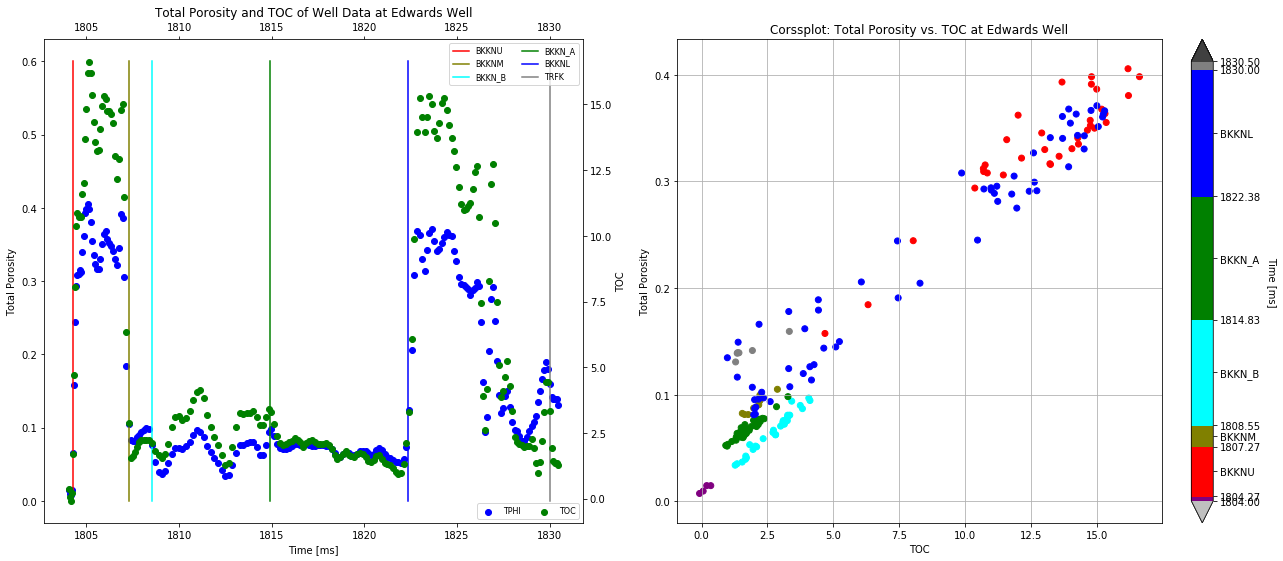

In [38]:
###################################################################################################################
# fig = plt.figure(figsize=(20, 10))
fig = plt.figure(figsize=(18, 8))
###################################################################################################################
# Plot Endwards info, where...
Lodge_to_BakU = 1804.27
U_to_M_Bak = 1807.27
M_to_MB_Bak = 1808.55
MB_to_MA_Bak = 1814.93
MA_to_L_Bak = 1822.38
L_Bak_to_THRK = 1830.0
'''
###################################################################################################################
ax002 = fig.add_subplot(2, 2, 1, label="1")
nphi_plot = ax002.scatter(df_well_edwards_subset['TWT_ms'].values, df_well_edwards_subset['TPHI_Low_Res'].values, c='b')
ax002.plot([Lodge_to_BakU, Lodge_to_BakU], [0.6, 0], label='BKKNU', c='red')     # 1804.27 ms
ax002.plot([U_to_M_Bak, U_to_M_Bak], [0.6, 0], label='BKKNM', c='olive')         # 1807.27 ms
ax002.plot([M_to_MB_Bak, M_to_MB_Bak], [0.6, 0], label='BKKN_B', c='cyan')       # apx 1810 ms
ax002.plot([MB_to_MA_Bak, MB_to_MA_Bak], [0.6, 0], label='BKKN_A', c='green')    # apx 1816.5 ms
ax002.plot([MA_to_L_Bak, MA_to_L_Bak], [0.6, 0], label='BKKNL', c='blue')        # 1822.27 ms
ax002.plot([L_Bak_to_THRK, L_Bak_to_THRK], [0.6, 0], label='TRFK', c='grey')     # 1830.1 ms
ax002.yaxis.tick_left()
ax002.set_ylabel("Total Porosity")
ax002.yaxis.set_label_position('left') 
ax002.xaxis.tick_bottom()
ax002.set_xlabel("Time [ms]")
plt.legend(loc='upper right', ncol=2, fontsize=8)
###################################################################################################################
ax003 = fig.add_subplot(2, 2, 1, label="2",frame_on=False)
zp_plot = ax003.scatter(df_well_edwards_subset['TWT_ms'].values, df_well_edwards_subset['Computed_P_Impedance'].values, c='g')
ax003.yaxis.tick_right()
ax003.set_ylabel("P-Impedance ((ft/s)*(g/cc))")
ax003.yaxis.set_label_position('right') 
ax003.xaxis.tick_top()
ax003.set_title("Total Porosity and P-Impedance of Well Data at Edwards Well")
plt.legend((nphi_plot, zp_plot), ('TPHI', 'P-Impedance'), loc='lower right', ncol=2, fontsize=8)
###################################################################################################################
###################################################################################################################
ax = fig.add_subplot(2, 2, 2)

cmap = mpl.colors.ListedColormap(['purple', 'red', 'olive', 'cyan', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1804.0, Lodge_to_BakU, U_to_M_Bak, M_to_MB_Bak, MB_to_MA_Bak, MA_to_L_Bak, L_Bak_to_THRK, 1830.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cc = ax.scatter(df_well_edwards_subset['Computed_P_Impedance'], df_well_edwards_subset['TPHI_Low_Res'], c=df_well_edwards_subset['TWT_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1804.0, Lodge_to_BakU, (Lodge_to_BakU+U_to_M_Bak)/2, U_to_M_Bak, (U_to_M_Bak+M_to_MB_Bak)/2, M_to_MB_Bak, (M_to_MB_Bak+MB_to_MA_Bak)/2, MB_to_MA_Bak, (MB_to_MA_Bak+MA_to_L_Bak)/2, MA_to_L_Bak, (MA_to_L_Bak+L_Bak_to_THRK)/2, L_Bak_to_THRK, 1830.5]
label_cbar = ["1804.00", "1804.27", "BKKNU", "1807.27", "BKKNM", "1808.55", "BKKN_B", "1814.83", "BKKN_A", "1822.38", "BKKNL", "1830.00", "1830.50"]

cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("P-Impedance ((ft/s)*(g/cc))")
ax.set_ylabel("Total Porosity")
ax.set_title("Corssplot: Total Porosity vs. Zp at Edwards Well")
ax.grid()
'''
###################################################################################################################
ax002 = fig.add_subplot(1, 2, 1, label="1")
ax02 = ax002
nphi_plot = ax02.scatter(df_well_edwards_subset['TWT_ms'].values, df_well_edwards_subset['TPHI_Low_Res'].values, c='b')
ax02.plot([Lodge_to_BakU, Lodge_to_BakU], [0.6, 0], label='BKKNU', c='red')
ax02.plot([U_to_M_Bak, U_to_M_Bak], [0.6, 0], label='BKKNM', c='olive')
ax02.plot([M_to_MB_Bak, M_to_MB_Bak], [0.6, 0], label='BKKN_B', c='cyan')
ax02.plot([MB_to_MA_Bak, MB_to_MA_Bak], [0.6, 0], label='BKKN_A', c='green')
ax02.plot([MA_to_L_Bak, MA_to_L_Bak], [0.6, 0], label='BKKNL', c='blue')
ax02.plot([L_Bak_to_THRK, L_Bak_to_THRK], [0.6, 0], label='TRFK', c='grey')
ax02.yaxis.tick_left()
ax02.set_ylabel("Total Porosity")
ax02.yaxis.set_label_position('left') 
ax02.xaxis.tick_bottom()
ax02.set_xlabel("Time [ms]")
plt.legend(loc='upper right', ncol=2, fontsize=8)
###################################################################################################################
ax003 = fig.add_subplot(1, 2, 1, label="2",frame_on=False)
ax03 = ax003
toc_plot = ax03.scatter(df_well_edwards_subset['TWT_ms'].values, df_well_edwards_subset['TOC'].values, c='g')
ax03.yaxis.tick_right()
ax03.set_ylabel("TOC")
ax03.yaxis.set_label_position('right') 
ax03.xaxis.tick_top()
ax03.set_title("Total Porosity and TOC of Well Data at Edwards Well")
plt.legend((nphi_plot, toc_plot), ('TPHI', 'TOC'), loc='lower right', ncol=2, fontsize=8)
###################################################################################################################
###################################################################################################################
ax00 = fig.add_subplot(1, 2, 2)
ax = ax00
cmap = mpl.colors.ListedColormap(['purple', 'red', 'olive', 'cyan', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1804.0, Lodge_to_BakU, U_to_M_Bak, M_to_MB_Bak, MB_to_MA_Bak, MA_to_L_Bak, L_Bak_to_THRK, 1830.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cc = ax.scatter(df_well_edwards_subset['TOC'], df_well_edwards_subset['TPHI_Low_Res'], c=df_well_edwards_subset['TWT_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1804.0, Lodge_to_BakU, (Lodge_to_BakU+U_to_M_Bak)/2, U_to_M_Bak, (U_to_M_Bak+M_to_MB_Bak)/2, M_to_MB_Bak, (M_to_MB_Bak+MB_to_MA_Bak)/2, MB_to_MA_Bak, (MB_to_MA_Bak+MA_to_L_Bak)/2, MA_to_L_Bak, (MA_to_L_Bak+L_Bak_to_THRK)/2, L_Bak_to_THRK, 1830.5]
label_cbar = ["1804.00", "1804.27", "BKKNU", "1807.27", "BKKNM", "1808.55", "BKKN_B", "1814.83", "BKKN_A", "1822.38", "BKKNL", "1830.00", "1830.50"]

cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("TOC")
ax.set_ylabel("Total Porosity")
ax.set_title("Corssplot: Total Porosity vs. TOC at Edwards Well")
ax.grid()
###################################################################################################################
plt.tight_layout()
plt.show()
###################################################################################################################

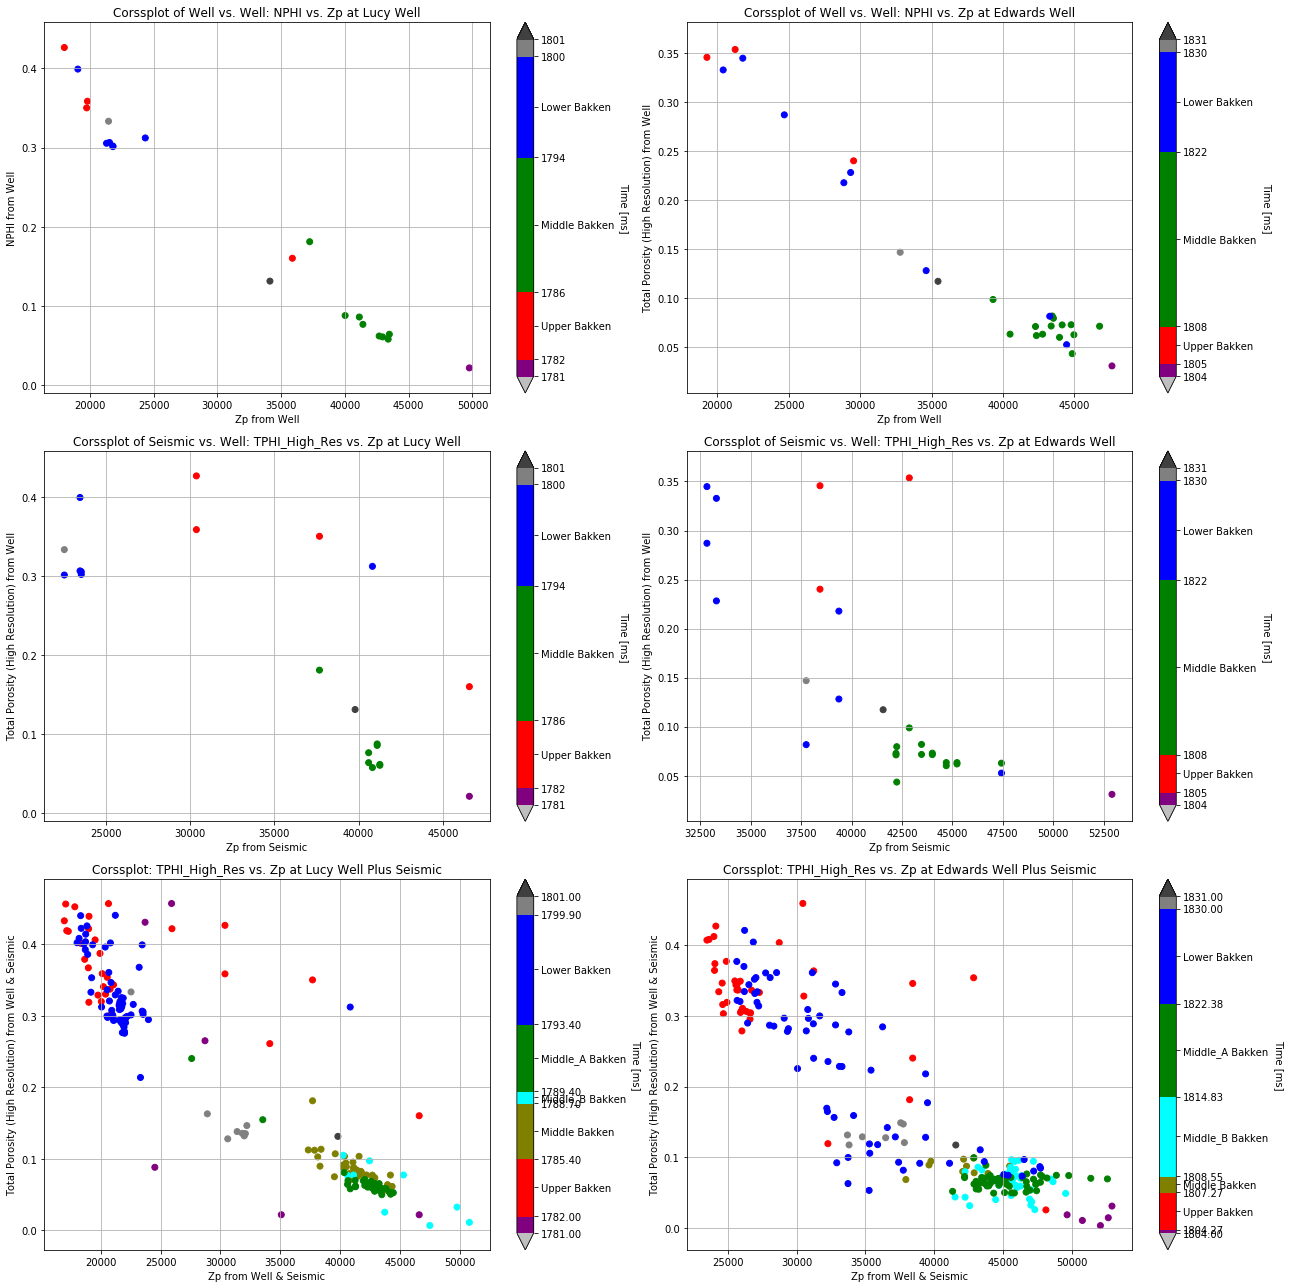

In [39]:
###################################################################################################################
fig = plt.figure(figsize=(18, 18))
ax1 = fig.add_subplot(3, 2, 1)
ax = ax1

cmap = mpl.colors.ListedColormap(['purple', 'red', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1781, 1782, 1786, 1794, 1800, 1801]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cc = ax.scatter(df_well_lucy_seismic_subset['P_Imped_Trans'].values, df_well_lucy_seismic_subset['TPHI_High_Res'].values, c=df_well_lucy_seismic_subset['Time_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1781, 1782, (1782+1786)/2, 1786, (1786+1794)/2, 1794, (1794+1800)/2, 1800, 1801]
label_cbar = ["1781", "1782", "Upper Bakken", "1786", "Middle Bakken", "1794", "Lower Bakken", "1800", "1801"]
cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("Zp from Well")
ax.set_ylabel("NPHI from Well")
ax.set_title("Corssplot of Well vs. Well: NPHI vs. Zp at Lucy Well")
ax.grid()
###################################################################################################################
ax2 = fig.add_subplot(3, 2, 2)
ax = ax2

cmap = mpl.colors.ListedColormap(['purple', 'red', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1804, 1805, 1808, 1822, 1830, 1831]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cc = ax.scatter(df_well_edwards_seismic_subset['P_Imped_Trans'].values, df_well_edwards_seismic_subset['TPHI_High_Res'].values, c=df_well_edwards_seismic_subset['Time_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1804, 1805, (1805+1808)/2, 1808, (1808+1822)/2, 1822, (1822+1830)/2, 1830, 1831]
label_cbar = ["1804", "1805", "Upper Bakken", "1808", "Middle Bakken", "1822", "Lower Bakken", "1830", "1831"]
cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("Zp from Well")
ax.set_ylabel("Total Porosity (High Resolution) from Well")
ax.set_title("Corssplot of Well vs. Well: NPHI vs. Zp at Edwards Well")
ax.grid()
###################################################################################################################
ax3 = fig.add_subplot(3, 2, 3)
ax = ax3

cmap = mpl.colors.ListedColormap(['purple', 'red', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1781, 1782, 1786, 1794, 1800, 1801]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cc = ax.scatter(df_seismic_zp_lucy['Zp'].values, df_well_lucy_seismic_subset['TPHI_High_Res'].values, c=df_well_lucy_seismic_subset['Time_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1781, 1782, (1782+1786)/2, 1786, (1786+1794)/2, 1794, (1794+1800)/2, 1800, 1801]
label_cbar = ["1781", "1782", "Upper Bakken", "1786", "Middle Bakken", "1794", "Lower Bakken", "1800", "1801"]
cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("Zp from Seismic")
ax.set_ylabel("Total Porosity (High Resolution) from Well")
ax.set_title("Corssplot of Seismic vs. Well: TPHI_High_Res vs. Zp at Lucy Well")
ax.grid()
###################################################################################################################
ax4 = fig.add_subplot(3, 2, 4)
ax = ax4

cmap = mpl.colors.ListedColormap(['purple', 'red', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [1804, 1805, 1808, 1822, 1830, 1831]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cc = ax.scatter(df_seismic_zp_edwards['Zp'].values, df_well_edwards_seismic_subset['TPHI_High_Res'].values, c=df_well_edwards_seismic_subset['Time_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1804, 1805, (1805+1808)/2, 1808, (1808+1822)/2, 1822, (1822+1830)/2, 1830, 1831]
label_cbar = ["1804", "1805", "Upper Bakken", "1808", "Middle Bakken", "1822", "Lower Bakken", "1830", "1831"]
cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("Zp from Seismic")
ax.set_ylabel("Total Porosity (High Resolution) from Well")
ax.set_title("Corssplot of Seismic vs. Well: TPHI_High_Res vs. Zp at Edwards Well")
ax.grid()
###################################################################################################################
ax5 = fig.add_subplot(3, 2, 5)
ax = ax5

cmap = mpl.colors.ListedColormap(['purple', 'red', 'olive', 'cyan', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

Lodge_to_BakU = 1782
U_to_M_Bak = 1785.4
M_to_MB_Bak = 1788.7
MB_to_MA_Bak = 1789.4
MA_to_L_Bak = 1793.4
L_Bak_to_THRK = 1799.9

bounds = [1781, Lodge_to_BakU, U_to_M_Bak, M_to_MB_Bak, MB_to_MA_Bak, MA_to_L_Bak, L_Bak_to_THRK, 1801]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cc = ax.scatter(df_lucy_all['Zp'].values, df_lucy_all['TPHI_High_Res'].values, c=df_lucy_all['Time_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1781, Lodge_to_BakU, (Lodge_to_BakU+U_to_M_Bak)/2, U_to_M_Bak, (U_to_M_Bak+M_to_MB_Bak)/2, M_to_MB_Bak, (M_to_MB_Bak+MB_to_MA_Bak)/2, MB_to_MA_Bak, (MB_to_MA_Bak+MA_to_L_Bak)/2, MA_to_L_Bak, (MA_to_L_Bak+L_Bak_to_THRK)/2, L_Bak_to_THRK, 1801]
label_cbar = ["1781.00", "1782.00", "Upper Bakken", "1785.40", "Middle Bakken", "1788.70", "Middle_B Bakken", "1789.40", "Middle_A Bakken", "1793.40", "Lower Bakken", "1799.90", "1801.00"]

cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("Zp from Well & Seismic")
ax.set_ylabel("Total Porosity (High Resolution) from Well & Seismic")
ax.set_title("Corssplot: TPHI_High_Res vs. Zp at Lucy Well Plus Seismic")
ax.grid()
###################################################################################################################
ax6 = fig.add_subplot(3, 2, 6)
ax = ax6

cmap = mpl.colors.ListedColormap(['purple', 'red', 'olive', 'cyan', 'green', 'blue', 'grey'])
cmap.set_over('0.25')
cmap.set_under('0.75')

Lodge_to_BakU = 1804.27
U_to_M_Bak = 1807.27
M_to_MB_Bak = 1808.55
MB_to_MA_Bak = 1814.93
MA_to_L_Bak = 1822.38
L_Bak_to_THRK = 1830.0

bounds = [1804, Lodge_to_BakU, U_to_M_Bak, M_to_MB_Bak, MB_to_MA_Bak, MA_to_L_Bak, L_Bak_to_THRK, 1831]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cc = ax.scatter(df_edwards_all['Zp'].values, df_edwards_all['TPHI_High_Res'].values, c=df_edwards_all['Time_ms'], cmap=cmap, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([cc])

cbar = fig.colorbar(sm, ax=ax, cmap=cmap, norm=norm, extend='both', ticks=bounds, spacing="proportional", fraction=0.046, pad=0.055)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ms]', rotation=270)

ticks_cbar = [1804.0, Lodge_to_BakU, (Lodge_to_BakU+U_to_M_Bak)/2, U_to_M_Bak, (U_to_M_Bak+M_to_MB_Bak)/2, M_to_MB_Bak, (M_to_MB_Bak+MB_to_MA_Bak)/2, MB_to_MA_Bak, (MB_to_MA_Bak+MA_to_L_Bak)/2, MA_to_L_Bak, (MA_to_L_Bak+L_Bak_to_THRK)/2, L_Bak_to_THRK, 1831]
label_cbar = ["1804.00", "1804.27", "Upper Bakken", "1807.27", "Middle Bakken", "1808.55", "Middle_B Bakken", "1814.83", "Middle_A Bakken", "1822.38", "Lower Bakken", "1830.00", "1831.00"]

cbar.set_ticks(ticks_cbar)
cbar.set_ticklabels(label_cbar)

ax.set_xlabel("Zp from Well & Seismic")
ax.set_ylabel("Total Porosity (High Resolution) from Well & Seismic")
ax.set_title("Corssplot: TPHI_High_Res vs. Zp at Edwards Well Plus Seismic")
ax.grid()
###################################################################################################################
plt.tight_layout()
plt.show()
###################################################################################################################
# Results make sense because when performing the inverison, the inversion didn't get the Upper Bakken well, but
# it did get the Lower Bakken quite well
###################################################################################################################

Given the difference in resolution between seismic and well log data, it appears I can bin the data into 3 groups:
1. Upper Bakken
2. Middle Bakken
3. Lower Bakken (this one has much more variability within it at Edwards well than at Lucy well)

The slight differences within the Middle Bakken are to high of a resolution for the seismic to pick up since the ultimate goal is to predict a target petrophysical log across the entire using the derived inverted seismic attribute and given the tuned predictive model obtained from the train & test problem of this workflow (this is what follows next) 

### Part 3: The Train & Test Problem:
#### Performing K-means Clustering
* Goal here is to bin the data into 3 to 4 groups based on the geological interpretations I have made of the Bakken reservoir given the cluster analysis results of this workflow.... And another goal of K-means clustering here is to seperate data into training and testing datasets with reduced sampling bias. Afterwards, tune the hyperparameters of the BNN with the binned and training and testing datasets before using the BNN to predict petrophysical properties across all seismic traces

In [40]:
'''
###################################################################################################################
df_lucy_all_new1 = df_lucy_all_new
df_lucy_all_new1_X = df_lucy_all_new1['X']
df_lucy_all_new1_Y = df_lucy_all_new1['Y']
df_lucy_all_new1_P_Velo = df_lucy_all_new1['P_Velo_from_Well']
df_lucy_all_new1_Zp_from_Seismic = df_lucy_all_new1['Zp_from_Seismic']
df_lucy_all_new1_DPOR_Low_Res_from_Well = df_lucy_all_new1['DPOR_Low_Res_from_Well']
df_lucy_all_new1_DPOR_High_Res_from_Well = df_lucy_all_new1['DPOR_High_Res_from_Well']
df_lucy_all_new1_NPHI_Low_Res_from_Well = df_lucy_all_new1['NPHI_Low_Res_from_Well']
df_lucy_all_new1_NPHI_High_Res_from_Well = df_lucy_all_new1['NPHI_High_Res_from_Well']
df_lucy_all_new1_TPHI_Low_Res_from_Well = df_lucy_all_new1['TPHI_Low_Res_from_Well']
df_lucy_all_new1_TPHI_High_Res_from_Well = df_lucy_all_new1['TPHI_High_Res_from_Well']
df_lucy_all_new1_rhoz_from_Well = df_lucy_all_new1['RHOZ']
df_lucy_all_new1_toc_from_Well = df_lucy_all_new1['TOC']
df_lucy_all_new1 = df_lucy_all_new1.drop(['X'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['Y'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['P_Velo_from_Well'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['Zp_from_Seismic'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['DPOR_Low_Res_from_Well'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['DPOR_High_Res_from_Well'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['NPHI_Low_Res_from_Well'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['NPHI_High_Res_from_Well'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['TPHI_Low_Res_from_Well'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['TPHI_High_Res_from_Well'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['RHOZ'], axis=1)
df_lucy_all_new1 = df_lucy_all_new1.drop(['TOC'], axis=1)
df_lucy_all_new1['Inline'] = 2108
df_lucy_all_new1['Xline'] = 1165
df_lucy_all_new1['X'] = df_lucy_all_new1_X
df_lucy_all_new1['Y'] = df_lucy_all_new1_Y
df_lucy_all_new1['P_Velo_Well'] = df_lucy_all_new1_P_Velo
df_lucy_all_new1['Zp_Seismic'] = df_lucy_all_new1_Zp_from_Seismic
df_lucy_all_new1['TPHI_Low_Res_from_Well'] = df_lucy_all_new1_TPHI_Low_Res_from_Well
df_lucy_all_new1['TOC'] = df_lucy_all_new1_toc_from_Well

print(df_lucy_all_new1.shape)
###################################################################################################################
df_edwards_all_new1 = df_edwards_all_new
df_edwards_all_new1_X = df_edwards_all_new1['X']
df_edwards_all_new1_Y = df_edwards_all_new1['Y']
df_edwards_all_new1_P_Velo = df_edwards_all_new1['P_Velo_from_Well']
df_edwards_all_new1_Zp_from_Seismic = df_edwards_all_new1['Zp_from_Seismic']
df_edwards_all_new1_DPOR_Low_Res_from_Well = df_edwards_all_new1['DPOR_Low_Res_from_Well']
df_edwards_all_new1_DPOR_High_Res_from_Well = df_edwards_all_new1['DPOR_High_Res_from_Well']
df_edwards_all_new1_NPHI_Low_Res_from_Well = df_edwards_all_new1['NPHI_Low_Res_from_Well']
df_edwards_all_new1_NPHI_High_Res_from_Well = df_edwards_all_new1['NPHI_High_Res_from_Well']
df_edwards_all_new1_TPHI_Low_Res_from_Well = df_edwards_all_new1['TPHI_Low_Res_from_Well']
df_edwards_all_new1_TPHI_High_Res_from_Well = df_edwards_all_new1['TPHI_High_Res_from_Well']
df_edwards_all_new1_rhoz_from_Well = df_edwards_all_new1['RHOZ']
df_edwards_all_new1_toc_from_Well = df_edwards_all_new1['TOC']
df_edwards_all_new1 = df_edwards_all_new1.drop(['X'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['Y'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['P_Velo_from_Well'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['Zp_from_Seismic'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['DPOR_Low_Res_from_Well'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['DPOR_High_Res_from_Well'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['NPHI_Low_Res_from_Well'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['NPHI_High_Res_from_Well'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['TPHI_Low_Res_from_Well'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['TPHI_High_Res_from_Well'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['RHOZ'], axis=1)
df_edwards_all_new1 = df_edwards_all_new1.drop(['TOC'], axis=1)
df_edwards_all_new1['Inline'] = 1824
df_edwards_all_new1['Xline'] = 1073
df_edwards_all_new1['X'] = df_edwards_all_new1_X
df_edwards_all_new1['Y'] = df_edwards_all_new1_Y
df_edwards_all_new1['P_Velo_Well'] = df_edwards_all_new1_P_Velo
df_edwards_all_new1['Zp_Seismic'] = df_edwards_all_new1_Zp_from_Seismic
df_edwards_all_new1['TPHI_Low_Res_from_Well'] = df_edwards_all_new1_TPHI_Low_Res_from_Well
df_edwards_all_new1['TOC'] = df_edwards_all_new1_toc_from_Well

print(df_edwards_all_new1.shape)
###################################################################################################################
np_lucy_all_new1 = df_lucy_all_new1.values
np_edwards_all_new1 = df_edwards_all_new1.values
df_well_data_combined_new = np.vstack([np_lucy_all_new1, np_edwards_all_new1])
df_well_data_combined_new = pd.DataFrame(df_well_data_combined_new, columns=['Time_ms', 'Inline', 'Xline', 'X', 'Y', 'P_Velo_Well', 'Zp_Seismic', 'TPHI_Low_Res_from_Well', 'TOC'])
print(df_well_data_combined_new.shape)
###################################################################################################################
'''
print("Done")

Done


### Part 4: Bayesian Neural Learning via Langevin Dynamics MCMC Model –– Tuning the Hyperparameters given the Test and Train Datasets Derived from the Three Different Set-ups:
* Predicting NPHI given Comp_P_Imped as the input into the BNN
* Predictor feature(s) have been min/max normalized (-1.175 to +1.175 to allow for better flexibility/generalization)
* Target feature has been min/max normalized also, but from 0 to 1 since we are using a sigmoid activation function
* The BNN uses Langevin Dynamics to help the MCMC sample from the target distribution faster, where it is a gradient based approach that moves in a zig-zag fashion towards the target distribution, which is much more efficient than a random walk MCMC approach, which will take a much longer time to converge towards sampling the target distribution
* Note that MCMC comprises a class of algorithms for sampling from a probability distribution
* The BNN uses a Metropolis–Hastings step, which is used to accept or reject a given proposal achieved by the MCMC sampler. If proposal is accepted, then update the current state of the MCMC and move onto the next sample to see if it will be accepted or not. If rejected, then do not retain that proposal and just update it and try again with the next sample
* To elaborate, Langevin dynamics drive the random walk towards regions of high probability in the manner of a gradient flow, while the Metropolis–Hastings accept/reject mechanism improves the mixing and convergence properties of this random walk

#### Network Class
The network class resembles a feedforward neural network, which is the neural network portion of the BNN

In [41]:
class Network:
    def __init__(self, Top0, Top1, Top2, Train, Test, learn_rate):
        """
        :param Topo: NN topology [input, hidden, output]
        :param Train: Data that is associated with training data
        :param Test: Data that is associated with testing data
        :param learn_rate: Hyperparameter to help with convergence
        """
        self.Top0 = Top0
        self.Top1 = Top1
        self.Top2 = Top2
        self.Top = [self.Top0, self.Top1, self.Top2]
        # print("\nself.Top1 in Network declaration:     ", self.Top1)
        self.TrainData = Train
        self.TestData = Test
        np.random.seed()
        self.lrate = learn_rate

        self.W1 = np.random.randn(self.Top0, self.Top1) / np.sqrt(self.Top0)    # Weights of the first layer
        self.B1 = np.random.randn(1, self.Top1) / np.sqrt(self.Top1)            # Bias of the first layer
        self.W2 = np.random.randn(self.Top1, self.Top2) / np.sqrt(self.Top1)    # Weights of the second layer
        self.B2 = np.random.randn(1, self.Top2) / np.sqrt(self.Top1)            # Bias of the second layer

        self.hidout = np.zeros((1, self.Top1))                                  # Output of first hidden layer
        self.out = np.zeros((1, self.Top2))                                     # Output last layer

    def sigmoid(self, x):
        """
        :param x: a series of weights and input neurons multiplied together plus a bias
                    (3 or 9)x1 vector in the case of being at the hidden layer (before going to output)
                    1x1 vector in the case of after reaching the output layer (output of the output)
        :return: The activation function calculation at that given node
        – At hidden layer (before going to output), the activation function is a (3 or 9)x1 vector
        – After reaching the output layer (output of the output), the activation function is a 1x1 vector
        """
        return 1.0 / (1.0 + np.exp(-1.0*(x)))

    def sampleEr(self, actualout):
        """
        :param actualout: I am assuming this is the expected output/target data
        :return: The squared error
        """
        error = np.subtract(self.out, actualout)
        sqerror = np.sum(np.square(error)) / self.Top2
        return sqerror

    def ForwardPass(self, X):
        """
        :param X: Input, which has 1 neuron because there is 1 predictive feature
        :return: None
        – For self.hidout, at hidden layer (before going to output), the activation function is a 1x1 vector
        – For self.out, after reaching the output layer (output of the output), the activation function is a 1x1 vector
        """
        z1 = X.dot(self.W1) - self.B1
        self.hidout = self.sigmoid(z1)                          # Output of first hidden layer
        z2 = self.hidout.dot(self.W2) - self.B2
        self.out = self.sigmoid(z2)                             # Output second hidden layer

    def BackwardPass(self, Input, desired):
        """
        :param Input: This is Comp_P_Imped (i.e., the 1 input neuron)
        :param desired: This is the 2nd column of the dataset, which is NPHI
        :return: None
        """
        out_delta = (desired - self.out) * (self.out * (1 - self.out))
        hid_delta = out_delta.dot(self.W2.T) * (self.hidout * (1 - self.hidout))

        layer = 1  # Hidden to Output
        for x in range(0, self.Top[layer]):
            for y in range(0, self.Top[layer + 1]):
                self.W2[x, y] += self.lrate * out_delta[y] * self.hidout[x]
        for y in range(0, self.Top[layer + 1]):
            self.B2[y] += -1 * self.lrate * out_delta[y]

        layer = 0  # Input to Hidden
        for x in range(0, self.Top[layer]):
            for y in range(0, self.Top[layer + 1]):
                self.W1[x, y] += self.lrate * hid_delta[y] * Input[x]
        for y in range(0, self.Top[layer + 1]):
            self.B1[y] += -1 * self.lrate * hid_delta[y]

    def decode(self, w):
        """
        :param w: The weights with added bias
        :return: None
        """
        w_layer1size = self.Top0 * self.Top1
        w_layer2size = self.Top1 * self.Top2

        w_layer1 = w[0:w_layer1size]
        self.W1 = np.reshape(w_layer1, (self.Top0, self.Top1))

        w_layer2 = w[w_layer1size:w_layer1size + w_layer2size]
        self.W2 = np.reshape(w_layer2, (self.Top1, self.Top2))
        self.B1 = w[w_layer1size + w_layer2size:w_layer1size + w_layer2size + self.Top1]
        self.B2 = w[w_layer1size + w_layer2size + self.Top1:w_layer1size + w_layer2size + self.Top1 + self.Top2]

    def encode(self):
        """
        :return: The weights with added bias
        """
        w1 = self.W1.ravel()
        w2 = self.W2.ravel()
        w = np.concatenate([w1, w2, self.B1, self.B2])
        return w

    def langevin_gradient(self, data, w, depth):            # BP with SGD (Stochastic BP)
        """
        :param data: The training/testing dataset -> #x1 vector -> i.e., # rows of data with 1 feature: Comp_P_Imped
        :param w: Refers to the weights and biases, which are decoded into W1, W2, B1, and B2
        :param depth: Depth of gradient decent optimization
        :return: The newly updated weights and biases that have added Gaussian Noise
        """
        # print("In langevin_gradient:                 ", self.Top1)
        self.decode(w)                                      # Method to decode w into W1, W2, B1, B2
        size = data.shape[0]
        Input = np.zeros((1, self.Top0))                    # A temp to hold the input
        Desired = np.zeros((1, self.Top2))
        fx = np.zeros(size)

        for i in range(0, depth):
            for i in range(0, size):
                pat = i
                Input = data[pat, 0:self.Top0]
                Desired = data[pat, self.Top0:]
                self.ForwardPass(Input)
                self.BackwardPass(Input, Desired)

        w_updated = self.encode()
        return w_updated

    def evaluate_proposal(self, data, w):                   # BP with SGD (Stochastic BP)
        """
        :param data: The training/testing dataset -> #x1 vector -> i.e., # rows of data with 1 feature: Comp_P_Imped
        :param w: Refers to the weights and biases, which are decoded into W1, W2, B1, and B2
        :return: The predicted value of NPHI for a given sample
        """
        self.decode(w)                                      # Method to decode w into W1, W2, B1, and B2
        size = data.shape[0]
        Input = np.zeros((1, self.Top0))                    # A temp to hold the input
        Desired = np.zeros((1, self.Top2))
        fx = np.zeros(size)

        for i in range(0, size):                            # To see what fx is produced by your current weight update
            Input = data[i, 0:self.Top0]
            self.ForwardPass(Input)
            fx[i] = self.out
        return fx

#### (Optional) Topology Class
Update hidden number of neurons randomly

In [42]:
class TOPOLOGY:
    def __init__(self, inputs, hidden, output):
        """
        :param input:  Number of input neurons
        :param hidden: Number of hidden neurons (this is a random number between 1 and 10)
        :param output: Number of output neurons
        """
        self.input = inputs
        self.hidden = hidden
        self.output = output
        self.topology = [self.input, self.hidden, self.output]

    def randomly_updating_number_of_hidden_neurons(self):
        """
        :return: The topology with a new, randomly chosen, number of hidden neurons between 1 and 10
        """
        netw_ = self.topology
        netw_0 = netw_[0]
        netw_1 = netw_[1]
        netw_2 = netw_[2]
        hidden_rdn = int(np.random.randint(11, size=1))
        if hidden_rdn >= 1:
            netw_1 = hidden_rdn
        else:
            hidden_rdn = int(np.random.randint(11, size=1))
            if hidden_rdn >= 1:
                netw_1 = hidden_rdn

        return [netw_0, netw_1, netw_2]

#### MCMC Class
Probabilistic portion of the BNN

In [43]:
class MCMC:
    def __init__(self, use_langevin_gradients, l_prob, learn_rate, samples, traindata, testdata, topology):
        """
        :param use_langevin_gradients: Activation of the gradients to speed up convergence
        :param l_prob: Likelihood probability
        :param learn_rate: Hyperparameter to help with convergence
        :param samples: Max epocs –> one of the hyperparameters set to 200 before the execution of the BNN
        :param traindata: The training unconventional dataset
        :param testdata: The testing unconventional dataset
        :param topology: NN topology [input, hidden, output]
        """
        self.samples = samples
        self.topology = topology
        self.traindata = traindata
        self.testdata = testdata
        self.use_langevin_gradients = use_langevin_gradients
        self.l_prob = l_prob
        self.learn_rate = learn_rate

    def percentage_error(self, predicted, targets):
        """
        :param predicted: Predicted NPHI value from Comp_P_Imped found by the NN that is to be evaluated
        :param targets: Training or testing data -> In this case, it is the 2nd column of the dataset, which is NPHI
        :return: Percentage error between predicted and target value, which is to be used to help calcuate MAPE
                 given the possibility of zero division
        """
        res = np.empty(targets.shape)
        for j in range(targets.shape[0]):
            if targets[j] != 0:
                res[j] = (targets[j] - predicted[j]) / targets[j]
            else:
                res[j] = predicted[j] / np.mean(targets)
        return res
    
    def mean_absolute_percentage_error(self, predictions, targets):
        """
        :param predictions: Predicted NPHI value from Comp_P_Imped found by the NN that is to be evaluated
        :param targets: Training or testing data -> In this case, it is the 2nd column of the dataset, which is NPHI
        :return: The mean absolute percentage error between the updated predicted result and the target data, where we
                 are trying to minimize the error between the two in order to complete the training of the NN
        """
        return np.mean(np.abs(self.percentage_error(np.asarray(predictions), np.asarray(targets)))) * 100
    
    def rmse(self, predictions, targets):
        """
        :param predictions: Predicted NPHI value from Comp_P_Imped found by the NN that is to be evaluated
        :param targets: Training or testing data -> In this case, it is the 2nd column of the dataset, which is NPHI
        :return: The root mean square error between the updated predicted result and the target data, where we are
                 trying to minimize the error between the two in order to complete the training of the Neural Network
        """
        return np.sqrt(((predictions - targets) ** 2).mean())

    def r2_value(self, predictions, targets):
        """
        :param predictions: Predicted NPHI values given Comp_P_Imped
        :param targets: Actual NPHI values
        :return: The r^2 correlation value for a given prediction of the target feature
        """
        zx = (predictions - np.mean(predictions)) / np.std(predictions, ddof=1)
        zy = (targets - np.mean(targets)) / np.std(targets, ddof=1)
        r = np.sum(zx * zy) / (len(predictions) - 1)
        return r**2
    
    def variance_explained(self, predictions, targets):
        """
        :param predictions: Predicted NPHI values given Comp_P_Imped
        :param targets: Actual NPHI values
        :return: The variance explained over the total variance in the effort of predicting the target feature
        """
        return 1 - np.cov(np.array(targets) - np.array(predictions)) / np.cov(targets)

    def likelihood_func(self, neuralnet, data, w, tausq):
        """
        :param neuralnet: Parameter to access the Network class
        :param data: This is y, and it is the target data (i.e., Normalized NPHI)
        :param w: Weights that are updated between layers during training to achieve target value with added bias
        :param tausq: Specifies a prior distribution for the relative nugget parameter (i.e., variability seen between samples)
        :return: The performance value of the model at a given instance regarding the likelihood
        """
        y = data[:, self.topology[0]]
        fx = neuralnet.evaluate_proposal(data, w)
        rmse = self.rmse(fx, y)
        r2value = self.r2_value(fx, y)
        ve = self.variance_explained(fx, y)
        MAPE = self.mean_absolute_percentage_error(fx, y)
        loss = -0.5 * np.log(2 * math.pi * tausq) - 0.5 * np.square(y - fx) / tausq
        return [np.sum(loss), fx, rmse, self.topology[1], r2value, ve, MAPE]

    def prior_likelihood(self, sigma_squared, nu_1, nu_2, w, tausq, d, h):
        """
        :param sigma_squared: The variance
        :param nu_1: Two teams of equal ability
        :param nu_2: Two teams of equal ability
        :param w: Weights that are updated between layers during training to achieve target value with added bias
        :param tausq: Specifies a prior distribution for the relative nugget parameter (i.e., variability seen between samples)
        :param d: Number input neurons
        :param h: Number hidden neurons
        :return: The performance value of the model at a given instance regarding the prior likelihood
        """
        part1 = -1 * ((d * h + h + 2) / 2) * np.log(sigma_squared)
        part2 = 1 / (2 * sigma_squared) * (sum(np.square(w)))
        log_loss = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
        return log_loss

    def sampler(self, w_limit, tau_limit, path_db, plot, rdn_hid_update):
        """
        :param w_limit: Step size for w (i.e., the weights)
        :param tau_limit: Step size for eta, which is in regard to the variability seen between samples
        :param path_db: The path/folder at which the files and pictures are saved too
        """
        # -––––––––––––––––– Initialize MCMC
        testsize = self.testdata.shape[0]
        trainsize = self.traindata.shape[0]
        samples = self.samples
        self.sgd_depth = 1

        x_test = np.linspace(0, 1, num=testsize)
        x_train = np.linspace(0, 1, num=trainsize)

        netw = self.topology                                                        # [input, hidden, output]
        netw0 = netw[0]                                                             # Input  layer
        netw1 = netw[1]                                                             # Hidden layer
        netw2 = netw[2]                                                             # Output layer

        y_test = self.testdata[:, netw0]
        y_train = self.traindata[:, netw0]
        
        w_size = (netw0 * netw1) + (netw1 * netw2) + netw1 + netw2                  # Number of weights and bias

        pos_w = np.ones((samples, w_size))                          # Posterior of all weights and bias over all samples
        if plot == True: print("Initial pos_w: ", pos_w.size/samples)
        pos_tau = np.ones((samples, 1))

        fxtrain_samples = np.ones((samples, trainsize))                             # fx of train data over all samples
        fxtest_samples = np.ones((samples, testsize))                               # fx of test data over all samples
        rmse_train = np.zeros(samples)
        rmse_test = np.zeros(samples)
        r2value_train = np.zeros(samples)
        r2value_test = np.zeros(samples)
        var_exp_train = np.zeros(samples)
        var_exp_test = np.zeros(samples)
        MAPE_train = np.zeros(samples)
        MAPE_test = np.zeros(samples)

        w = np.random.randn(w_size)
        w_proposal = np.random.randn(w_size)

        step_w = w_limit                                        # Defines how much variation you need in changes to w
        step_eta = tau_limit                                                        # exp 1
        # ––––––––––––––––– Declare FNN and initialize
        neuralnet = Network(netw0, netw1, netw2, self.traindata, self.testdata, self.learn_rate)
        if plot == True: print('Evaluate Initial w')

        pred_train = neuralnet.evaluate_proposal(self.traindata, w)
        pred_test = neuralnet.evaluate_proposal(self.testdata, w)
        eta = np.log(np.var(pred_train - y_train))
        tau_pro = np.exp(eta)

        sigma_squared = 25
        nu_1 = 0
        nu_2 = 0
        sigma_diagmat = np.zeros((w_size, w_size))                          # For Equation 9 in Ref [Chandra_ICONIP2017]
        np.fill_diagonal(sigma_diagmat, step_w)

        delta_likelihood = 0.5                                                              # An arbitrary position
        prior_current = self.prior_likelihood(sigma_squared, nu_1, nu_2, w, tau_pro, netw0, netw1)    # Takes care of the gradients
        [likelihood, pred_train, rmsetrain, netw1, r2_train, ve_train, mape_train] = self.likelihood_func(neuralnet, self.traindata, w, tau_pro)
        [likelihood_ignore, pred_test, rmsetest, netw1, r2_test, ve_test, mape_test] = self.likelihood_func(neuralnet, self.testdata, w, tau_pro)
        if plot == True:
            fig = plt.figure(figsize=(16, 9))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.plot(x_train, y_train, label='Target Data')
            ax1.plot(x_train, pred_train, label='Predicted Data')
            ax1.set_title('TPHI: Predicted vs. Target from Training Data', size=18)
            ax1.set_xlabel('x_train', size=14)
            ax1.xaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
            ax1.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
            ax1.legend(loc='upper right')
            ax2 = fig.add_subplot(1, 2, 2)
            ax2.plot(x_test, y_test, label='Target Data')
            ax2.plot(x_test, pred_test, label='Predicted Data')
            ax2.set_title('TPHI: Predicted vs. Target from Testing Data', size=18)
            ax2.set_xlabel('x_test', size=14)
            ax2.xaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
            ax2.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
            ax2.legend(loc='upper right')
            fig.tight_layout()
            fig.subplots_adjust(top=0.88)
            plt.show()
            plt.clf()

            fig1 = plt.figure(figsize=(16, 9))
            ax001 = fig1.add_subplot(1, 2, 1)
            ax001.plot(x_train, y_train)
            ax002 = fig1.add_subplot(1, 2, 2)
            ax002.plot(x_test, y_test)

        hidden = np.zeros((samples, 1))
        hidden_acc = np.zeros((samples, 1))

        naccept = 0
        langevin_count = 0

        hidden_acc[0, ] = self.topology[1]
        if plot == True:
            print("Begin MCMC Sample Iteration")
        for i in range(samples - 1):

            hidden[i, ] = self.topology[1]
            
            if rdn_hid_update == True: print(str(i) + ": Topology        –––––––––>    " + str(self.topology))

            lx = np.random.uniform(0, 1, 1)
            if (self.use_langevin_gradients is True) and (lx < self.l_prob):
                w_gd = neuralnet.langevin_gradient(self.traindata, w.copy(), self.sgd_depth)  # Eq 8
                w_proposal = np.random.normal(w_gd, step_w, w_size)  # Eq 7
                w_prop_gd = neuralnet.langevin_gradient(self.traindata, w_proposal.copy(), self.sgd_depth)
                # first = np.log(multivariate_normal.pdf(w , w_prop_gd , sigma_diagmat))
                # second = np.log(multivariate_normal.pdf(w_proposal , w_gd , sigma_diagmat))
                # This gives numerical instability - hence we give a simple implementation next that takes out log
                wc_delta = (w - w_prop_gd)
                wp_delta = (w_proposal - w_gd)
                sigma_sq = step_w
                first = -0.5 * np.sum(wc_delta * wc_delta) / sigma_sq       # This is wc_delta.T  *  wc_delta /sigma_sq
                second = -0.5 * np.sum(wp_delta * wp_delta) / sigma_sq
                diff_prop = first - second
                langevin_count = langevin_count + 1

            else:
                diff_prop = 0
                w_proposal = np.random.normal(w, step_w, w_size)

            eta_pro = eta + np.random.normal(0, step_eta, 1)
            tau_pro = math.exp(eta_pro)

            [likelihood_proposal, pred_train, rmsetrain, netw1, r2_train, ve_train, mape_train] = self.likelihood_func(neuralnet, self.traindata, w_proposal, tau_pro)
            [likelihood_ignore, pred_test, rmsetest, netw1, r2_test, ve_test, mape_test] = self.likelihood_func(neuralnet, self.testdata, w_proposal, tau_pro)
            prior_prop = self.prior_likelihood(sigma_squared, nu_1, nu_2, w_proposal, tau_pro, netw0, netw1)      # Takes care of the gradients
            diff_prior = prior_prop - prior_current
            diff_likelihood = likelihood_proposal - likelihood

            try:
                # Metropolis Hasting Step for accepting or declining the proposed sample positions
                # If accepted, then update the position and updated accepted proposals plot
                # If rejected, then retain that sample, but don't update that position, and move onto the next sample
                mh_prob = min(1.0, math.exp(diff_likelihood + diff_prior + diff_prop))

            except OverflowError as e:
                mh_prob = 1

            u = random.uniform(0, 1)
            if u < mh_prob:             # Update position
                naccept += 1

                likelihood = likelihood_proposal
                prior_current = prior_prop
                w = w_proposal
                eta = eta_pro

                pos_w[i + 1, ] = w_proposal
                pos_tau[i + 1, ] = tau_pro
                fxtrain_samples[i + 1, ] = pred_train
                fxtest_samples[i + 1, ] = pred_test
                rmse_train[i + 1, ] = rmsetrain
                rmse_test[i + 1, ] = rmsetest
                r2value_train[i + 1, ] = r2_train
                r2value_test[i + 1, ] = r2_test
                var_exp_train[i + 1, ] = ve_train
                var_exp_test[i + 1, ] = ve_test
                MAPE_train[i + 1, ] = mape_train
                MAPE_test[i + 1, ] = mape_test
                hidden_acc[i + 1, ] = self.topology[1]
                if rdn_hid_update == True: print(str(i) + "  HIDDEN ACCEPTED Yasssssssssss  " + str(self.topology[1]))
                if plot == True:
                    ax001.plot(x_train, pred_train, alpha=0.2)
                    ax002.plot(x_test, pred_test, alpha=0.2)

            else:
                pos_w[i + 1, ] = pos_w[i, ]
                pos_tau[i + 1, ] = pos_tau[i, ]
                fxtrain_samples[i + 1, ] = fxtrain_samples[i, ]
                fxtest_samples[i + 1, ] = fxtest_samples[i, ]
                rmse_train[i + 1, ] = rmse_train[i, ]
                rmse_test[i + 1, ] = rmse_test[i, ]
                r2value_train[i + 1, ] = r2value_train[i, ]
                r2value_test[i + 1, ] = r2value_test[i, ]
                var_exp_train[i + 1, ] = var_exp_train[i, ]
                var_exp_test[i + 1, ] = var_exp_test[i, ]
                MAPE_train[i + 1, ] = MAPE_train[i, ]
                MAPE_test[i + 1, ] = MAPE_test[i, ]
                hidden_acc[i + 1, ] = hidden_acc[i, ]
                
                ######### Use this chuck of code if randomly updating number of hidden neurons! #########
                if rdn_hid_update == True:
                    print(str(i) + "  HIDDEN Rejected  " + str(self.topology[1]))
                    netw_ = TOPOLOGY(self.topology[0], self.topology[1], self.topology[2])  # [Input, New Hidden, Output]
                    netw0, netw1, netw2 = netw_.randomly_updating_number_of_hidden_neurons()
                    self.topology = [netw0, netw1, netw2]
                    neuralnet = Network(self.topology[0], self.topology[1], self.topology[2], self.traindata, self.testdata, self.learn_rate)

                    w_size = (netw0 * netw1) + (netw1 * netw2) + netw1 + netw2
                    pos_w = np.ones((samples, w_size))
                    w = np.random.randn(w_size)
                    w_proposal = w + np.random.normal(w, step_w, w_size)

                    pred_train = neuralnet.evaluate_proposal(self.traindata, w_proposal)
                    pred_test = neuralnet.evaluate_proposal(self.testdata, w_proposal)
                    eta = np.log(np.var(pred_train - y_train))
                    tau_pro = np.exp(eta)
                    prior_current = self.prior_likelihood(sigma_squared, nu_1, nu_2, w_proposal, tau_pro, netw0, netw1)
                
        ###################################################################################################################
        if plot == True:
            ax001.set_title("Accepted Train Proposals – TPHI", size=20)
            ax001.set_xlabel('x_train',  size=14)
            ax001.set_ylabel('pred_train', size=14)
            ax001.xaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
            ax001.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
            ###############################################################################################################
            ax002.set_title("Accepted Test Proposals – TPHI", size=20)
            ax002.set_xlabel('x_test',  size=14)
            ax002.set_ylabel('pred_test', size=14)
            ax002.xaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
            ax002.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
            ###############################################################################################################
            fig1.tight_layout()
            fig1.subplots_adjust(top=0.88)
            plt.show()
            plt.clf()
        ###################################################################################################################
        if plot == True:
            print()
            accept_ratio1 = naccept / (samples * 1.0) * 100
            accept_ratio = round(accept_ratio1, 3)
            print(langevin_count, ' langevin_count')
        else:
            accept_ratio1 = naccept / (samples * 1.0) * 100
            accept_ratio = round(accept_ratio1, 3)
        ###################################################################################################################
        return pos_w, pos_tau, fxtrain_samples, fxtest_samples, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden, hidden_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test

Before going any further with the BNN, lets now min/max normalize the predictor features between -1.175 and +1.175 for optimal performance, and min/max normalize the target feature to 0 and 1 since using a sigmoid activation function. Afterwards, double check one of the training and testing datasets match what is to be expected, and do not have any unneccessary information

This function cleans up the data by putting into a pandas DataFrame, then selecting optimal features, and then standardizing them

In [44]:
def feature_selection_and_standardize(df_data1):
    """
    :param df_data1: The dataset for which the desired features will be chosen from
    :return: New dataset with desired features that are now standardized
    """
    columns = ['Zp_Seismic', 'Tphi_Well']
    df_data2 = pd.DataFrame(df_data1, columns=columns)
    # Standardized the data between -1.175 and 1.175
    scaler = preprocessing.MinMaxScaler(feature_range=(-1.3875, 1.3875))
    scaler.fit(df_data2)
    df_data2_normalized = scaler.transform(df_data2)
    df_data2_normalized = pd.DataFrame(df_data2_normalized, columns=columns)
    # Keep target feature between 0 and 1 since using a sigmoid activation function
    df_data2_normalized['Tphi_Well'] = (df_data2_normalized['Tphi_Well'] - df_data2_normalized['Tphi_Well'].min()) / (df_data2_normalized['Tphi_Well'].max() - df_data2_normalized['Tphi_Well'].min())
    return df_data2_normalized

def feature_selection_and_standardize_well(df_data1):
    """
    :param df_data1: The dataset for which the desired features will be chosen from
    :return: New dataset with desired features that are now standardized
    """
    columns = ['Tphi_Well', 'TOC_Well']
    df_data2 = pd.DataFrame(df_data1, columns=columns)
    # Standardized the data between -1.175 and 1.175
    scaler = preprocessing.MinMaxScaler(feature_range=(-1.3875, 1.3875))
    scaler.fit(df_data2)
    df_data2_normalized = scaler.transform(df_data2)
    df_data2_normalized = pd.DataFrame(df_data2_normalized, columns=columns)
    # Keep target feature between 0 and 1 since using a sigmoid activation function
    df_data2_normalized['TOC_Well'] = (df_data2_normalized['TOC_Well'] - df_data2_normalized['TOC_Well'].min()) / (df_data2_normalized['TOC_Well'].max() - df_data2_normalized['TOC_Well'].min())
    return df_data2_normalized

So now taking the just the min/max normalized predictor feature (i.e., Comp_P_Imped) and target feature (Nphi) from the training_data DataFrame and the testing_data DataFrame, we will have the desired inputs and output for the BNN. Furthermore, recall that these training and testing datasets have reduced sampling bias due to the sampling method employed in this workflow; however, the type of prediction set up will vary depending on the case used and obained within The Train & Test Problem part of this workflow

* Note that for each case, the training and testing datasets are converted back to arrays before iterating over them in the MCMC class

* Converting these to a numpy array because iterating with a Pandas DataFrame is slow, whereas when using a numpy array, it is much faster, therefore improving the computational complexity

**Case #1:** Recall that this method involves training the model with the Lucy Well and then validating the trained model with the Edwards Well (and vice versa), where the BNN will train with seismic Zp from Lucy, and validate with seismic Zp with Edwards, where Nphi was extracted from corresponding well log data with the same time [ms] stamp

In [45]:
###################################################################################################################
df_k_means_sub_lucy = df_lucy_all_new.iloc[:, [4, 9]]
df_k_means_sub_edwards = df_edwards_all_new.iloc[:, [4, 9]]
###################################################################################################################
testing_data01 = df_k_means_sub_lucy.iloc[:, [0, 1]].values
training_data01 = df_k_means_sub_edwards.iloc[:, [0, 1]].values
###################################################################################################################
training_data01 = feature_selection_and_standardize(training_data01)
testing_data01 = feature_selection_and_standardize(testing_data01)
###################################################################################################################
training_data01 = training_data01.iloc[:, [0, 1]]
testing_data01 = testing_data01.iloc[:, [0, 1]]
print("Training Data01 Shape: ", training_data01.shape)
print("Testing Data01 Shape:  ", testing_data01.shape)
###################################################################################################################
print("Just showing the first 5 rows of the training_data01 DataFrame:")
traindata01 = np.asarray(training_data01.to_numpy())
testdata01 = np.asarray(testing_data01.to_numpy())
print(traindata01.shape)
print(testdata01.shape)
###################################################################################################################
training_data01.head()
###################################################################################################################

Training Data01 Shape:  (28, 2)
Testing Data01 Shape:   (21, 2)
Just showing the first 5 rows of the training_data01 DataFrame:
(28, 2)
(21, 2)


Zp_Seismic  Tphi_Well
0    1.387500   0.000000
1   -0.612863   0.652641
2   -0.612863   1.000000
3   -0.001050   0.999353
4   -0.001050   0.255551

In [46]:
###################################################################################################################
df_well_lucy_new = df_well_lucy.loc[df_well_lucy['TWT_ms'] >= 1781.50]
df_well_lucy_new = df_well_lucy_new.loc[df_well_lucy['TWT_ms'] <= 1801.00]
df_well_edwards_new = df_well_edwards.loc[df_well_edwards['TWT_ms'] >= 1804.27]
df_well_edwards_new = df_well_edwards_new.loc[df_well_edwards['TWT_ms'] <= 1830.00]
###################################################################################################################
training_data03 = df_well_edwards_new.iloc[:, [10, 13]].values
testing_data03 = df_well_lucy_new.iloc[:, [10, 13]].values
###################################################################################################################
training_data03 = feature_selection_and_standardize_well(training_data03)
testing_data03 = feature_selection_and_standardize_well(testing_data03)
###################################################################################################################
training_data03 = training_data03.iloc[:, [0, 1]]
testing_data03 = testing_data03.iloc[:, [0, 1]]
print("Training Data03 Shape: ", training_data03.shape)
print("Testing Data03 Shape:  ", testing_data03.shape)
###################################################################################################################
print("Just showing the first 5 rows of the training_data03 DataFrame:")
traindata03 = np.asarray(training_data03.to_numpy())
testdata03 = np.asarray(testing_data03.to_numpy())
print(traindata03.shape)
print(testdata03.shape)
###################################################################################################################
training_data03.head()
###################################################################################################################

Training Data03 Shape:  (191, 2)
Testing Data03 Shape:   (190, 2)
Just showing the first 5 rows of the training_data03 DataFrame:
(191, 2)
(190, 2)


Tphi_Well  TOC_Well
0  -1.148185  0.048460
1  -0.465356  0.239811
2   0.183799  0.453134
3   0.552371  0.601982
4   0.657881  0.632160

In [47]:
###################################################################################################################
df_well_lucy_seismic_new = df_well_lucy_seismic.loc[df_well_lucy_seismic['Time_ms'] >= 1781.00]
df_well_lucy_seismic_new = df_well_lucy_seismic_new.loc[df_well_lucy_seismic['Time_ms'] <= 1801.00]
df_well_edwards_seismic_new = df_well_edwards_seismic.loc[df_well_edwards_seismic['Time_ms'] >= 1804.00]
df_well_edwards_seismic_new = df_well_edwards_seismic_new.loc[df_well_edwards_seismic['Time_ms'] <= 1830.00]
###################################################################################################################
training_data04 = df_well_edwards_seismic_new.iloc[:, [9, 12]].values
testing_data04 = df_well_lucy_seismic_new.iloc[:, [9, 12]].values
###################################################################################################################
training_data04 = feature_selection_and_standardize_well(training_data04)
testing_data04 = feature_selection_and_standardize_well(testing_data04)
###################################################################################################################
training_data04 = training_data04.iloc[:, [0, 1]]
testing_data04 = testing_data04.iloc[:, [0, 1]]
print("Training Data04 Shape: ", training_data04.shape)
print("Testing Data04 Shape:  ", testing_data04.shape)
###################################################################################################################
print("Just showing the first 5 rows of the training_data04 DataFrame:")
traindata04 = np.asarray(training_data04.to_numpy())
testdata04 = np.asarray(testing_data04.to_numpy())
print(traindata04.shape)
print(testdata04.shape)
###################################################################################################################
training_data04.head()
###################################################################################################################

Training Data04 Shape:  (27, 2)
Testing Data04 Shape:   (21, 2)
Just showing the first 5 rows of the training_data04 DataFrame:
(27, 2)
(21, 2)


Tphi_Well  TOC_Well
0  -1.387500  0.000000
1   0.423580  0.502887
2   1.387500  1.000000
3   1.385706  0.940441
4  -0.678345  0.160079

#### BNN Hyperparameter Tuning
* __w_limit__: is the hyperparameter for the step size for weight, w
* __tau_limit__: is the hyperparameter for the step size for eta (i.e., variability seen between samples)
* __l_prob__: The initial prior probability, which is set as a naïve prior
* __learn_rate__: The learning rate, where it is decided that the model will use a slow learner
* __use_langevin_gradients__: A Boolean that tells the model to either use Langevin Dynamics to aid the MCMC sampling or not
* __hidden__: tells the network how many hidden layer neurons/nodes to utilize in BNN topology
* __topology__: Declaring the BNN topology, where the input neurons represent normalized Computed_P_Imped and the output is a prediction of normalized NPHI. Note that 1 hidden layer with 3 or 9 hidden neurons gives solid model perfromance. Too little or too many hidden layer neurons may result in poor model performance due to overfitting or underfitting the data
* __numSamples__: The number of samples chosen are 200. This parameter tells the MCMC sampler how many samples to iterate over. In other words, how many iterations to perform when sampling from the probability distribution with MCMC via Langevin Dynamics

__Model performance metrics used to evaluate the goodness of model fit:__
1. __R$^2$__: The correlation of predicted value to target value
2. __Explained Variance__: How much of the data variance is explained
3. __RMSE__: Root Mean Squared Error
4. __MAPE__: Mean Absolute Percentage Error

In [48]:
###################################################################################################################
run_this = False
if run_this == True:
    ###################################################################################################################
    ### Hyperparameters derived for Case #1 ###
    w_limit = 0.0265615
    tau_limit = 0.0421875
    l_prob = 1.725
    learn_rate = 0.0421875
    hidden = 9
    topology = [1, hidden, 1]
    ###################################################################################################################
    use_langevin_gradients = True
    plot = False
    rdn_hid_update = False
    random.seed(time.time())
    ###################################################################################################################
    numSamples = 400
    burnin = 0.85 * numSamples
    w_limits = w_limit
    tau_limits = tau_limit
    l_probs = l_prob
    learn_rates = learn_rate
    ###################################################################################################################
    train_list = [traindata1, traindata2, traindata3]
    test_list = [testdata1, testdata2, testdata3]
    ###################################################################################################################
    w_limit_iter = np.arange(0.0003125, 0.0503125, 0.0003125)
    tau_limit_iter = np.arange(0.0103125, 0.1003125, 0.0003125)
    l_prob_iter = np.arange(1.0125, 3.0125, 0.0125)
    learn_rate_iter = np.arange(0.0015625, 0.2015625, 0.0015625)
    hidden_iter = np.arange(1, 41, 1)
    ###################################################################################################################
    fit_w_limit_r2value_test = []; fit_w_limit_exp_var_test = []; fit_w_limit_rmse_test = []; fit_w_limit_mape_test = []
    fit_tau_limit_r2value_test = []; fit_tau_limit_exp_var_test = []; fit_tau_limit_rmse_test = []; fit_tau_limit_mape_test = []
    fit_l_prob_r2value_test = []; fit_l_prob_exp_var_test = []; fit_l_prob_rmse_test = []; fit_l_prob_mape_test = []
    fit_learn_rate_r2value_test = []; fit_learn_rate_exp_var_test =[]; fit_learn_rate_rmse_test = []; fit_learn_rate_mape_test = []
    fit_hidden_r2value_test = []; fit_hidden_exp_var_test = []; fit_hidden_rmse_test = []; fit_hidden_mape_test = []
    fit_w_limit_r2value_std = []; fit_w_limit_exp_var_std = []; fit_w_limit_rmse_std = []; fit_w_limit_mape_std = []
    fit_tau_limit_r2value_std = []; fit_tau_limit_exp_var_std = []; fit_tau_limit_rmse_std = []; fit_tau_limit_mape_std = []
    fit_l_prob_r2value_std = []; fit_l_prob_exp_var_std = []; fit_l_prob_rmse_std = []; fit_l_prob_mape_std = []
    fit_learn_rate_r2value_std = []; fit_learn_rate_exp_var_std =[]; fit_learn_rate_rmse_std = []; fit_learn_rate_mape_std = []
    fit_hidden_r2value_std = []; fit_hidden_exp_var_std = []; fit_hidden_rmse_std = []; fit_hidden_mape_std = []
    ###################################################################################################################
    fit_w_limit_r2value_test_array = np.zeros((len(w_limit_iter), 1))
    fit_w_limit_exp_var_test_array = np.zeros((len(w_limit_iter), 1))
    fit_w_limit_rmse_test_array = np.zeros((len(w_limit_iter), 1))
    fit_w_limit_mape_test_array = np.zeros((len(w_limit_iter), 1))
    fit_w_limit_r2value_std_array = np.zeros((len(w_limit_iter), 1))
    fit_w_limit_exp_var_std_array = np.zeros((len(w_limit_iter), 1))
    fit_w_limit_rmse_std_array = np.zeros((len(w_limit_iter), 1))
    fit_w_limit_mape_std_array = np.zeros((len(w_limit_iter), 1))
    fit_tau_limit_r2value_test_array = np.zeros((len(tau_limit_iter), 1))
    fit_tau_limit_exp_var_test_array = np.zeros((len(tau_limit_iter), 1))
    fit_tau_limit_rmse_test_array = np.zeros((len(tau_limit_iter), 1))
    fit_tau_limit_mape_test_array = np.zeros((len(tau_limit_iter), 1))
    fit_tau_limit_r2value_std_array = np.zeros((len(tau_limit_iter), 1))
    fit_tau_limit_exp_var_std_array = np.zeros((len(tau_limit_iter), 1))
    fit_tau_limit_rmse_std_array = np.zeros((len(tau_limit_iter), 1))
    fit_tau_limit_mape_std_array = np.zeros((len(tau_limit_iter), 1))
    fit_l_prob_r2value_test_array = np.zeros((len(l_prob_iter), 1))
    fit_l_prob_exp_var_test_array = np.zeros((len(l_prob_iter), 1))
    fit_l_prob_rmse_test_array = np.zeros((len(l_prob_iter), 1))
    fit_l_prob_mape_test_array = np.zeros((len(l_prob_iter), 1))
    fit_l_prob_r2value_std_array = np.zeros((len(l_prob_iter), 1))
    fit_l_prob_exp_var_std_array = np.zeros((len(l_prob_iter), 1))
    fit_l_prob_rmse_std_array = np.zeros((len(l_prob_iter), 1))
    fit_l_prob_mape_std_array = np.zeros((len(l_prob_iter), 1))
    fit_learn_rate_r2value_test_array = np.zeros((len(learn_rate_iter), 1))
    fit_learn_rate_exp_var_test_array = np.zeros((len(learn_rate_iter), 1))
    fit_learn_rate_rmse_test_array = np.zeros((len(learn_rate_iter), 1))
    fit_learn_rate_mape_test_array = np.zeros((len(learn_rate_iter), 1))
    fit_learn_rate_r2value_std_array = np.zeros((len(learn_rate_iter), 1))
    fit_learn_rate_exp_var_std_array = np.zeros((len(learn_rate_iter), 1))
    fit_learn_rate_rmse_std_array = np.zeros((len(learn_rate_iter), 1))
    fit_learn_rate_mape_std_array = np.zeros((len(learn_rate_iter), 1))
    fit_hidden_r2value_test_array = np.zeros((len(hidden_iter), 1))
    fit_hidden_exp_var_test_array = np.zeros((len(hidden_iter), 1))
    fit_hidden_rmse_test_array = np.zeros((len(hidden_iter), 1))
    fit_hidden_mape_test_array = np.zeros((len(hidden_iter), 1))
    fit_hidden_r2value_std_array = np.zeros((len(hidden_iter), 1))
    fit_hidden_exp_var_std_array = np.zeros((len(hidden_iter), 1))
    fit_hidden_rmse_std_array = np.zeros((len(hidden_iter), 1))
    fit_hidden_mape_std_array = np.zeros((len(hidden_iter), 1))
    ###################################################################################################################
    i = 0
    while i < 1:
        traindata_hpt = traindata01; testdata_hpt = testdata01

        index = 0
        print('Complete of ' + str(len(w_limit_iter)) + ': ', end =" ")
        while index < len(w_limit_iter):       # Loop over the w_limit hyperparameter of the MCMC class of the BNN
            mcmc = MCMC(use_langevin_gradients, l_probs, learn_rates, numSamples, traindata_hpt, testdata_hpt, topology)
            pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test = mcmc.sampler(w_limit=w_limit_iter[index], tau_limit=tau_limits, path_db=path_db, plot=plot, rdn_hid_update=rdn_hid_update)

            r2_val0 = np.mean(r2value_test[int(burnin):])
            r2_std0 = np.std(r2value_test[int(burnin):])
            exp_var_val0 = np.mean(var_exp_test[int(burnin):])
            exp_var_std0 = np.std(var_exp_test[int(burnin):])
            rmse_val0 = np.mean(rmse_test[int(burnin):])
            rmse_std0 = np.std(rmse_test[int(burnin):])
            mape_val0 = np.mean(MAPE_test[int(burnin):])
            mape_std0 = np.std(MAPE_test[int(burnin):])

            fit_w_limit_r2value_test.append([r2_val0])
            fit_w_limit_exp_var_test.append([exp_var_val0])
            fit_w_limit_rmse_test.append([rmse_val0])
            fit_w_limit_mape_test.append([mape_val0])
            fit_w_limit_r2value_std.append([r2_std0])
            fit_w_limit_exp_var_std.append([exp_var_std0])
            fit_w_limit_rmse_std.append([rmse_std0])
            fit_w_limit_mape_std.append([mape_std0])

            index += 1

        fit_w_limit_r2value_test_array = np.append(fit_w_limit_r2value_test_array, fit_w_limit_r2value_test, axis=1)
        fit_w_limit_exp_var_test_array = np.append(fit_w_limit_exp_var_test_array, fit_w_limit_exp_var_test, axis=1)
        fit_w_limit_rmse_test_array = np.append(fit_w_limit_rmse_test_array, fit_w_limit_rmse_test, axis=1)
        fit_w_limit_mape_test_array = np.append(fit_w_limit_mape_test_array, fit_w_limit_mape_test, axis=1)
        fit_w_limit_r2value_std_array = np.append(fit_w_limit_r2value_std_array, fit_w_limit_r2value_std, axis=1)
        fit_w_limit_exp_var_std_array = np.append(fit_w_limit_exp_var_std_array, fit_w_limit_exp_var_std, axis=1)
        fit_w_limit_rmse_std_array = np.append(fit_w_limit_rmse_std_array, fit_w_limit_rmse_std, axis=1)
        fit_w_limit_mape_std_array = np.append(fit_w_limit_mape_std_array, fit_w_limit_mape_std, axis=1)
        fit_w_limit_r2value_test.clear()
        fit_w_limit_exp_var_test.clear()
        fit_w_limit_rmse_test.clear()
        fit_w_limit_mape_test.clear()
        fit_w_limit_r2value_std.clear()
        fit_w_limit_exp_var_std.clear()
        fit_w_limit_rmse_std.clear()
        fit_w_limit_mape_std.clear()

        index = 0
        print('Complete of ' + str(len(tau_limit_iter)) + ': ', end =" ")
        while index < len(tau_limit_iter):       # Loop over the tau_limit hyperparameter of the MCMC class of the BNN
            mcmc = MCMC(use_langevin_gradients, l_probs, learn_rates, numSamples, traindata_hpt, testdata_hpt, topology)
            pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test = mcmc.sampler(w_limit=w_limits, tau_limit=tau_limit_iter[index], path_db=path_db, plot=plot, rdn_hid_update=rdn_hid_update)

            r2_val0 = np.mean(r2value_test[int(burnin):])
            r2_std0 = np.std(r2value_test[int(burnin):])
            exp_var_val0 = np.mean(var_exp_test[int(burnin):])
            exp_var_std0 = np.std(var_exp_test[int(burnin):])
            rmse_val0 = np.mean(rmse_test[int(burnin):])
            rmse_std0 = np.std(rmse_test[int(burnin):])
            mape_val0 = np.mean(MAPE_test[int(burnin):])
            mape_std0 = np.std(MAPE_test[int(burnin):])

            fit_tau_limit_r2value_test.append([r2_val0])
            fit_tau_limit_exp_var_test.append([exp_var_val0])
            fit_tau_limit_rmse_test.append([rmse_val0])
            fit_tau_limit_mape_test.append([mape_val0])
            fit_tau_limit_r2value_std.append([r2_std0])
            fit_tau_limit_exp_var_std.append([exp_var_std0])
            fit_tau_limit_rmse_std.append([rmse_std0])
            fit_tau_limit_mape_std.append([mape_std0])

            index += 1

        fit_tau_limit_r2value_test_array = np.append(fit_tau_limit_r2value_test_array, fit_tau_limit_r2value_test, axis=1)
        fit_tau_limit_exp_var_test_array = np.append(fit_tau_limit_exp_var_test_array, fit_tau_limit_exp_var_test, axis=1)
        fit_tau_limit_rmse_test_array = np.append(fit_tau_limit_rmse_test_array, fit_tau_limit_rmse_test, axis=1)
        fit_tau_limit_mape_test_array = np.append(fit_tau_limit_mape_test_array, fit_tau_limit_mape_test, axis=1)
        fit_tau_limit_r2value_std_array = np.append(fit_tau_limit_r2value_std_array, fit_tau_limit_r2value_std, axis=1)
        fit_tau_limit_exp_var_std_array = np.append(fit_tau_limit_exp_var_std_array, fit_tau_limit_exp_var_test, axis=1)
        fit_tau_limit_rmse_std_array = np.append(fit_tau_limit_rmse_std_array, fit_tau_limit_rmse_std, axis=1)
        fit_tau_limit_mape_std_array = np.append(fit_tau_limit_mape_std_array, fit_tau_limit_mape_std, axis=1)
        fit_tau_limit_r2value_test.clear()
        fit_tau_limit_exp_var_test.clear()
        fit_tau_limit_rmse_test.clear()
        fit_tau_limit_mape_test.clear()
        fit_tau_limit_r2value_std.clear()
        fit_tau_limit_exp_var_std.clear()
        fit_tau_limit_rmse_std.clear()
        fit_tau_limit_mape_std.clear()

        index = 0
        print('Complete of ' + str(len(l_prob_iter)) + ': ', end =" ")
        while index < len(l_prob_iter):       # Loop over the l_prob hyperparameter of the MCMC class of the BNN
            mcmc = MCMC(use_langevin_gradients, l_prob_iter[index], learn_rates, numSamples, traindata_hpt, testdata_hpt, topology)
            pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test = mcmc.sampler(w_limit=w_limits, tau_limit=tau_limits, path_db=path_db, plot=plot, rdn_hid_update=rdn_hid_update)

            r2_val0 = np.mean(r2value_test[int(burnin):])
            r2_std0 = np.std(r2value_test[int(burnin):])
            exp_var_val0 = np.mean(var_exp_test[int(burnin):])
            exp_var_std0 = np.std(var_exp_test[int(burnin):])
            rmse_val0 = np.mean(rmse_test[int(burnin):])
            rmse_std0 = np.std(rmse_test[int(burnin):])
            mape_val0 = np.mean(MAPE_test[int(burnin):])
            mape_std0 = np.std(MAPE_test[int(burnin):])

            fit_l_prob_r2value_test.append([r2_val0])
            fit_l_prob_exp_var_test.append([exp_var_val0])
            fit_l_prob_rmse_test.append([rmse_val0])
            fit_l_prob_mape_test.append([mape_val0])
            fit_l_prob_r2value_std.append([r2_std0])
            fit_l_prob_exp_var_std.append([exp_var_std0])
            fit_l_prob_rmse_std.append([rmse_std0])
            fit_l_prob_mape_std.append([mape_std0])

            index += 1

        fit_l_prob_r2value_test_array = np.append(fit_l_prob_r2value_test_array, fit_l_prob_r2value_test, axis=1)
        fit_l_prob_exp_var_test_array = np.append(fit_l_prob_exp_var_test_array, fit_l_prob_exp_var_test, axis=1)
        fit_l_prob_rmse_test_array = np.append(fit_l_prob_rmse_test_array, fit_l_prob_rmse_test, axis=1)
        fit_l_prob_mape_test_array = np.append(fit_l_prob_mape_test_array, fit_l_prob_mape_test, axis=1)
        fit_l_prob_r2value_std_array = np.append(fit_l_prob_r2value_std_array, fit_l_prob_r2value_std, axis=1)
        fit_l_prob_exp_var_std_array = np.append(fit_l_prob_exp_var_std_array, fit_l_prob_exp_var_std, axis=1)
        fit_l_prob_rmse_std_array = np.append(fit_l_prob_rmse_std_array, fit_l_prob_rmse_std, axis=1)
        fit_l_prob_mape_std_array = np.append(fit_l_prob_mape_std_array, fit_l_prob_mape_std, axis=1)
        fit_l_prob_r2value_test.clear()
        fit_l_prob_exp_var_test.clear()
        fit_l_prob_rmse_test.clear()
        fit_l_prob_mape_test.clear()
        fit_l_prob_r2value_std.clear()
        fit_l_prob_exp_var_std.clear()
        fit_l_prob_rmse_std.clear()
        fit_l_prob_mape_std.clear()

        index = 0
        print('Complete of ' + str(len(learn_rate_iter)) + ': ', end =" ")
        while index < len(learn_rate_iter):       # Loop over the learn_rate hyperparameter of the MCMC class of the BNN
            mcmc = MCMC(use_langevin_gradients, l_probs, learn_rate_iter[index], numSamples, traindata_hpt, testdata_hpt, topology)
            pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test = mcmc.sampler(w_limit=w_limits, tau_limit=tau_limits, path_db=path_db, plot=plot, rdn_hid_update=rdn_hid_update)

            r2_val0 = np.mean(r2value_test[int(burnin):])
            r2_std0 = np.std(r2value_test[int(burnin):])
            exp_var_val0 = np.mean(var_exp_test[int(burnin):])
            exp_var_std0 = np.std(var_exp_test[int(burnin):])
            rmse_val0 = np.mean(rmse_test[int(burnin):])
            rmse_std0 = np.std(rmse_test[int(burnin):])
            mape_val0 = np.mean(MAPE_test[int(burnin):])
            mape_std0 = np.std(MAPE_test[int(burnin):])

            fit_learn_rate_r2value_test.append([r2_val0])
            fit_learn_rate_exp_var_test.append([exp_var_val0])
            fit_learn_rate_rmse_test.append([rmse_val0])
            fit_learn_rate_mape_test.append([mape_val0])
            fit_learn_rate_r2value_std.append([r2_std0])
            fit_learn_rate_exp_var_std.append([exp_var_std0])
            fit_learn_rate_rmse_std.append([rmse_std0])
            fit_learn_rate_mape_std.append([mape_std0])

            index += 1

        fit_learn_rate_r2value_test_array = np.append(fit_learn_rate_r2value_test_array, fit_learn_rate_r2value_test, axis=1)
        fit_learn_rate_exp_var_test_array = np.append(fit_learn_rate_exp_var_test_array, fit_learn_rate_exp_var_test, axis=1)
        fit_learn_rate_rmse_test_array = np.append(fit_learn_rate_rmse_test_array, fit_learn_rate_rmse_test, axis=1)
        fit_learn_rate_mape_test_array = np.append(fit_learn_rate_mape_test_array, fit_learn_rate_mape_test, axis=1)
        fit_learn_rate_r2value_std_array = np.append(fit_learn_rate_r2value_std_array, fit_learn_rate_r2value_std, axis=1)
        fit_learn_rate_exp_var_std_array = np.append(fit_learn_rate_exp_var_std_array, fit_learn_rate_exp_var_std, axis=1)
        fit_learn_rate_rmse_std_array = np.append(fit_learn_rate_rmse_std_array, fit_learn_rate_rmse_std, axis=1)
        fit_learn_rate_mape_std_array = np.append(fit_learn_rate_mape_std_array, fit_learn_rate_mape_std, axis=1)
        fit_learn_rate_r2value_test.clear()
        fit_learn_rate_exp_var_test.clear()
        fit_learn_rate_rmse_test.clear()
        fit_learn_rate_mape_test.clear()
        fit_learn_rate_r2value_std.clear()
        fit_learn_rate_exp_var_std.clear()
        fit_learn_rate_rmse_std.clear()
        fit_learn_rate_mape_std.clear()

        index = 0
        print('Complete of ' + str(len(hidden_iter)) + ': ', end =" ")
        while index < len(hidden_iter):       # Loop over the hidden hyperparameter of the MCMC class of the BNN
            mcmc = MCMC(use_langevin_gradients, l_probs, learn_rates, numSamples, traindata_hpt, testdata_hpt, [1, hidden_iter[index], 1])
            pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test = mcmc.sampler(w_limit=w_limits, tau_limit=tau_limits, path_db=path_db, plot=plot, rdn_hid_update=rdn_hid_update)

            r2_val0 = np.mean(r2value_test[int(burnin):])
            r2_std0 = np.std(r2value_test[int(burnin):])
            exp_var_val0 = np.mean(var_exp_test[int(burnin):])
            exp_var_std0 = np.std(var_exp_test[int(burnin):])
            rmse_val0 = np.mean(rmse_test[int(burnin):])
            rmse_std0 = np.std(rmse_test[int(burnin):])
            mape_val0 = np.mean(MAPE_test[int(burnin):])
            mape_std0 = np.std(MAPE_test[int(burnin):])

            fit_hidden_r2value_test.append([r2_val0])
            fit_hidden_exp_var_test.append([exp_var_val0])
            fit_hidden_rmse_test.append([rmse_val0])
            fit_hidden_mape_test.append([mape_val0])
            fit_hidden_r2value_std.append([r2_std0])
            fit_hidden_exp_var_std.append([exp_var_std0])
            fit_hidden_rmse_std.append([rmse_std0])
            fit_hidden_mape_std.append([mape_std0])

            index += 1

        print()
        fit_hidden_r2value_test_array = np.append(fit_hidden_r2value_test_array, fit_hidden_r2value_test, axis=1)
        fit_hidden_exp_var_test_array = np.append(fit_hidden_exp_var_test_array, fit_hidden_exp_var_test, axis=1)
        fit_hidden_rmse_test_array = np.append(fit_hidden_rmse_test_array, fit_hidden_rmse_test, axis=1)
        fit_hidden_mape_test_array = np.append(fit_hidden_mape_test_array, fit_hidden_mape_test, axis=1)
        fit_hidden_r2value_std_array = np.append(fit_hidden_r2value_std_array, fit_hidden_r2value_std, axis=1)
        fit_hidden_exp_var_std_array = np.append(fit_hidden_exp_var_std_array, fit_hidden_exp_var_std, axis=1)
        fit_hidden_rmse_std_array = np.append(fit_hidden_rmse_std_array, fit_hidden_rmse_std, axis=1)
        fit_hidden_mape_std_array = np.append(fit_hidden_mape_std_array, fit_hidden_mape_std, axis=1)
        fit_hidden_r2value_test.clear()
        fit_hidden_exp_var_test.clear()
        fit_hidden_rmse_test.clear()
        fit_hidden_mape_test.clear()
        fit_hidden_r2value_std.clear()
        fit_hidden_exp_var_std.clear()
        fit_hidden_rmse_std.clear()
        fit_hidden_mape_std.clear()

        i += 1

    ###################################################################################################################
    fit_w_limit_r2value_test_ary = np.delete(fit_w_limit_r2value_test_array, 0, axis=1)
    fit_w_limit_exp_var_test_ary = np.delete(fit_w_limit_exp_var_test_array, 0, axis=1)
    fit_w_limit_rmse_test_ary = np.delete(fit_w_limit_rmse_test_array, 0, axis=1)
    fit_w_limit_mape_test_ary = np.delete(fit_w_limit_mape_test_array, 0, axis=1)
    fit_w_limit_r2value_test_ary = np.mean(fit_w_limit_r2value_test_ary, axis=1)
    fit_w_limit_exp_var_test_ary = np.mean(fit_w_limit_exp_var_test_ary, axis=1)
    fit_w_limit_rmse_test_ary = np.mean(fit_w_limit_rmse_test_ary, axis=1)
    fit_w_limit_mape_test_ary = np.mean(fit_w_limit_mape_test_array, axis=1)
    fit_w_limit_r2value_std_ary = np.delete(fit_w_limit_r2value_std_array, 0, axis=1)
    fit_w_limit_exp_var_std_ary = np.delete(fit_w_limit_exp_var_std_array, 0, axis=1)
    fit_w_limit_rmse_std_ary = np.delete(fit_w_limit_rmse_std_array, 0, axis=1)
    fit_w_limit_mape_std_ary = np.delete(fit_w_limit_mape_std_array, 0, axis=1)
    fit_w_limit_r2value_std_ary = np.mean(fit_w_limit_r2value_std_ary, axis=1)
    fit_w_limit_exp_var_std_ary = np.mean(fit_w_limit_exp_var_std_ary, axis=1)
    fit_w_limit_rmse_std_ary = np.mean(fit_w_limit_rmse_std_ary, axis=1)
    fit_w_limit_mape_std_ary = np.mean(fit_w_limit_mape_std_array, axis=1)
    ##########################################################################################
    fit_tau_limit_r2value_test_ary = np.delete(fit_tau_limit_r2value_test_array, 0, axis=1)
    fit_tau_limit_exp_var_test_ary = np.delete(fit_tau_limit_exp_var_test_array, 0, axis=1)
    fit_tau_limit_rmse_test_ary = np.delete(fit_tau_limit_rmse_test_array, 0, axis=1)
    fit_tau_limit_mape_test_ary = np.delete(fit_tau_limit_mape_test_array, 0, axis=1)
    fit_tau_limit_r2value_test_ary = np.mean(fit_tau_limit_r2value_test_ary, axis=1)
    fit_tau_limit_exp_var_test_ary = np.mean(fit_tau_limit_exp_var_test_ary, axis=1)
    fit_tau_limit_rmse_test_ary = np.mean(fit_tau_limit_rmse_test_ary, axis=1)
    fit_tau_limit_mape_test_ary = np.mean(fit_tau_limit_mape_test_ary, axis=1)
    fit_tau_limit_r2value_std_ary = np.delete(fit_tau_limit_r2value_std_array, 0, axis=1)
    fit_tau_limit_exp_var_std_ary = np.delete(fit_tau_limit_exp_var_std_array, 0, axis=1)
    fit_tau_limit_rmse_std_ary = np.delete(fit_tau_limit_rmse_std_array, 0, axis=1)
    fit_tau_limit_mape_std_ary = np.delete(fit_tau_limit_mape_std_array, 0, axis=1)
    fit_tau_limit_r2value_std_ary = np.mean(fit_tau_limit_r2value_std_ary, axis=1)
    fit_tau_limit_exp_var_std_ary = np.mean(fit_tau_limit_exp_var_std_ary, axis=1)
    fit_tau_limit_rmse_std_ary = np.mean(fit_tau_limit_rmse_std_ary, axis=1)
    fit_tau_limit_mape_std_ary = np.mean(fit_tau_limit_mape_std_ary, axis=1)
    ##########################################################################################
    fit_l_prob_r2value_test_ary = np.delete(fit_l_prob_r2value_test_array, 0, axis=1)
    fit_l_prob_exp_var_test_ary = np.delete(fit_l_prob_exp_var_test_array, 0, axis=1)
    fit_l_prob_rmse_test_ary = np.delete(fit_l_prob_rmse_test_array, 0, axis=1)
    fit_l_prob_mape_test_ary = np.delete(fit_l_prob_mape_test_array, 0, axis=1)
    fit_l_prob_r2value_test_ary = np.mean(fit_l_prob_r2value_test_ary, axis=1)
    fit_l_prob_exp_var_test_ary = np.mean(fit_l_prob_exp_var_test_ary, axis=1)
    fit_l_prob_rmse_test_ary = np.mean(fit_l_prob_rmse_test_ary, axis=1)
    fit_l_prob_mape_test_ary = np.mean(fit_l_prob_mape_test_ary, axis=1)
    fit_l_prob_r2value_std_ary = np.delete(fit_l_prob_r2value_std_array, 0, axis=1)
    fit_l_prob_exp_var_std_ary = np.delete(fit_l_prob_exp_var_std_array, 0, axis=1)
    fit_l_prob_rmse_std_ary = np.delete(fit_l_prob_rmse_std_array, 0, axis=1)
    fit_l_prob_mape_std_ary = np.delete(fit_l_prob_mape_std_array, 0, axis=1)
    fit_l_prob_r2value_std_ary = np.mean(fit_l_prob_r2value_std_ary, axis=1)
    fit_l_prob_exp_var_std_ary = np.mean(fit_l_prob_exp_var_std_ary, axis=1)
    fit_l_prob_rmse_std_ary = np.mean(fit_l_prob_rmse_std_ary, axis=1)
    fit_l_prob_mape_std_ary = np.mean(fit_l_prob_mape_std_ary, axis=1)
    ##########################################################################################
    fit_learn_rate_r2value_test_ary = np.delete(fit_learn_rate_r2value_test_array, 0, axis=1)
    fit_learn_rate_exp_var_test_ary = np.delete(fit_learn_rate_exp_var_test_array, 0, axis=1)
    fit_learn_rate_rmse_test_ary = np.delete(fit_learn_rate_rmse_test_array, 0, axis=1)
    fit_learn_rate_mape_test_ary = np.delete(fit_learn_rate_mape_test_array, 0, axis=1)
    fit_learn_rate_r2value_test_ary = np.mean(fit_learn_rate_r2value_test_ary, axis=1)
    fit_learn_rate_exp_var_test_ary = np.mean(fit_learn_rate_exp_var_test_ary, axis=1)
    fit_learn_rate_rmse_test_ary = np.mean(fit_learn_rate_rmse_test_ary, axis=1)
    fit_learn_rate_mape_test_ary = np.mean(fit_learn_rate_mape_test_ary, axis=1)
    fit_learn_rate_r2value_std_ary = np.delete(fit_learn_rate_r2value_std_array, 0, axis=1)
    fit_learn_rate_exp_var_std_ary = np.delete(fit_learn_rate_exp_var_std_array, 0, axis=1)
    fit_learn_rate_rmse_std_ary = np.delete(fit_learn_rate_rmse_std_array, 0, axis=1)
    fit_learn_rate_mape_std_ary = np.delete(fit_learn_rate_mape_std_array, 0, axis=1)
    fit_learn_rate_r2value_std_ary = np.mean(fit_learn_rate_r2value_std_ary, axis=1)
    fit_learn_rate_exp_var_std_ary = np.mean(fit_learn_rate_exp_var_std_ary, axis=1)
    fit_learn_rate_rmse_std_ary = np.mean(fit_learn_rate_rmse_std_ary, axis=1)
    fit_learn_rate_mape_std_ary = np.mean(fit_learn_rate_mape_std_ary, axis=1)
    ##########################################################################################
    fit_hidden_r2value_test_ary = np.delete(fit_hidden_r2value_test_array, 0, axis=1)
    fit_hidden_exp_var_test_ary = np.delete(fit_hidden_exp_var_test_array, 0, axis=1)
    fit_hidden_rmse_test_ary = np.delete(fit_hidden_rmse_test_array, 0, axis=1)
    fit_hidden_mape_test_ary = np.delete(fit_hidden_mape_test_array, 0, axis=1)
    fit_hidden_r2value_test_ary = np.mean(fit_hidden_r2value_test_ary, axis=1)
    fit_hidden_exp_var_test_ary = np.mean(fit_hidden_exp_var_test_ary, axis=1)
    fit_hidden_rmse_test_ary = np.mean(fit_hidden_rmse_test_ary, axis=1)
    fit_hidden_mape_test_ary = np.mean(fit_hidden_mape_test_ary, axis=1)
    fit_hidden_r2value_std_ary = np.delete(fit_hidden_r2value_std_array, 0, axis=1)
    fit_hidden_exp_var_std_ary = np.delete(fit_hidden_exp_var_std_array, 0, axis=1)
    fit_hidden_rmse_std_ary = np.delete(fit_hidden_rmse_std_array, 0, axis=1)
    fit_hidden_mape_std_ary = np.delete(fit_hidden_mape_std_array, 0, axis=1)
    fit_hidden_r2value_std_ary = np.mean(fit_hidden_r2value_std_ary, axis=1)
    fit_hidden_exp_var_std_ary = np.mean(fit_hidden_exp_var_std_ary, axis=1)
    fit_hidden_rmse_std_ary = np.mean(fit_hidden_rmse_std_ary, axis=1)
    fit_hidden_mape_std_ary = np.mean(fit_hidden_mape_std_ary, axis=1)
    ###################################################################################################################
    r2_max_w_limit = np.round(np.max(fit_w_limit_r2value_test_ary), 3) * 100
    exp_var_max_w_limit = np.round(np.max(fit_w_limit_exp_var_test_ary), 3) * 100
    rmse_min_w_limit = np.round(np.min(fit_w_limit_rmse_test_ary), 3) * 100
    mape_min_w_limit = np.round(np.min(fit_w_limit_mape_test_ary), 3)
    r2_max_w_limit_std = np.round(np.max(fit_w_limit_r2value_std_ary), 3) * 100
    exp_var_max_w_limit_std = np.round(np.max(fit_w_limit_exp_var_std_ary), 3) * 100
    rmse_min_w_limit_std = np.round(np.min(fit_w_limit_rmse_std_ary), 3) * 100
    mape_min_w_limit_std = np.round(np.min(fit_w_limit_mape_std_ary), 3)
    ##################################################################################
    r2_max_tau_limit = np.round(np.max(fit_tau_limit_r2value_test_ary), 3) * 100
    exp_var_max_tau_limit = np.round(np.max(fit_tau_limit_exp_var_test_ary), 3) * 100
    rmse_min_tau_limit = np.round(np.min(fit_tau_limit_rmse_test_ary), 3) * 100
    mape_min_tau_limit = np.round(np.min(fit_tau_limit_mape_test_ary), 3)
    r2_max_tau_limit_std = np.round(np.max(fit_tau_limit_r2value_std_ary), 3) * 100
    exp_var_max_tau_limit_std = np.round(np.max(fit_tau_limit_exp_var_std_ary), 3) * 100
    rmse_min_tau_limit_std = np.round(np.min(fit_tau_limit_rmse_std_ary), 3) * 100
    mape_min_tau_limit_std = np.round(np.min(fit_tau_limit_mape_std_ary), 3)
    ##################################################################################
    r2_max_l_prob = np.round(np.max(fit_l_prob_r2value_test_ary), 3) * 100
    exp_var_max_l_prob = np.round(np.max(fit_l_prob_exp_var_test_ary), 3) * 100
    rmse_min_l_prob = np.round(np.min(fit_l_prob_rmse_test_ary), 3) * 100
    mape_min_l_prob = np.round(np.min(fit_l_prob_mape_test_ary), 3)
    r2_max_l_prob_std = np.round(np.max(fit_l_prob_r2value_std_ary), 3) * 100
    exp_var_max_l_prob_std = np.round(np.max(fit_l_prob_exp_var_std_ary), 3) * 100
    rmse_min_l_prob_std = np.round(np.min(fit_l_prob_rmse_std_ary), 3) * 100
    mape_min_l_prob_std = np.round(np.min(fit_l_prob_mape_std_ary), 3)
    ##################################################################################
    r2_max_learn_rate = np.round(np.max(fit_learn_rate_r2value_test_ary), 3) * 100
    exp_var_max_learn_rate = np.round(np.max(fit_learn_rate_exp_var_test_ary), 3) * 100
    rmse_min_learn_rate = np.round(np.min(fit_learn_rate_rmse_test_ary), 3) * 100
    mape_min_learn_rate = np.round(np.min(fit_learn_rate_mape_test_ary), 3)
    r2_max_learn_rate_std = np.round(np.max(fit_learn_rate_r2value_std_ary), 3) * 100
    exp_var_max_learn_rate_std = np.round(np.max(fit_learn_rate_exp_var_std_ary), 3) * 100
    rmse_min_learn_rate_std = np.round(np.min(fit_learn_rate_rmse_std_ary), 3) * 100
    mape_min_learn_rate_std = np.round(np.min(fit_learn_rate_mape_std_ary), 3)
    ##################################################################################
    r2_max_hidden = np.round(np.max(fit_hidden_r2value_test_ary), 3) * 100
    exp_var_max_hidden = np.round(np.max(fit_hidden_exp_var_test_ary), 3) * 100
    rmse_min_hidden = np.round(np.min(fit_hidden_rmse_test_ary), 3) * 100
    mape_min_hidden = np.round(np.min(fit_hidden_mape_test_ary), 3)
    r2_max_hidden_std = np.round(np.max(fit_hidden_r2value_std_ary), 3) * 100
    exp_var_max_hidden_std = np.round(np.max(fit_hidden_exp_var_std_ary), 3) * 100
    rmse_min_hidden_std = np.round(np.min(fit_hidden_rmse_std_ary), 3) * 100
    mape_min_hidden_std = np.round(np.min(fit_hidden_mape_std_ary), 3)
    ###################################################################################################################
    optimal_r2value_w_limit = [i for i, x in enumerate(fit_w_limit_r2value_test_ary) if x == np.max(fit_w_limit_r2value_test_ary)][0]
    optimal_exp_var_w_limit = [i for i, x in enumerate(fit_w_limit_exp_var_test_ary) if x == np.max(fit_w_limit_exp_var_test_ary)][0]
    optimal_rmse_w_limit = [i for i, x in enumerate(fit_w_limit_rmse_test_ary) if x == np.min(fit_w_limit_rmse_test_ary)][0]
    optimal_mape_w_limit = [i for i, x in enumerate(fit_w_limit_mape_test_ary) if x == np.min(fit_w_limit_mape_test_ary)][0]
    optimal_r2value_w_limit_std = [i for i, x in enumerate(fit_w_limit_r2value_std_ary) if x == np.min(fit_w_limit_r2value_std_ary)][0]
    optimal_exp_var_w_limit_std = [i for i, x in enumerate(fit_w_limit_exp_var_std_ary) if x == np.min(fit_w_limit_exp_var_std_ary)][0]
    optimal_rmse_w_limit_std = [i for i, x in enumerate(fit_w_limit_rmse_std_ary) if x == np.min(fit_w_limit_rmse_std_ary)][0]
    optimal_mape_w_limit_std = [i for i, x in enumerate(fit_w_limit_mape_std_ary) if x == np.min(fit_w_limit_mape_std_ary)][0]
    ###################################################################################################################
    optimal_r2value_tau_limit = [i for i, x in enumerate(fit_tau_limit_r2value_test_ary) if x == np.max(fit_tau_limit_r2value_test_ary)][0]
    optimal_exp_var_tau_limit = [i for i, x in enumerate(fit_tau_limit_exp_var_test_ary) if x == np.max(fit_tau_limit_exp_var_test_ary)][0]
    optimal_rmse_tau_limit = [i for i, x in enumerate(fit_tau_limit_rmse_test_ary) if x == np.min(fit_tau_limit_rmse_test_ary)][0]
    optimal_mape_tau_limit = [i for i, x in enumerate(fit_tau_limit_mape_test_ary) if x == np.min(fit_tau_limit_mape_test_ary)][0]
    optimal_r2value_tau_limit_std = [i for i, x in enumerate(fit_tau_limit_r2value_std_ary) if x == np.min(fit_tau_limit_r2value_std_ary)][0]
    optimal_exp_var_tau_limit_std = [i for i, x in enumerate(fit_tau_limit_exp_var_std_ary) if x == np.min(fit_tau_limit_exp_var_std_ary)][0]
    optimal_rmse_tau_limit_std = [i for i, x in enumerate(fit_tau_limit_rmse_std_ary) if x == np.min(fit_tau_limit_rmse_std_ary)][0]
    optimal_mape_tau_limit_std = [i for i, x in enumerate(fit_tau_limit_mape_std_ary) if x == np.min(fit_tau_limit_mape_std_ary)][0]
    ###################################################################################################################
    optimal_r2value_lp = [i for i, x in enumerate(fit_l_prob_r2value_test_ary) if x == np.max(fit_l_prob_r2value_test_ary)][0]
    optimal_exp_var_lp = [i for i, x in enumerate(fit_l_prob_exp_var_test_ary) if x == np.max(fit_l_prob_exp_var_test_ary)][0]
    optimal_rmse_lp = [i for i, x in enumerate(fit_l_prob_rmse_test_ary) if x == np.min(fit_l_prob_rmse_test_ary)][0]
    optimal_mape_lp = [i for i, x in enumerate(fit_l_prob_mape_test_ary) if x == np.min(fit_l_prob_mape_test_ary)][0]
    optimal_r2value_lp_std = [i for i, x in enumerate(fit_l_prob_r2value_std_ary) if x == np.min(fit_l_prob_r2value_std_ary)][0]
    optimal_exp_var_lp_std = [i for i, x in enumerate(fit_l_prob_exp_var_std_ary) if x == np.min(fit_l_prob_exp_var_std_ary)][0]
    optimal_rmse_lp_std = [i for i, x in enumerate(fit_l_prob_rmse_std_ary) if x == np.min(fit_l_prob_rmse_std_ary)][0]
    optimal_mape_lp_std = [i for i, x in enumerate(fit_l_prob_mape_std_ary) if x == np.min(fit_l_prob_mape_std_ary)][0]
    ###################################################################################################################
    optimal_r2value_lr = [i for i, x in enumerate(fit_learn_rate_r2value_test_ary) if x == np.max(fit_learn_rate_r2value_test_ary)][0]
    optimal_exp_var_lr = [i for i, x in enumerate(fit_learn_rate_exp_var_test_ary) if x == np.max(fit_learn_rate_exp_var_test_ary)][0]
    optimal_rmse_lr = [i for i, x in enumerate(fit_learn_rate_rmse_test_ary) if x == np.min(fit_learn_rate_rmse_test_ary)][0]
    optimal_mape_lr = [i for i, x in enumerate(fit_learn_rate_mape_test_ary) if x == np.min(fit_learn_rate_mape_test_ary)][0]
    optimal_r2value_lr_std = [i for i, x in enumerate(fit_learn_rate_r2value_std_ary) if x == np.min(fit_learn_rate_r2value_std_ary)][0]
    optimal_exp_var_lr_std = [i for i, x in enumerate(fit_learn_rate_exp_var_std_ary) if x == np.min(fit_learn_rate_exp_var_std_ary)][0]
    optimal_rmse_lr_std = [i for i, x in enumerate(fit_learn_rate_rmse_std_ary) if x == np.min(fit_learn_rate_rmse_std_ary)][0]
    optimal_mape_lr_std = [i for i, x in enumerate(fit_learn_rate_mape_std_ary) if x == np.min(fit_learn_rate_mape_std_ary)][0]
    ###################################################################################################################
    optimal_r2value_hid = [i for i, x in enumerate(fit_hidden_r2value_test_ary) if x == np.max(fit_hidden_r2value_test_ary)][0]
    optimal_exp_var_hid = [i for i, x in enumerate(fit_hidden_exp_var_test_ary) if x == np.max(fit_hidden_exp_var_test_ary)][0]
    optimal_rmse_hid = [i for i, x in enumerate(fit_hidden_rmse_test_ary) if x == np.min(fit_hidden_rmse_test_ary)][0]
    optimal_mape_hid = [i for i, x in enumerate(fit_hidden_mape_test_ary) if x == np.min(fit_hidden_mape_test_ary)][0]
    optimal_r2value_hid_std = [i for i, x in enumerate(fit_hidden_r2value_std_ary) if x == np.min(fit_hidden_r2value_std_ary)][0]
    optimal_exp_var_hid_std = [i for i, x in enumerate(fit_hidden_exp_var_std_ary) if x == np.min(fit_hidden_exp_var_std_ary)][0]
    optimal_rmse_hid_std = [i for i, x in enumerate(fit_hidden_rmse_std_ary) if x == np.min(fit_hidden_rmse_std_ary)][0]
    optimal_mape_hid_std = [i for i, x in enumerate(fit_hidden_mape_std_ary) if x == np.min(fit_hidden_mape_std_ary)][0]
    ###################################################################################################################
    print("Done")
    ###################################################################################################################

In [49]:
if run_this == True:
    ###################################################################################################################
    df_hpt_val = pd.DataFrame({'optimal_w_limit':[r2_max_w_limit, exp_var_max_w_limit, rmse_min_w_limit, mape_min_w_limit],
                               'optimal_tau_limit':[r2_max_tau_limit, exp_var_max_tau_limit, rmse_min_tau_limit, mape_min_tau_limit],
                               'optimal_l_prob':[r2_max_l_prob, exp_var_max_l_prob, rmse_min_l_prob, mape_min_l_prob],
                               'optimal_learning_rate':[r2_max_learn_rate, exp_var_max_learn_rate, rmse_min_learn_rate, mape_min_learn_rate],
                               'optimal_hid':[r2_max_hidden, exp_var_max_hidden, rmse_min_hidden, mape_min_hidden]},
                               index = ['Max R$^2$ Value', 'Max Exp_Var Value', 'Min RMSE Value', 'Min MAPE Value'])
    ###################################################################################################################
    df_hpt = pd.DataFrame({'optimal_w_limit_val':[w_limit_iter[optimal_r2value_w_limit], w_limit_iter[optimal_exp_var_w_limit], w_limit_iter[optimal_rmse_w_limit], w_limit_iter[optimal_mape_w_limit]],
                           'optimal_tau_limit_val':[tau_limit_iter[optimal_r2value_tau_limit], tau_limit_iter[optimal_exp_var_tau_limit], tau_limit_iter[optimal_rmse_tau_limit], tau_limit_iter[optimal_mape_tau_limit]],
                           'optimal_l_prob_val':[l_prob_iter[optimal_r2value_lp], l_prob_iter[optimal_exp_var_lp], l_prob_iter[optimal_rmse_lp], l_prob_iter[optimal_mape_lp]],
                           'optimal_learn_rate_val':[learn_rate_iter[optimal_r2value_lr], learn_rate_iter[optimal_exp_var_lr], learn_rate_iter[optimal_rmse_lr], learn_rate_iter[optimal_mape_lr]],
                           'optimal_hid_val':[hidden_iter[optimal_r2value_hid], hidden_iter[optimal_exp_var_hid], hidden_iter[optimal_rmse_hid], hidden_iter[optimal_mape_hid]]},
                           index = ['R$^2$ Value', 'Exp_Var Value', 'RMSE Value', 'MAPE Value'])
    ###################################################################################################################
    df_hpt_std_val = pd.DataFrame({'optimal_w_limit_std':[r2_max_w_limit_std, exp_var_max_w_limit_std, rmse_min_w_limit_std, mape_min_w_limit_std],
                               'optimal_tau_limit_std':[r2_max_tau_limit_std, exp_var_max_tau_limit_std, rmse_min_tau_limit_std, mape_min_tau_limit_std],
                               'optimal_l_prob_std':[r2_max_l_prob_std, exp_var_max_l_prob_std, rmse_min_l_prob_std, mape_min_l_prob_std],
                               'optimal_learning_rate_std':[r2_max_learn_rate_std, exp_var_max_learn_rate_std, rmse_min_learn_rate_std, mape_min_learn_rate_std],
                               'optimal_hid_std':[r2_max_hidden_std, exp_var_max_hidden_std, rmse_min_hidden_std, mape_min_hidden_std]},
                               index = ['Min R$^2$ STD Value', 'Min Exp_Var STD Value', 'Min RMSE STD Value', 'Min MAPE STD Value'])
    ###################################################################################################################
    df_hpt_std = pd.DataFrame({'optimal_w_limit_val':[w_limit_iter[optimal_r2value_w_limit_std], w_limit_iter[optimal_exp_var_w_limit_std], w_limit_iter[optimal_rmse_w_limit_std], w_limit_iter[optimal_mape_w_limit_std]],
                           'optimal_tau_limit_val':[tau_limit_iter[optimal_r2value_tau_limit_std], tau_limit_iter[optimal_exp_var_tau_limit_std], tau_limit_iter[optimal_rmse_tau_limit_std], tau_limit_iter[optimal_mape_tau_limit_std]],
                           'optimal_l_prob_val':[l_prob_iter[optimal_r2value_lp_std], l_prob_iter[optimal_exp_var_lp_std], l_prob_iter[optimal_rmse_lp_std], l_prob_iter[optimal_mape_lp_std]],
                           'optimal_learn_rate_val':[learn_rate_iter[optimal_r2value_lr_std], learn_rate_iter[optimal_exp_var_lr_std], learn_rate_iter[optimal_rmse_lr_std], learn_rate_iter[optimal_mape_lr_std]],
                           'optimal_hid_val':[hidden_iter[optimal_r2value_hid_std], hidden_iter[optimal_exp_var_hid_std], hidden_iter[optimal_rmse_hid_std], hidden_iter[optimal_mape_hid_std]]},
                           index = ['R$^2$ STD Value', 'Exp_Var STD Value', 'RMSE STD Value', 'MAPE STD Value'])
    ###################################################################################################################

In [50]:
def w_limit_plot():
    ###################################################################################################################
    ### Plot the R^2, Exp_Var, RMSE & MAPE vs. w_limit ###
    plt.figure(figsize=(19, 7))
    ax1 = plt.subplot(1, 1, 1); ax2 = ax1.twinx(); ax02 = ax1.twinx()
    ax02.spines['right'].set_position(('outward', 60))
    ###################################################################################################################
    ax1.arrow(w_limit, -1.0, 0.0, 2.0, width=0.00005, color='black', head_length=0.0, head_width=0.0)
    ax1.arrow(w_limit_iter[optimal_r2value_w_limit], -1.0, 0.0, 2.0, width=0.000075, color='red', head_length=0.0, head_width=0.0)
    ax1.scatter(w_limit_iter, fit_w_limit_r2value_test_ary, c='red', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax1.scatter(w_limit_iter, fit_w_limit_exp_var_test_ary, c='green', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax1.arrow(w_limit_iter[optimal_exp_var_w_limit], -1.0, 0.0, 2.0, width=0.00009, color='green', head_length=0.0, head_width=0.0)
    ax1.errorbar(w_limit_iter, fit_w_limit_exp_var_test_ary, yerr=fit_w_limit_exp_var_std_ary, alpha=0.5, fmt='o', c='green')
    ax2.arrow(w_limit_iter[optimal_rmse_w_limit], -1.0, 0.0, 2.0, width=0.00005, color='blue', head_length=0.0, head_width=0.0)
    ax2.scatter(w_limit_iter, fit_w_limit_rmse_test_ary, c='blue', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax02.arrow(w_limit_iter[optimal_mape_w_limit], 0.0, 0.0, 400.0, width=0.00005, color='gold', head_length=0.0, head_width=0.0)
    ax02.scatter(w_limit_iter, fit_w_limit_mape_test_ary, c='gold', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax02.errorbar(w_limit_iter, fit_w_limit_mape_test_ary, yerr=fit_w_limit_mape_std_ary, fmt='o', c='gold')
    ax1.set_title('Finding Optimal w_limit Value')
    ax1.set_xlabel('w_limit value')
    ax1.set_ylabel('Testing R$^2$ (red) and Exp_Var (green)')
    ax2.set_ylabel('Testing RMSE (blue) and MAPE (gold)')
    ax1.set_xticks(np.arange(0.0, 0.0500625, step=0.000625))
    ax1.tick_params(axis='x', rotation=90, labelsize=9)
    ax1.set_ylim(0.20, 0.80)
    ax2.set_ylim(0.0, 0.6)
    ax02.set_ylim(0.0, 100.0)
    ax1.grid(which='major', axis='both', color='k', linestyle='--', linewidth=0.5)
    ###################################################################################################################
    plt.tight_layout()
    plt.show()
    plt.clf()
    ###################################################################################################################
    
def tau_limit_plot():
    ###################################################################################################################
    ### Plot the R^2, Exp_Var, RMSE & MAPE vs. tau_limit ###
    plt.figure(figsize=(19, 7))
    ax3 = plt.subplot(1, 1, 1); ax4 = ax3.twinx(); ax04 = ax3.twinx()
    ax04.spines['right'].set_position(('outward', 60))
    ###################################################################################################################
    ax3.arrow(tau_limit, -1.0, 0.0, 2.0, width=0.00009, color='black', head_length=0.0, head_width=0.0)
    ax3.arrow(tau_limit_iter[optimal_r2value_tau_limit], -1.0, 0.0, 2.0, width=0.0003, color='red', head_length=0.0, head_width=0.0)
    ax3.scatter(tau_limit_iter, fit_tau_limit_r2value_test_ary, c='red', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax3.scatter(tau_limit_iter, fit_tau_limit_exp_var_test_ary, c='green', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax3.arrow(tau_limit_iter[optimal_exp_var_tau_limit], -1.0, 0.0, 2.0, width=0.0003, color='green', head_length=0.0, head_width=0.0)
    # ax3.errorbar(tau_limit_iter, fit_tau_limit_exp_var_test_ary, yerr=fit_tau_limit_exp_var_std_ary, fmt='o', c='green')
    ax4.arrow(tau_limit_iter[optimal_rmse_tau_limit], -1.0, 0.0, 2.0, width=0.0001, color='blue', head_length=0.0, head_width=0.0)
    ax4.scatter(tau_limit_iter, fit_tau_limit_rmse_test_ary, c='blue', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax04.arrow(tau_limit_iter[optimal_mape_tau_limit], 0.0, 0.0, 400.0, width=0.0001, color='gold', head_length=0.0, head_width=0.0)
    ax04.scatter(tau_limit_iter, fit_tau_limit_mape_test_ary, c='gold', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax04.errorbar(tau_limit_iter, fit_tau_limit_mape_test_ary, yerr=fit_tau_limit_mape_std_ary, alpha=0.5, fmt='o', c='gold')
    ax3.set_title('Finding Optimal tau_limit Value')
    ax3.set_xlabel('tau_limit value')
    ax3.set_ylabel('Testing R$^2$ (red) and Exp_Var (green)')
    ax4.set_ylabel('Testing RMSE (blue) and MAPE (gold)')
    ax3.set_xticks(np.arange(0.01, 0.100625, step=0.000625))
    ax3.tick_params(axis='x', rotation=90, labelsize=8)
    ax3.set_ylim(0.20, 0.80)
    ax4.set_ylim(0.0, 0.6)
    ax04.set_ylim(0.0, 100.0)
    ax3.grid(which='major', axis='both', color='k', linestyle='--', linewidth=0.5)
    ###################################################################################################################
    plt.tight_layout()
    plt.show()
    plt.clf()
    ###################################################################################################################
    
def l_prob_plot():
    ###################################################################################################################
    ### Plot the R^2, Exp_Var, RMSE & MAPE vs. l_prob ###
    plt.figure(figsize=(19, 7))
    ax5 = plt.subplot(1, 1, 1); ax6 = ax5.twinx(); ax06 = ax5.twinx()
    ax06.spines['right'].set_position(('outward', 60))
    ###################################################################################################################
    ax5.arrow(l_prob, -1.0, 0.0, 2.0, width=0.001, color='black', head_length=0.0, head_width=0.0)
    ax5.arrow(l_prob_iter[optimal_r2value_lp], -1.0, 0.0, 2.0, width=0.002, color='red', head_length=0.0, head_width=0.0)
    ax5.scatter(l_prob_iter, fit_l_prob_r2value_test_ary, c='red', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax5.scatter(l_prob_iter, fit_l_prob_exp_var_test_ary, c='green', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax5.arrow(l_prob_iter[optimal_exp_var_lp], -1.0, 0.0, 2.0, width=0.003, color='green', head_length=0.0, head_width=0.0)
    ax5.errorbar(l_prob_iter, fit_l_prob_exp_var_test_ary, yerr=fit_l_prob_exp_var_std_ary, alpha=0.5, fmt='o', c='green')
    ax6.arrow(l_prob_iter[optimal_rmse_lp], -1.0, 0.0, 2.0, width=0.002, color='blue', head_length=0.0, head_width=0.0)
    ax6.scatter(l_prob_iter, fit_l_prob_rmse_test_ary, c='blue', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax06.arrow(l_prob_iter[optimal_mape_lp], 0.0, 0.0, 400.0, width=0.002, color='gold', head_length=0.0, head_width=0.0)
    ax06.scatter(l_prob_iter, fit_l_prob_mape_test_ary, c='gold', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax06.errorbar(l_prob_iter, fit_l_prob_mape_test_ary, yerr=fit_l_prob_mape_std_ary, fmt='o', c='gold')
    ax5.set_title('Finding Optimal l_prob Value')
    ax5.set_xlabel('l_prob value')
    ax5.set_ylabel('Testing R$^2$ (red) and Exp_Var (green)')
    ax6.set_ylabel('Testing RMSE (blue) and MAPE (gold)')
    ax5.set_xticks(np.arange(1.00, 3.025, step=0.025))
    ax5.tick_params(axis='x', rotation=90, labelsize=8)
    ax5.set_ylim(0.20, 0.80)
    ax6.set_ylim(0.0, 0.6)
    ax06.set_ylim(0.0, 100.0)
    ax5.grid(which='major', axis='both', color='k', linestyle='--', linewidth=0.5)
    ###################################################################################################################
    plt.tight_layout()
    plt.show()
    plt.clf()
    ###################################################################################################################
    
def learn_rate_plot():
    ###################################################################################################################
    ### Plot the R^2, Exp_Var, RMSE & MAPE vs. learn_rate ###
    plt.figure(figsize=(19, 7))
    ax7 = plt.subplot(1, 1, 1); ax8 = ax7.twinx(); ax08 = ax7.twinx()
    ax08.spines['right'].set_position(('outward', 60))
    ###################################################################################################################
    ax7.arrow(learn_rate, -1.0, 0.0, 2.0, width=0.000075, color='black', head_length=0.0, head_width=0.0)
    ax7.arrow(learn_rate_iter[optimal_r2value_lr], -1.0, 0.0, 2.0, width=0.000075, color='red', head_length=0.0, head_width=0.0)
    ax7.scatter(learn_rate_iter, fit_learn_rate_r2value_test_ary, c='red', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax7.scatter(learn_rate_iter, fit_learn_rate_exp_var_test_ary, c='green', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax7.arrow(learn_rate_iter[optimal_exp_var_lr], -1.0, 0.0, 2.0, width=0.000075, color='green', head_length=0.0, head_width=0.0)
    ax7.errorbar(learn_rate_iter, fit_learn_rate_exp_var_test_ary, yerr=fit_learn_rate_exp_var_std_ary, alpha=0.5, fmt='o', c='green')
    ax8.arrow(learn_rate_iter[optimal_rmse_lr], -1.0, 0.0, 2.0, width=0.000075, color='blue', head_length=0.0, head_width=0.0)    
    ax8.scatter(learn_rate_iter, fit_learn_rate_rmse_test_ary, c='blue', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax08.arrow(learn_rate_iter[optimal_mape_lr], 0.0, 0.0, 400.0, width=0.000075, color='gold', head_length=0.0, head_width=0.0)
    ax08.scatter(learn_rate_iter, fit_learn_rate_mape_test_ary, c='gold', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax08.errorbar(learn_rate_iter, fit_learn_rate_mape_test_ary, yerr=fit_learn_rate_mape_std_ary, fmt='o', c='gold')
    ax7.set_title('Finding Optimal learn_rate Value')
    ax7.set_xlabel('learn_rate value')
    ax7.set_ylabel('Testing R$^2$ (red) and Exp_Var (green)')
    ax8.set_ylabel('Testing RMSE (blue) and MAPE (gold)')
    ax7.set_xticks(np.arange(0.0, 0.203125, step=0.003125))
    ax7.tick_params(axis='x', rotation=90, labelsize=8)
    ax7.set_ylim(0.20, 0.80)
    ax8.set_ylim(0.0, 0.6)
    ax08.set_ylim(0.0, 100.0)
    ax7.grid(which='major', axis='both', color='k', linestyle='--', linewidth=0.5)
    ###################################################################################################################
    plt.tight_layout()
    plt.show()
    plt.clf()
    ###################################################################################################################
    
def hidden_plot():
    ###################################################################################################################
    ### Plot the R^2, Exp_Var, RMSE & MAPE vs. Hidden Number of Neurons ###
    plt.figure(figsize=(19, 7))
    ax9 = plt.subplot(1, 1, 1); ax10 = ax9.twinx(); ax010 = ax9.twinx()
    ax010.spines['right'].set_position(('outward', 60))
    ##################################################
    ax9.arrow(hidden, -1.0, 0.0, 2.0, width=0.005, color='black', head_length=0.0, head_width=0.0)
    ax9.arrow(hidden_iter[optimal_r2value_hid], 0.0, 0.0, 1.0, width=0.01, color='red', head_length=0.0, head_width=0.0)
    ax9.scatter(hidden_iter, fit_hidden_r2value_test_ary, c='red', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax9.scatter(hidden_iter, fit_hidden_exp_var_test_ary, c='green', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax9.arrow(hidden_iter[optimal_exp_var_hid], 0.0, 0.0, 1.0, width=0.01, color='green', head_length=0.0, head_width=0.0)
    ax9.arrow(hidden_iter[optimal_r2value_hid], 0.0, 0.0, 1.0, width=0.01, color='red', head_length=0.0, head_width=0.0)
    ax9.errorbar(hidden_iter, fit_hidden_exp_var_test_ary, yerr=fit_hidden_exp_var_std_ary, fmt='o', alpha=0.5, c='green')
    ax10.arrow(hidden_iter[optimal_rmse_hid], 0.0, 0.0, 1.0, width=0.01, color='blue', head_length=0.0, head_width=0.0)
    ax10.scatter(hidden_iter, fit_hidden_rmse_test_ary, c='blue', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax010.arrow(hidden_iter[optimal_mape_hid], 0.0, 0.0, 400.0, width=0.01, color='gold', head_length=0.0, head_width=0.0)
    ax010.scatter(hidden_iter, fit_hidden_mape_test_ary, c='gold', alpha=0.5, linewidths=0.3, edgecolors="black")
    ax010.errorbar(hidden_iter, fit_hidden_mape_test_ary, yerr=fit_hidden_mape_std_ary, fmt='o', c='gold')
    ax9.set_title('Finding Optimal Hidden Number of Neurons')
    ax9.set_xlabel('Number of Hidden Neurons value')
    ax9.set_ylabel('Testing R$^2$ (red) and Exp_Var (green)')
    ax10.set_ylabel('Testing RMSE (blue) and MAPE (gold)')
    ax9.set_xlim(0, 41)
    ax9.set_xticks(np.arange(0, 41, step=1))
    ax9.tick_params(axis='x', rotation=90, labelsize=8)
    ax9.set_ylim(0.20, 0.80)
    ax10.set_ylim(0.0, 0.6)
    ax010.set_ylim(0.0, 100.0)
    ax9.grid(which='major', axis='both', color='k', linestyle='--', linewidth=0.5)
    ###################################################################################################################
    plt.tight_layout()
    plt.show()
    plt.clf()
    ###################################################################################################################
    
# w_limit_plot()
# tau_limit_plot()
# l_prob_plot()
# learn_rate_plot()
# hidden_plot()

In [51]:
# df_hpt_val.head()

In [52]:
# df_hpt.head()

In [53]:
# df_hpt_std_val.head()

In [54]:
# df_hpt_std.head()

In [55]:
###################################################################################################################
# w= 0.061875   # w= 0.03375    # w= 0.02875    # w= 0.03375    # w= 0.0325     # w= 0.0428125      # w= 0.0265615
# tau= 0.6375   # tau= 0.70625  # tau= 0.38125  # tau= 0.84250  # tau= 0.59875  # tau= 0.0515625    # tau= 0.0421875
# lp= 2.2875    # lp= 2.3       # lp= 1.74125   # lp= 2.575     # lp= 2.75      # lp= 2.6375        # lp= 1.725
# lr= 0.059375  # lr= 0.059375  # lr= 0.15      # lr= 0.0578125 # lr= 0.075     # lr= 0.015625      # lr= 0.0421875
# hidden= 16    # hidden= 15    # hidden= 11    # hidden= 13    # hidden= 17    # hidden= 9         # hidden= 9
###################################################################################################################

#### Set up topology of  the BNN
* __inputs__: tells the BNN how many input layer features/neurons/nodes to expect
* __hidden__: tells the network how many hidden layer neurons/nodes to utilize
* __output__: tells the network how many output features/neurons/nodes to expect and predict

#### (Optional) Declare randomly_updating_number_of_hidden_neurons class to get random number of hidden neurons between 1 & 10
* This class is used to find the optimal number of hidden layer neurons for a given BNN topology, chosen hyperparameters, and for the particular problem at hand

#### Finalize BNN topology and the tuned hyperparameters to be utilized within the Neural Network and MCMC classes of the BNN.
* These are again:
    * __w_limit__ , __tau_limit__ , __l_prob__ , __learn_rate__ , __use_langevin_gradients__ , __numSamples__ , __topology__ (and __hidden__)
    
#### Call MCMC class and execute the BNN
* mcmc is the variable used to call the Class MCMC, where the MCMC's given parameters are declared in the above cells

* sampler() within mcmc.sampler() is a function within the MCMC Class that initiates the MCMC sampling, where the Network Class is called within it, and so a cascade of function and class calls occur throughout the model until all of the samples have been iterated over

* Note that the MCMC samples from a higher probability than the prior one. In other words, the model is updating after each accepted proposal when the MCMC samples from a higher probability than the prior accepted sample

* pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test are variables assigned to mcmc.sampler(), which will be updated after each accepted proposal (see constructed BNN code above for further detail of these variables)

* At this point, the BNN is now being executed, and will take less than 15 seconds to run for this given problem... And this runtime also depends on the type of machine being used, number of samples to iterate over, and etc.

* Once the BNN finishes, the values obtained are then used to calculate the posterior values for the weights and eta, and are then used for plotting and calculating model performance (i.e., training and testing R$^2$, RMSE, and STD –> the associated uncertainity)

* burnin (in other words, the posterior chain) is the set of MCMC sample iterations that have started to converge and sample from the target distribution (i.e., a high probability distribution). This chain will typically consist of the samples between 120 and 200 sample iterations

* pos_w represents the posterior weights, which are the weights in the post burnin chain

* pos_tau represents the posterior eta, which represent the variability seen between samples in the post burnin chain

Once the BNN is done running, the output shows the initial MCMC proposal that is fitting the actual normalized NPHI, and the second output shows all the accepted MCMC proposals that attempt to converge on the actual normalized NPHI curve

Topology of Neural Network:         [1, 11, 1]
Initial pos_w:  34.0
Evaluate Initial w


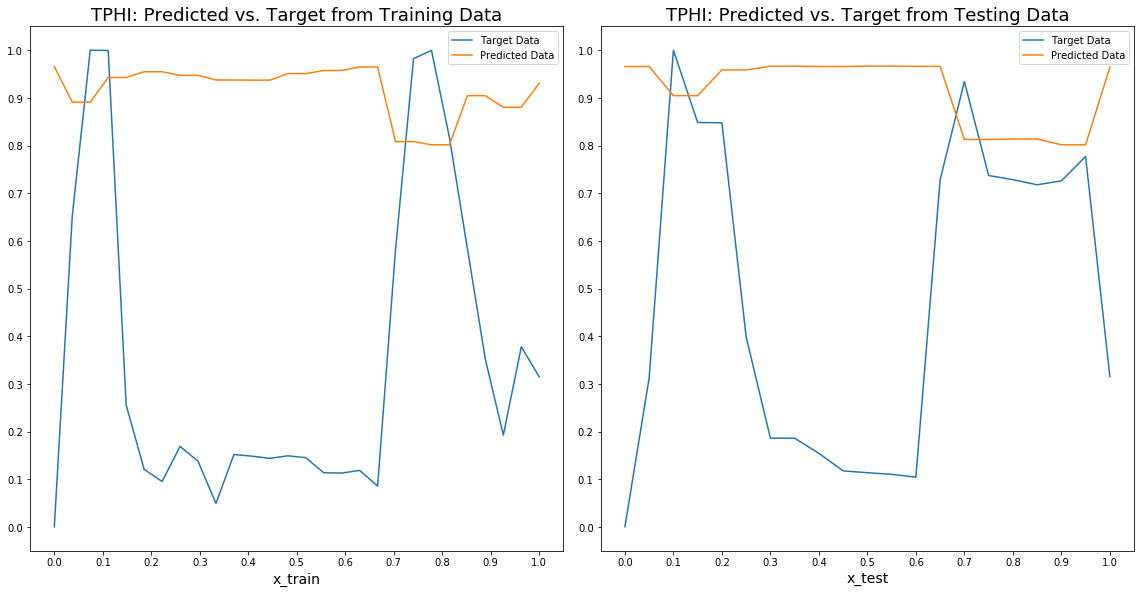

Begin MCMC Sample Iteration


<Figure size 432x288 with 0 Axes>

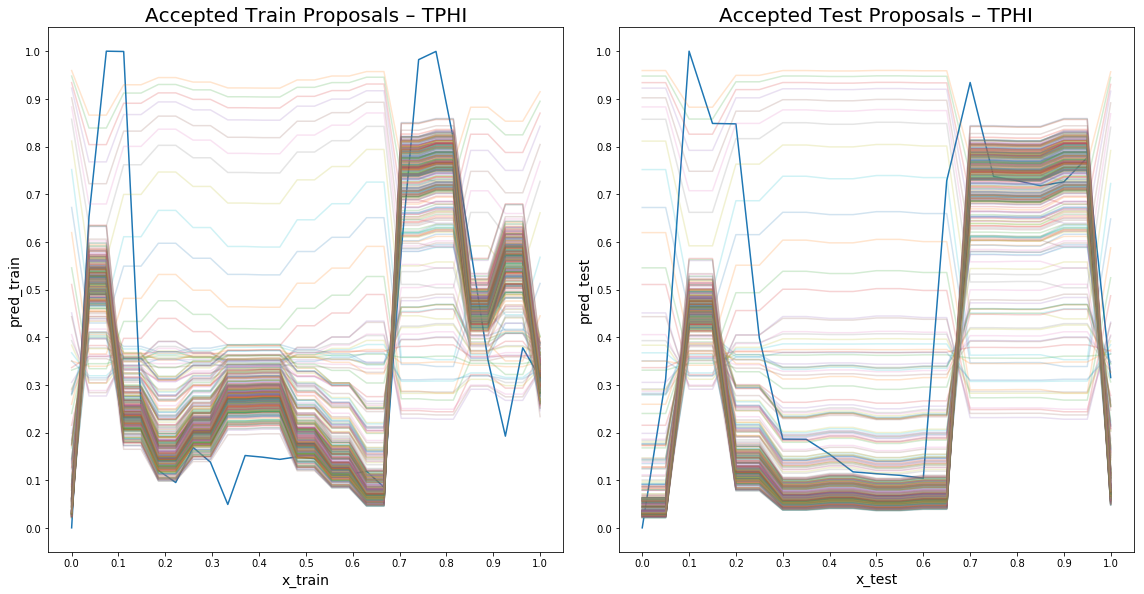


399  langevin_count
Sucessfully sampled
0.10744  minutes to evaluate 400 samples
6.44632 seconds to evaluate 400 samples


<Figure size 432x288 with 0 Axes>

In [56]:
###################################################################################################################
inputs = 1                                              # The number of nodes/neurons for the inputs layer
hidden = 11                                              # The number of nodes/neurons for the hidden layer
output = 1                                              # The number of nodes/neurons for the output layer
###################################################################################################################
rdn_hid_update = False
if rdn_hid_update == True:
    topo = TOPOLOGY(inputs, hidden, output)             # If randomly updating number of hidden neurons
    inputs, hidden, output = topo.randomly_updating_number_of_hidden_neurons()
###################################################################################################################
w_limit = 0.026874
tau_limit = 0.0515625
l_prob = 2.1625
learn_rate = 0.040625

# w_limit = 0.0265615
# tau_limit = 0.05
# l_prob = 1.725
# learn_rate = 0.075

use_langevin_gradients = True
plot = True
numSamples = 400
###################################################################################################################
topology = [inputs, hidden, output]
print("Topology of Neural Network:        ", topology)
random.seed(time.time())                                # Generating randomness using the time it takes to run
###################################################################################################################
timer = time.time()
###################################################################################################################
mcmc = MCMC(use_langevin_gradients, l_prob, learn_rate, numSamples, traindata01, testdata01, topology)  # Declare class
pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test = mcmc.sampler(w_limit, tau_limit, path_db, plot, rdn_hid_update)
print('Sucessfully sampled')
burnin = 0.85 * numSamples                               # Use post burn in samples
pos_w = pos_w[int(burnin):, ]
pos_tau = pos_tau[int(burnin):, ]
fx_train = fx_train[int(burnin):, ]
fx_test = fx_test[int(burnin):, ]
###################################################################################################################
timer2 = time.time()
###################################################################################################################
timetotal_min = (timer2 - timer) / 60
print(str(round(timetotal_min, 5)) + '  minutes to evaluate ' + str(numSamples) + ' samples')
timetotal_sec = (timer2 - timer)
print(str(round(timetotal_sec, 5)) + ' seconds to evaluate ' + str(numSamples) + ' samples')
###################################################################################################################

#### Setting the y-axis data
* ytestdata and ytraindata are the associated training and testing data for the target feature (normalized NPHI)

#### Assigning R$^2$, Explained Varaince, RMSE, MAPE, predicted mean, P10, and P90
* This block of code takes the 200 columns (since we have 200 samples), and condenses it down to one column with the associated number of rows for the given training and testing datasets

* To condense the number of columns, the code block here takes the mean of each row (over 200 columns) to get the predictive mean. Then it does the same, but takes the P10, and does the same but takes the P90

* RMSE and R$^2$ were iterated over within the BNN, so no need to average or take the P10 and P90 of those, rather a plot is soon to follow to show how the MCMC samples from the probability distribution, and whether it gets stuck within a local low probability distribution, or is sampling from the target distribution

#### Output R$^2$, Explained Varaince, RMSE, and MAPE curves throughout the MCMC sampling (0 to 200 sample iterations) and the BNN model fit of the target feature
* As stated above, plotting the R$^2$, Explained Varaince, RMSE, and MAPE over each sample iteration within the BNN to show how the MCMC samples from the given probability distribution. The red curve is the training data, and the green curve is the testing
    
* At times, the testing data model perfromance beats that of the training data, which is a result of whether or not the max and min values of the original dataset are within the training or testing datasets since the model has trouble reaching those peak values  
  
* Print statements follow that show the average R$^2$, Explained Varaince, RMSE, and MAPE for all 200 sample iterations, and for the training and testing datasets. Their associated STD/uncertainity is shown next to each model perfromance metric

* Following that are more print statements that show the post burnin chain (i.e., posterior chain) model performance metrics. So these are evaluated over 120 and 200 sample iterations. The R$^2$, Explained Varaince, RMSE, MAPE, and their associated uncertainity are again shown

* The number of accepted proposals over all proposals are also shown

* Lastly, a visualization plot is shown of the BNN model fit to the actual normalized NPHI curve, which is in blue. The left figure is the training dataset and the right figure is the testing dataset
    * In orange is the predicted mean fit
    
    * In green is the predicted P10 fit
    
    * In red is the predicted P90 fit
    
    * And the yellow fill is the fill in region between the predicted P10 and P90

* Can see that, overall, the BNN model does a very good job at fitting nonlinear phenomenon that comes with a high degree of certainty (at least with this given problem), and high explained variance with relatively low RMSE given this training and testing datasets derived from this workflow's sampling approach

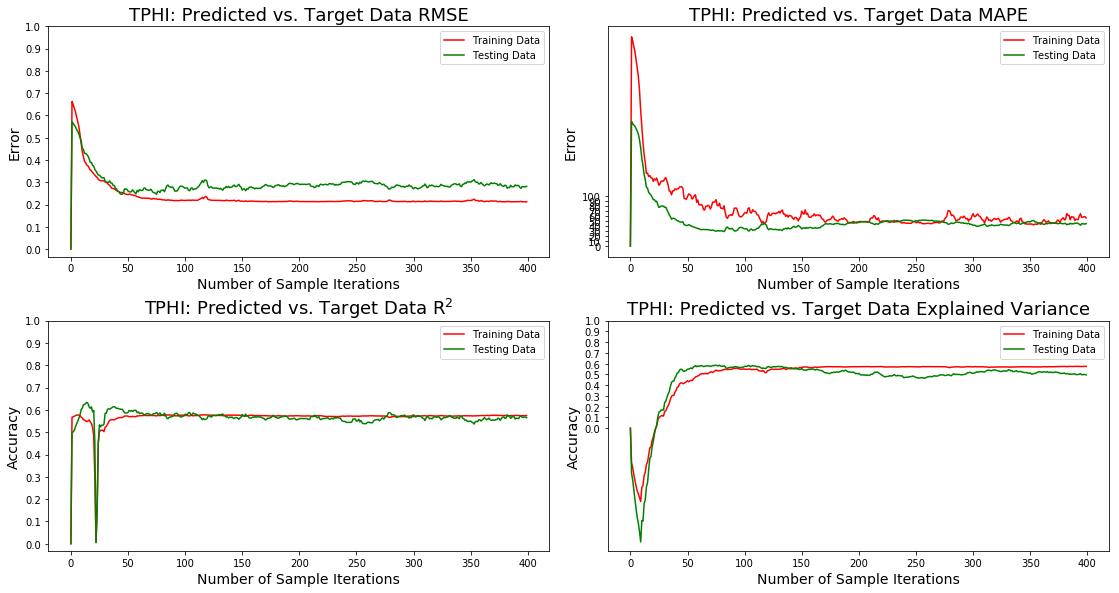

R^2      AVG for training data with NO post burn in samples:     56.6%   –––> STD:   4.902%
R^2      AVG for testing  data with NO post burn in samples:     56.395%   –––> STD:   4.876%
Exp_Var  AVG for training data with NO post burn in samples:     48.762%   –––> STD:   22.974%
Exp_Var  AVG for testing  data with NO post burn in samples:     45.553%   –––> STD:   26.235%
RMSE     AVG for training data with NO post burn in samples:     23.399%    –––> STD:   6.388%
RMSE     AVG for testing  data with NO post burn in samples:     29.245%    –––> STD:   4.743%
MAPE     AVG for training data with NO post burn in samples:     71.714%   –––> STD:   52.27%
MAPE     AVG for testing  data with NO post burn in samples:     50.541%    –––> STD:   32.193%

Post burn data lies between 340 & 400 sample iterations

R^2      AVG for training data with post burn in samples:        57.428%   –––> STD:   0.094%
R^2      AVG for testing  data with post burn in samples:        55.967%   –––> STD:   0.861

<Figure size 432x288 with 0 Axes>

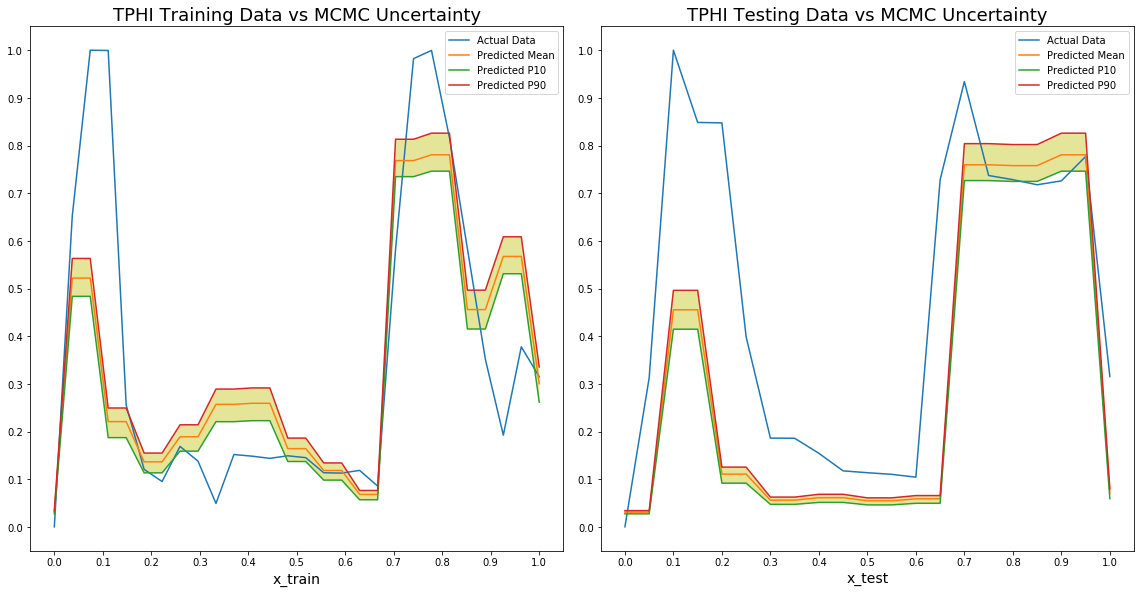

<Figure size 432x288 with 0 Axes>

In [57]:
###################################################################################################################
ytestdata = testdata01[:, inputs]                     # Inputs == 1
ytraindata = traindata01[:, inputs]                   # Inputs == 1
###################################################################################################################
hid1 = pd.DataFrame(hidden_update[:, :])
indx = hid1.index.tolist()
colmn = hid1[0].values
hid2 = pd.DataFrame([indx, colmn])
hid2 = np.asarray(hid2.to_numpy())
###################################################################################################################
hid01 = pd.DataFrame(hidden_update_acc[:, :])
indx1 = hid01.index.tolist()
colmn1 = hid01[0].values
hid02 = pd.DataFrame([indx1, colmn1])
hid02 = np.asarray(hid02.to_numpy())
###################################################################################################################
data_r2value_train = pd.DataFrame(r2value_train, columns=["R$^2$ Train"]).round(3)
data_r2value_test = pd.DataFrame(r2value_test, columns=["R$^2$ Test"]).round(3)
data_r2value = pd.concat([data_r2value_train, data_r2value_test], axis=1)
###################################################################################################################
data_exp_var_train = pd.DataFrame(var_exp_train, columns=["Exp_Var Train"]).round(3)
data_exp_var_test = pd.DataFrame(var_exp_test, columns=["Exp_Var Test"]).round(3)
data_exp_var = pd.concat([data_exp_var_train, data_exp_var_test], axis=1)
###################################################################################################################
data_rmse_train = pd.DataFrame(rmse_train, columns=["RMSE Train"]).round(3)
data_rmse_test = pd.DataFrame(rmse_test, columns=["RMSE Test"]).round(3)
data_rmse = pd.concat([data_rmse_train, data_rmse_test], axis=1)
###################################################################################################################
data_mape_train = pd.DataFrame(MAPE_train, columns=["MAPE Train"]).round(3)
data_mape_test = pd.DataFrame(MAPE_test, columns=["MAPE Test"]).round(3)
data_mape = pd.concat([data_mape_train, data_mape_test], axis=1)
###################################################################################################################
rmse_tr_data = round(float(data_rmse_train.mean(axis=0) * 100), 3)
rmsetr_std_data = round(float(data_rmse_train.std(axis=0) * 100), 3)
rmse_tes_data = round(float(data_rmse_test.mean(axis=0) * 100), 3)
rmsetest_std_data = round(float(data_rmse_test.std(axis=0) * 100), 3)
###################################################################################################################
mape_tr_data = round(float(data_mape_train.mean(axis=0)), 3)
mapetr_std_data = round(float(data_mape_train.std(axis=0)), 3)
mape_tes_data = round(float(data_mape_test.mean(axis=0)), 3)
mapetest_std_data = round(float(data_mape_test.std(axis=0)), 3)
###################################################################################################################
r2value_tr_data = round(float(data_r2value_train.mean(axis=0) * 100), 3)
r2value_tr_std_data = round(float(data_r2value_train.std(axis=0) * 100), 3)
r2value_tes_data = round(float(data_r2value_test.mean(axis=0) * 100), 3)
r2value_tes_std_data = round(float(data_r2value_test.std(axis=0) * 100), 3)
###################################################################################################################
var_exp_tr_data = round(float(data_exp_var_train.mean(axis=0) * 100), 3)
var_exp_tr_std_data = round(float(data_exp_var_train.std(axis=0) * 100), 3)
var_exp_tes_data = round(float(data_exp_var_test.mean(axis=0) * 100), 3)
var_exp_tes_std_data = round(float(data_exp_var_test.std(axis=0) * 100), 3)
###################################################################################################################
fx_mu = fx_test.mean(axis=0)                            # Mean value for the predicted testing data for output
fx_high = np.percentile(fx_test, 90, axis=0)            # P90 value for the predicted testing data for output
fx_low = np.percentile(fx_test, 10, axis=0)             # P10 value for the predicted testing data for output
###################################################################################################################
fx_mu_tr = fx_train.mean(axis=0)                        # Mean value for the predicted training data for output
fx_high_tr = np.percentile(fx_train, 90, axis=0)        # P90 value for the predicted training data for output
fx_low_tr = np.percentile(fx_train, 10, axis=0)         # P10 value for the predicted training data for output
###################################################################################################################
pos_w_mean = pos_w.mean(axis=0)                         # Mean value for the predicted posterior weights
###################################################################################################################
rmse_tr = round(np.mean(rmse_train[int(burnin):]) * 100, 3)
rmsetr_std = round(np.std(rmse_train[int(burnin):]) * 100, 3)
rmse_tes = round(np.mean(rmse_test[int(burnin):]) * 100, 3)
rmsetest_std = round(np.std(rmse_test[int(burnin):]) * 100, 3)
###################################################################################################################
mape_tr = round(np.mean(MAPE_train[int(burnin):]), 3)
mapetr_std = round(np.std(MAPE_train[int(burnin):]), 3)
mape_tes = round(np.mean(MAPE_test[int(burnin):]), 3)
mapetest_std = round(np.std(MAPE_test[int(burnin):]), 3)
###################################################################################################################
r2value_tr = round(np.mean(r2value_train[int(burnin):]) * 100, 3)
r2value_tr_std = round(np.std(r2value_train[int(burnin):]) * 100, 3)
r2value_tes = round(np.mean(r2value_test[int(burnin):]) * 100, 3)
r2value_tes_std = round(np.std(r2value_test[int(burnin):]) * 100, 3)
###################################################################################################################
var_exp_tr = round(np.mean(var_exp_train[int(burnin):]) * 100, 3)
var_exp_tr_std = round(np.std(var_exp_train[int(burnin):]) * 100, 3)
var_exp_tes = round(np.mean(var_exp_test[int(burnin):]) * 100, 3)
var_exp_tes_std = round(np.std(var_exp_test[int(burnin):]) * 100, 3)
###################################################################################################################
###################################################################################################################
###################################################################################################################
fig12 = plt.figure(figsize=(16, 9))
###################################################################################################################
ax12 = fig12.add_subplot(2, 2, 1)
ax12.plot(rmse_train, color="red", label="Training Data")
ax12.plot(rmse_test, color="green", label="Testing Data")
ax12.legend()
ax12.set_title('TPHI: Predicted vs. Target Data RMSE', size=18)
ax12.set_xlabel('Number of Sample Iterations', size=14)
ax12.set_ylabel('Error', size=14)
ax12.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
###################################################################################################################
ax22 = fig12.add_subplot(2, 2, 2)
ax22.plot(MAPE_train, color="red", label="Training Data")
ax22.plot(MAPE_test, color="green", label="Testing Data")
ax22.legend()
ax22.set_title('TPHI: Predicted vs. Target Data MAPE', size=18)
ax22.set_xlabel('Number of Sample Iterations', size=14)
ax22.set_ylabel('Error', size=14)
ax22.yaxis.set_ticks(np.arange(0.0, 110.0, 10.0))
###################################################################################################################
ax32 = fig12.add_subplot(2, 2, 3)
ax32.plot(r2value_train, color="red", label="Training Data")
ax32.plot(r2value_test, color="green", label="Testing Data")
ax32.legend()
ax32.set_title('TPHI: Predicted vs. Target Data R$^2$', size=18)
ax32.set_xlabel('Number of Sample Iterations', size=14)
ax32.set_ylabel('Accuracy', size=14)
ax32.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
###################################################################################################################
ax42 = fig12.add_subplot(2, 2, 4)
ax42.plot(var_exp_train, color="red", label="Training Data")
ax42.plot(var_exp_test, color="green", label="Testing Data")
ax42.legend()
ax42.set_title('TPHI: Predicted vs. Target Data Explained Variance', size=18)
ax42.set_xlabel('Number of Sample Iterations', size=14)
ax42.set_ylabel('Accuracy', size=14)
ax42.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
###################################################################################################################
fig12.tight_layout()
fig12.subplots_adjust(top=0.88)
plt.show()
plt.clf()
###################################################################################################################
print("R^2      AVG for training data with NO post burn in samples:     " + str(r2value_tr_data) + "%   –––> STD:   " + str(r2value_tr_std_data) + "%")
print("R^2      AVG for testing  data with NO post burn in samples:     " + str(r2value_tes_data) + "%   –––> STD:   " + str(r2value_tes_std_data) + "%")
print("Exp_Var  AVG for training data with NO post burn in samples:     " + str(var_exp_tr_data) + "%   –––> STD:   " + str(var_exp_tr_std_data) + "%")
print("Exp_Var  AVG for testing  data with NO post burn in samples:     " + str(var_exp_tes_data) + "%   –––> STD:   " + str(var_exp_tes_std_data) + "%")
print("RMSE     AVG for training data with NO post burn in samples:     " + str(rmse_tr_data) + "%    –––> STD:   " + str(rmsetr_std_data) + "%")
print("RMSE     AVG for testing  data with NO post burn in samples:     " + str(rmse_tes_data) + "%    –––> STD:   " + str(rmsetest_std_data) + "%")
print("MAPE     AVG for training data with NO post burn in samples:     " + str(mape_tr_data) + "%   –––> STD:   " + str(mapetr_std_data) + "%")
print("MAPE     AVG for testing  data with NO post burn in samples:     " + str(mape_tes_data) + "%    –––> STD:   " + str(mapetest_std_data) + "%")
###################################################################################################################
print()
print("Post burn data lies between " + str(int(burnin)) + ' & ' + str(int(numSamples)) + " sample iterations")
print()
###################################################################################################################
print("R^2      AVG for training data with post burn in samples:        " + str(r2value_tr) + "%   –––> STD:   " + str(r2value_tr_std) + "%")
print("R^2      AVG for testing  data with post burn in samples:        " + str(r2value_tes) + "%   –––> STD:   " + str(r2value_tes_std) + "%")
print("Exp_Var  AVG for training data with post burn in samples:        " + str(var_exp_tr) + "%   –––> STD:   " + str(var_exp_tr_std) + "%")
print("Exp_Var  AVG for testing  data with post burn in samples:        " + str(var_exp_tes) + "%   –––> STD:   " + str(var_exp_tes_std) + "%")
print("RMSE     AVG for training data with post burn in samples:        " + str(rmse_tr) + "%    –––> STD:   " + str(rmsetr_std) + "%")
print("RMSE     AVG for testing  data with post burn in samples:        " + str(rmse_tes) + "%    –––> STD:   " + str(rmsetest_std) + "%")
print("MAPE     AVG for training data with post burn in samples:        " + str(mape_tr) + "%   –––> STD:   " + str(mapetr_std) + "%")
print("MAPE     AVG for testing  data with post burn in samples:        " + str(mape_tes) + "%   –––> STD:   " + str(mapetest_std) + "%")
print("Acceptance Ratio of all data (i.e., NO post burn in samples):    " + str(accept_ratio) + "%")
print()
print("Last r2value_train value:                                        " + str(round((r2value_train[-1]) * 100, 3)) + "%")
print("Last r2value_test value:                                         " + str(round((r2value_test[-1]) * 100, 3)) + "%")
print("Last var_exp_train value:                                        " + str(round((var_exp_train[-1]) * 100, 3)) + "%")
print("Last var_exp_test value:                                         " + str(round((var_exp_test[-1]) * 100, 3)) + "%")
print("Last rmse_train value:                                           " + str(round((rmse_train[-1]) * 100, 3)) + "%")
print("Last rmse_test value:                                            " + str(round((rmse_test[-1]) * 100, 3)) + "%")
print("Last MAPE_train value:                                           " + str(round((MAPE_train[-1]), 3)) + "%")
print("Last MAPE_test value:                                            " + str(round((MAPE_test[-1]), 3)) + "%")
###################################################################################################################
fig = plt.figure(figsize=(16, 9))
###################################################################################################################
ax01 = fig.add_subplot(1, 2, 1)
ax01.plot(x_train, ytraindata, label='Actual Data')
ax01.plot(x_train, fx_mu_tr, label='Predicted Mean')
ax01.plot(x_train, fx_low_tr, label='Predicted P10')
ax01.plot(x_train, fx_high_tr, label='Predicted P90')
ax01.fill_between(x_train, fx_low_tr, fx_high_tr, facecolor='y', alpha=0.4)
ax01.legend(loc='upper right')
ax01.set_title("TPHI Training Data vs MCMC Uncertainty", size=18)
ax01.set_xlabel('x_train', size=14)
ax01.xaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
ax01.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
###################################################################################################################
ax02 = fig.add_subplot(1, 2, 2)
ax02.plot(x_test, ytestdata, label='Actual Data')
ax02.plot(x_test, fx_mu, label='Predicted Mean')
ax02.plot(x_test, fx_low, label='Predicted P10')
ax02.plot(x_test, fx_high, label='Predicted P90')
ax02.fill_between(x_test, fx_low, fx_high, facecolor='y', alpha=0.4)
ax02.legend(loc='upper right')
ax02.set_title("TPHI Testing Data vs MCMC Uncertainty", size=18)
ax02.set_xlabel('x_test', size=14)
ax02.xaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
ax02.yaxis.set_ticks(np.arange(0.0, 1.1, 0.1))
###################################################################################################################
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()
plt.clf()
###################################################################################################################

#### Code block below shows the ideal number of hidden neurons at each iteration and accepted proposal when evaluating a given sample within the BNN
This method is used in the beginning to find the optimal number of hidden neurons to reach convergence faster (so better performance metrics) for a given problem

Once the optimal number of hidden neurons is found, then this block of code below can be ignored, and its associated code within the BNN can be commented out

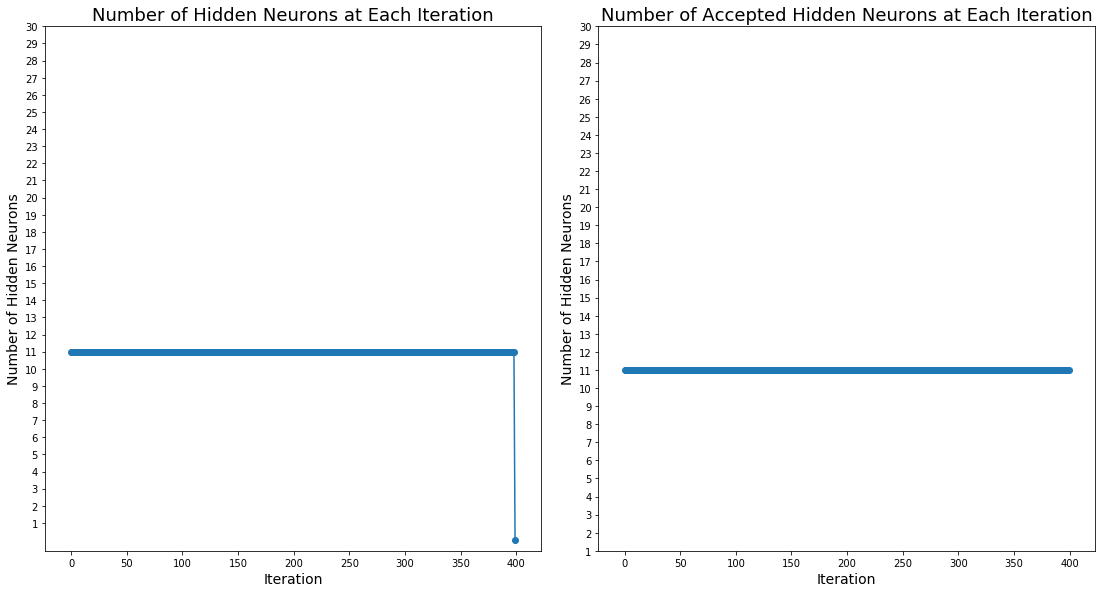

<Figure size 432x288 with 0 Axes>

In [58]:
###################################################################################################################
fig22 = plt.figure(figsize=(16, 9))
###################################################################################################################
x = hid2[0]
y = hid2[1]
x_acc = hid02[0]
y_acc = hid02[1]
###################################################################################################################
ax_1 = fig22.add_subplot(1, 2, 1)
ax_1.plot(x, y, zorder=2)
ax_1.scatter(x, y, zorder=1)
ax_1.set_title('Number of Hidden Neurons at Each Iteration', size=18)
ax_1.set_xlabel('Iteration', size=14)
ax_1.set_ylabel('Number of Hidden Neurons', size=14)
ax_1.yaxis.set_ticks(np.arange(1, 31, 1))
###################################################################################################################
ax_2 = fig22.add_subplot(1, 2, 2)
ax_2.plot(x_acc, y_acc, zorder=2)
ax_2.scatter(x_acc, y_acc, zorder=1)
ax_2.set_title('Number of Accepted Hidden Neurons at Each Iteration', size=18)
ax_2.set_xlabel('Iteration', size=14)
ax_2.set_ylabel('Number of Hidden Neurons', size=14)
ax_2.yaxis.set_ticks(np.arange(1, 31, 1))
###################################################################################################################
fig22.tight_layout()
fig22.subplots_adjust(top=0.88)
plt.savefig(path_db + '/hidden_neurons.png')
plt.show()
plt.clf()
###################################################################################################################

#### Boxplot of the posterior W, which is composed of the weights and biases
How does one interpret a boxplot? Look into this later and then fill in the details here regarding the results for this problem

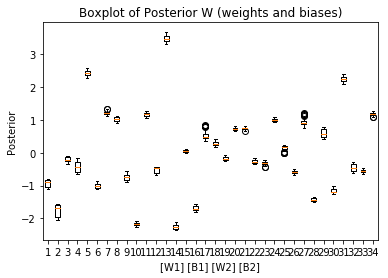

<Figure size 432x288 with 0 Axes>

In [59]:
###################################################################################################################
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(1, 1, 1)
ax.boxplot(pos_w)
ax.set_xlabel('[W1] [B1] [W2] [B2]')
ax.set_ylabel('Posterior')
plt.title("Boxplot of Posterior W (weights and biases)")
plt.savefig(path_db + '/w_pos.png')
plt.show()
plt.clf()
###################################################################################################################

### Part 5: Employing the trained BNN with optimal hyperparameters to predict N$_p$$_h$$_i$ across seismic volume

First, create the structered well and seismic dataset to be used

Second, smooth the well data to have same sampling rate and or resolution as seismic

Make sure to include X, Y, time for both well and seismic data into the already constructed data

Think about how to set up the horizon data and how to feed that into the BNN


Since you are just have the BNN predict petrophysical data across seismic traces, where the BNN hyperparameters have been tuned given a particualr train/test dataset set-up, am I just to feed to 'testing data' and output just 'testing data'? Because I am not training the model given the well and seismic data, rather I am letting the BNN proppagte/predict Nphi across the seismic volume given the optimal hyperparameters determined when trained and tested the BNN on well log data and a given test/train set-up

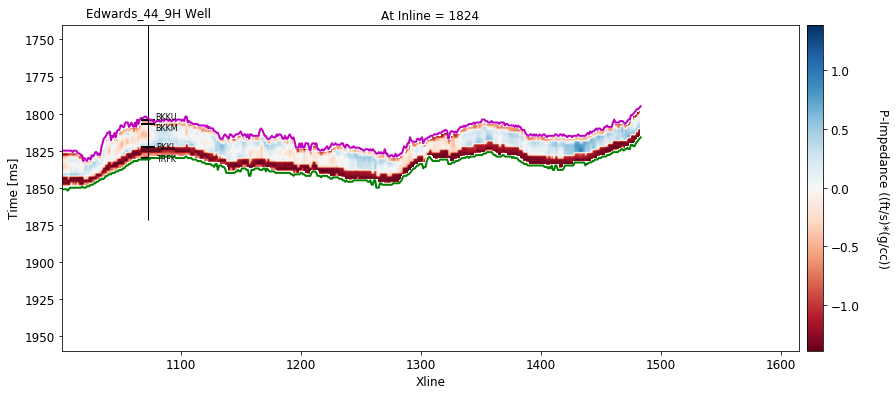

In [60]:
def seismic_inline(i, plot_bool):
    ###################################################################################################################
    df_horizons_updated_bnn = df_horizons_updated.iloc[:, [0, 1, 4, 5]]
    df_horizons_updated_bnn = df_horizons_updated_bnn.loc[df_horizons_updated_bnn['Inline'].values == i]
    np_bk_horizons_bnn = df_horizons_updated_bnn['Bakken_Horizon_Floor_Time_ms'].values
    np_tf_horizons_bnn = df_horizons_updated_bnn['ThreeFork_Horizon_Ceiling_Time_ms'].values
    map_horiz_bak_inline = seismic_data[:, inl_array.tolist().index(i), :]        
    np_bk_horizons_bnn_plt = np_bk_horizons_bnn[map_horiz_bak_inline[0] != 0]
    np_tf_horizons_bnn_plt = np_tf_horizons_bnn[map_horiz_bak_inline[0] != 0]
    xl_array_new = xl_array; xl_array_new = xl_array_new[map_horiz_bak_inline[0] != 0]
    ###################################################################################################################
    np_inline_seismic = np.full((615, 1), i)
    np_inline_seismic = np.array(np_inline_seismic).transpose()[0]
    np_xline_seismic = np.arange(1001, 1616, 1)
    np_seismic_inline_xline = np.vstack([np_inline_seismic, np_xline_seismic]).transpose()
    df_seismic_inline_xline = pd.DataFrame(np_seismic_inline_xline, columns=['Inline', 'Xline'])
    ###################################################################################################################
    z_new1 = np.array(np.arange(1740.0, 1960.0 + 1.0, 1.0), dtype=np.int64)
    df_seismic_time = pd.DataFrame(z_new1, columns=['Time_ms'])
    ###################################################################################################################
    np_zp_inline = seismic_data[:, inl_array.tolist().index(i), :]
    np_zp_inline = np_zp_inline[np.arange(z_new1.min()-1600, z_new1.max()+1-1600, 1), :].transpose()
    df_zp_inline = pd.DataFrame(np_zp_inline)
    df_zp_inline = df_zp_inline.transpose()
    ###################################################################################################################
    # Standardized the data between -1.3875 and 1.3875
    scaler = preprocessing.MinMaxScaler(feature_range=(-1.3875, 1.3875))
    scaler.fit(df_zp_inline)
    df_zp_inline = scaler.transform(df_zp_inline)
    df_zp_inline = pd.DataFrame(df_zp_inline)
    np_zp_inline = df_zp_inline.values
    np_seismic_time = df_seismic_time.values
    ###################################################################################################################
    for column in range(0, np_xline_seismic.size):
        for index in range(0, 221):
            bk_time_at_given_xline = np_bk_horizons_bnn[column]
            tf_time_at_given_xline = np_tf_horizons_bnn[column]

            if (bk_time_at_given_xline == 0) or (tf_time_at_given_xline == 0):
                np_zp_inline[index, column] = np.nan

            elif np_seismic_time[index] < bk_time_at_given_xline:
                np_zp_inline[index, column] = np.nan

            elif np_seismic_time[index] > tf_time_at_given_xline:
                np_zp_inline[index, column] = np.nan
    ###################################################################################################################
    df_BNN_Zp_frame = pd.DataFrame(np_zp_inline)
    np_BNN_Zp_frame = df_BNN_Zp_frame.values
    if plot_bool == True:
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(1, 1, 1)
        xleft, xrite = xl_array.min(), xl_array.max()
        twt_min = z_new1.min(); twt_max = z_new1.max()
        ext = [xleft, xrite, twt_max, twt_min]
        amp = ax.imshow(np_BNN_Zp_frame, cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0)
        cbar.ax.set_ylabel(cb_label, rotation=270, labelpad=30, size=12)
        cbar.ax.tick_params(labelsize=12)
        plt.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=2)
        plt.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=2)
        plt.title('At Inline = %d' % i, size=12)
        plt.ylabel("Time [ms]", size=12)
        plt.xlabel("Xline", size=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=12)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=2)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=8)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=2)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=8)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=2)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=8)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=2)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=8)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=12)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=2)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=8)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=2)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=8)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=2)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=8)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=2)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=8)

    return np_BNN_Zp_frame, z_new1

###################################################################################################################
np_BNN_Zp_frame, z_new1 = seismic_inline(1824, True)
###################################################################################################################

y_target01.shape: (21,)
df_seismic_lucy_tphi_bnn.shape (21, 3)
target_compress.shape (135915,)


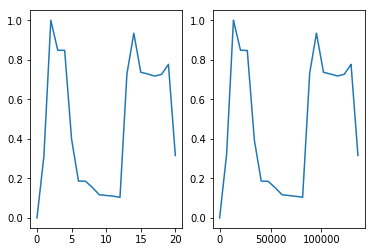

In [61]:
###################################################################################################################
df_seismic_lucy_tphi = df_lucy_all_new
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('X', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('Y', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('P_Velo_from_Well', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('Zp_from_Seismic', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('DPOR_Low_Res_from_Well', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('DPOR_High_Res_from_Well', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('NPHI_Low_Res_from_Well', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('NPHI_High_Res_from_Well', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('TPHI_High_Res_from_Well', axis=1)
df_seismic_lucy_tphi = df_seismic_lucy_tphi.drop('RHOZ', axis=1)
###################################################################################################################
df_seismic_lucy_toc = df_seismic_lucy_tphi['TOC'].values
np_seismic_lucy_tphi = df_seismic_lucy_tphi.values
df_seismic_lucy_tphi_bnn = pd.DataFrame(np_seismic_lucy_tphi, columns=['Time_ms', 'Tphi', 'TOC'])
###################################################################################################################
y_target01 = df_seismic_lucy_tphi_bnn['Tphi'].values       # Lucy well as is
###################################################################################################################
print('y_target01.shape:', y_target01.shape)
y_target = y_target01
###################################################################################################################
# Keep target feature between 0 and 1 since using a sigmoid activation function
y_target_norm = (y_target - y_target.min()) / (y_target.max() - y_target.min())
df_seismic_lucy_tphi_bnn['Tphi_Norm'] = (y_target01 - y_target01.min()) / (y_target01.max() - y_target01.min())
df_seismic_lucy_tphi_bnn = df_seismic_lucy_tphi_bnn.drop('Tphi', axis=1)
df_seismic_lucy_tphi_bnn['TOC_Norm'] = (df_seismic_lucy_toc - df_seismic_lucy_toc.min()) / (df_seismic_lucy_toc.max() - df_seismic_lucy_toc.min())
df_seismic_lucy_tphi_bnn = df_seismic_lucy_tphi_bnn.drop('TOC', axis=1)
print('df_seismic_lucy_tphi_bnn.shape', df_seismic_lucy_tphi_bnn.shape)
###################################################################################################################
# df_seismic_lucy_tphi_bnn.head()
###################################################################################################################
np_BNN_Zp_frame_test = np_BNN_Zp_frame.ravel()
###################################################################################################################
plt.subplot(1, 2, 1)
plt.plot(y_target_norm)
###################################################################################################################
plt.subplot(1, 2, 2)
target_interp1 = interp.interp1d(np.arange(y_target_norm.size), y_target_norm)
target_compress1 = target_interp1(np.linspace(0, y_target_norm.size - 1, np_BNN_Zp_frame_test.size))
print('target_compress.shape', target_compress1.shape)
plt.plot(target_compress1)
###################################################################################################################

In [62]:
###################################################################################################################
timer03 = time.time()
start_i = 2105; start_ii = start_i  # 1001
end_i = 2110;   end_ii = end_i      # 2277
diff_i = end_i - start_i
i = start_i
j = 0
###################################################################################################################
np_BNN_Zp_frame_dum, z_new1_dum = seismic_inline(2200, False)
###################################################################################################################
fx_train_mean_list_array2 = np.zeros((z_new1_dum.size, 615, diff_i+1))
fx_train_p10_list_array2  = np.zeros((z_new1_dum.size, 615, diff_i+1))
fx_train_p90_list_array2  = np.zeros((z_new1_dum.size, 615, diff_i+1))
###################################################################################################################
np_pred_mean_new1 = np.zeros((z_new1_dum.size, 615, diff_i+1))
np_pred_p10_new1 = np.zeros((z_new1_dum.size, 615, diff_i+1))
np_pred_p90_new1 = np.zeros((z_new1_dum.size, 615, diff_i+1))
###################################################################################################################
with segyio.open(filename, iline=189, xline=193) as segyfile:
    ###############################################################################################################
    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    ###############################################################################################################  
    while i <= end_i:
        ###################################################################################################################
        numSamples = 400
        burnin = 0.85 * numSamples
        np_BNN_Zp_frame, z_new1 = seismic_inline(i, False)
        ###############################################################################################################   
        def pad(A, length):
            arr = np.zeros(length)
            arr[:len(A)] = A
            return arr
        ###################################################################################################################
        fx_train_mean_list_array = np.zeros((z_new1.size, 615))
        fx_train_p10_list_array  = np.zeros((z_new1.size, 615))
        fx_train_p90_list_array  = np.zeros((z_new1.size, 615))
        ###################################################################################################################
        for column in range(0, 615):
            data_for_given_xline = np_BNN_Zp_frame[:, column]
            data_for_given_xline = data_for_given_xline[~np.isnan(data_for_given_xline)]
            if len(data_for_given_xline) != 0:

                random.seed(time.time())
                zp_pred_data = data_for_given_xline
                target_interp = interp.interp1d(np.arange(y_target_norm.size), y_target_norm)
                target_compress = target_interp(np.linspace(0, y_target_norm.size - 1, zp_pred_data.size))
                np_pred_data_with_tphi = np.vstack([zp_pred_data, target_compress]).transpose()

                mcmc = MCMC(use_langevin_gradients, l_prob, learn_rate, numSamples, np_pred_data_with_tphi, np_pred_data_with_tphi, topology)
                pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test = mcmc.sampler(w_limit, tau_limit, path_db, plot=False, rdn_hid_update=False)

                fx_mu_train = fx_train[int(burnin):, ].mean(axis=0)
                fx_p10_train = np.percentile(fx_train[int(burnin):, ], 10, axis=0)
                fx_p90_train = np.percentile(fx_train[int(burnin):, ], 90, axis=0)

                fx_train_mean_list_array = np.insert(fx_train_mean_list_array, column, pad(fx_mu_train, z_new1.size), axis=1)
                fx_train_p10_list_array  = np.insert(fx_train_p10_list_array, column, pad(fx_p10_train, z_new1.size), axis=1)
                fx_train_p90_list_array  = np.insert(fx_train_p90_list_array, column, pad(fx_p90_train, z_new1.size), axis=1)             
        ###################################################################################################################
        fx_train_mean_list_array1 = np.delete(fx_train_mean_list_array, np.s_[615:], axis=1)
        fx_train_p10_list_array1  = np.delete(fx_train_p10_list_array, np.s_[615:], axis=1)
        fx_train_p90_list_array1  = np.delete(fx_train_p90_list_array, np.s_[615:], axis=1)
        fx_train_mean_list_array2[:, :, j] = fx_train_mean_list_array1
        fx_train_p10_list_array2[:, :, j]  = fx_train_p10_list_array1
        fx_train_p90_list_array2[:, :, j]  = fx_train_p90_list_array1
        ###################################################################################################################
        for column in range(0, 615):
            for index in range(0, z_new1.size):
                if fx_train_mean_list_array2[index, column, j] == int(0):
                    fx_train_mean_list_array2[index, column, j] = np.nan
                if fx_train_p10_list_array2[index, column, j] == int(0):
                    fx_train_p10_list_array2[index, column, j] = np.nan
                if fx_train_p90_list_array2[index, column, j] == int(0):
                    fx_train_p90_list_array2[index, column, j] = np.nan
        ###################################################################################################################
        np_pred_mean_dummy = fx_train_mean_list_array2
        np_pred_p10_dummy = fx_train_p10_list_array2
        np_pred_p90_dummy = fx_train_p90_list_array2
        ###################################################################################################################
        col = 0
        np_BNN_Zp_frame_loop = np_BNN_Zp_frame
        while col < 615:
            idx = 0
            while idx < z_new1.size:
                np_BNN_Zp_dummy1 = np_BNN_Zp_frame_loop[idx, col]
                null_check = np_BNN_Zp_dummy1[np.isnan(np_BNN_Zp_dummy1)]
                if len(null_check) == 0:
                    pred_orig_idx = idx + 1
                    for idx in range(pred_orig_idx, z_new1.size):
                        np_pred_mean_new1[idx, col, j] = np_pred_mean_dummy[idx - pred_orig_idx, col, j]
                        np_pred_p10_new1[idx, col, j] = np_pred_p10_dummy[idx - pred_orig_idx, col, j]
                        np_pred_p90_new1[idx, col, j] = np_pred_p90_dummy[idx - pred_orig_idx, col, j]
                else:
                    np_pred_mean_new1[idx, col, j] = np.nan
                    np_pred_p10_new1[idx, col, j] = np.nan
                    np_pred_p90_new1[idx, col, j] = np.nan
                idx += 1
            col += 1
        ###################################################################################################################
        pred_mean_corrected_vals = np_pred_mean_new1
        pred_p10_corrected_vals = np_pred_p10_new1
        pred_p90_corrected_vals = np_pred_p90_new1
        ###################################################################################################################
        # print(str(start_i + j) + ' inline with pred_mean_corrected_vals shape of ' + str(pred_mean_corrected_vals.shape))
        i += 1; j += 1
        ###################################################################################################################
###################################################################################################################
timer04 = time.time()
timetotal_min000 = (timer04 - timer03) / 60
print(str(round(timetotal_min000, 5)) + '  minutes to evaluate')
print(str(round(timetotal_min000/60, 5)) + '  hours to evaluate full 3D volume')
# 000.000  minutes to evaluate for 785,354 iterations with 100 sub iterations for each of the 785,354 iterations
###################################################################################################################
TPHI_PredAvgCorrVals = pred_mean_corrected_vals
TPHI_PredP10CorrVals = pred_p10_corrected_vals
TPHI_PredP90CorrVals = pred_p90_corrected_vals
df_PredAvgCorrVals = pd.DataFrame(TPHI_PredAvgCorrVals.ravel())
df_PredP10CorrVals = pd.DataFrame(TPHI_PredP10CorrVals.ravel())
df_PredP90CorrVals = pd.DataFrame(TPHI_PredP90CorrVals.ravel())
###################################################################################################################
with pd.ExcelWriter("Predicted_3D_TPHI_Results.xlsx") as writer:
    df_PredAvgCorrVals.to_excel(writer, sheet_name='Pred_Avg')
    df_PredP10CorrVals.to_excel(writer, sheet_name='Pred_P10')
    df_PredP90CorrVals.to_excel(writer, sheet_name='Pred_P90')
print("Successfully Written to Excel File")
###################################################################################################################

105.85075  minutes to evaluate
1.76418  hours to evaluate full 3D volume
Successfully Written to Excel File


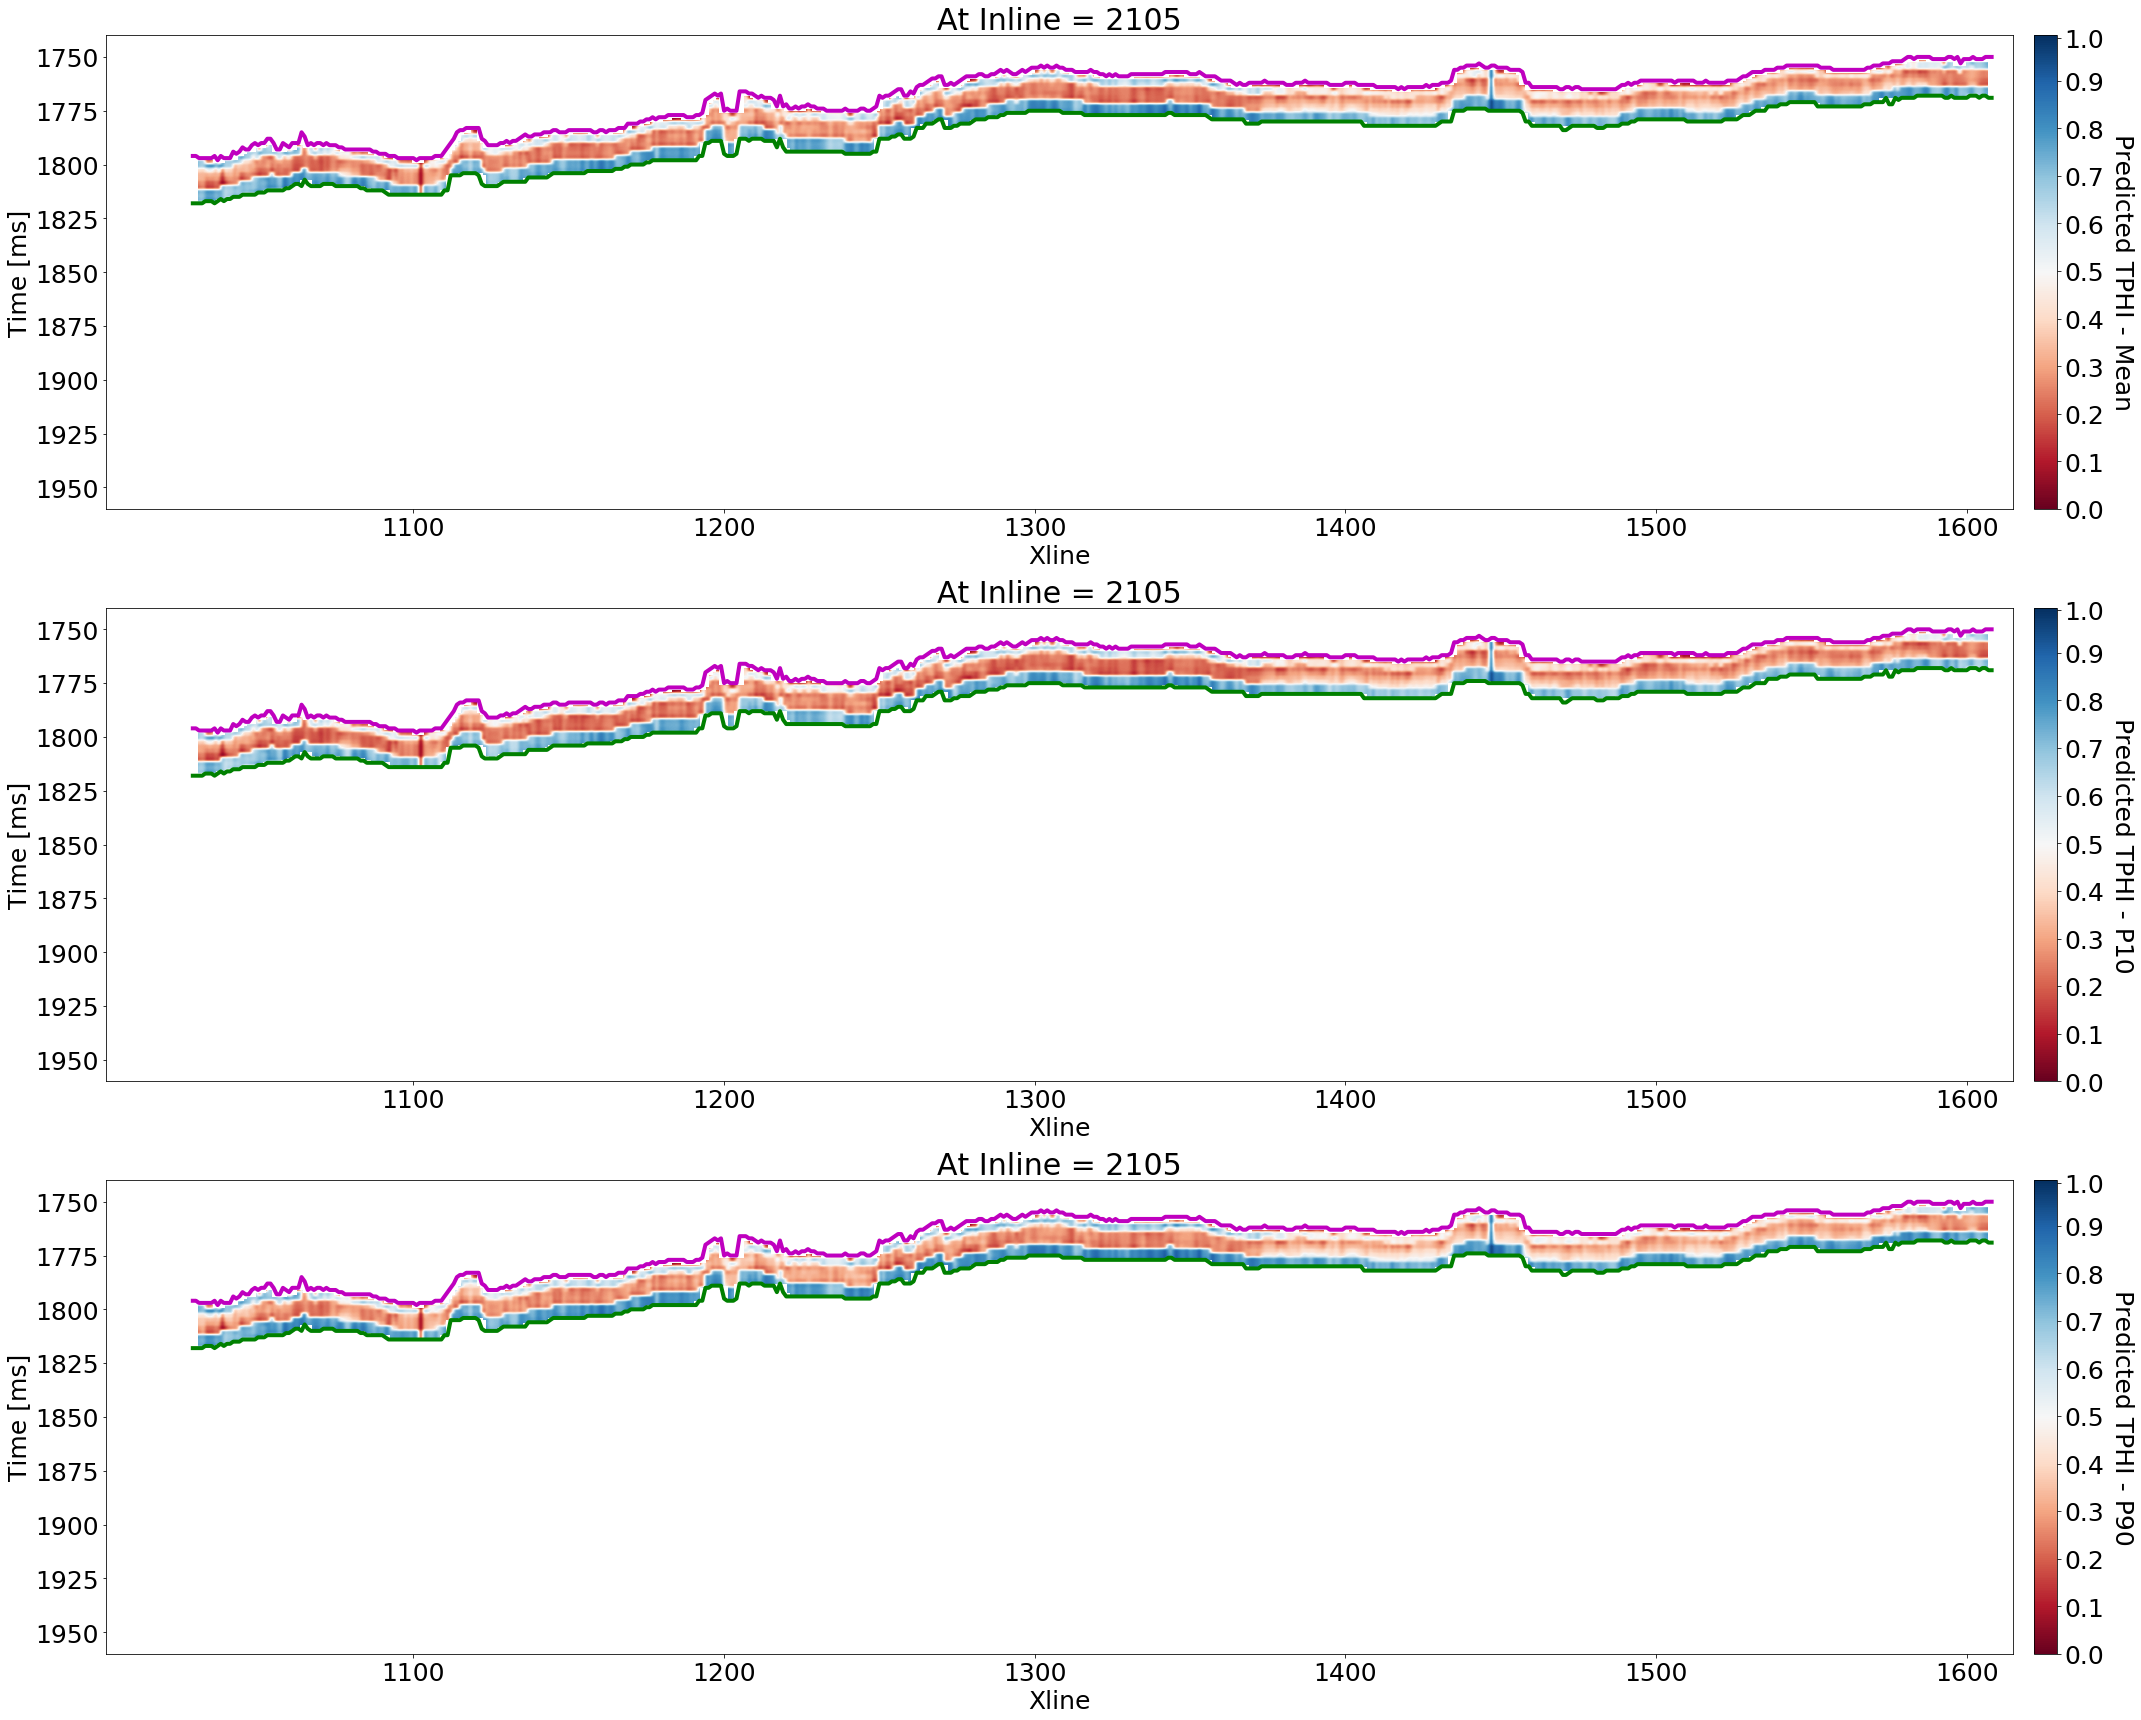

In [63]:
def seismic_inline_tphi_pred_results_all3(i, j, plot_bool):
    ###################################################################################################################
    df_horizons_updated_bnn = df_horizons_updated.iloc[:, [0, 1, 4, 5]]
    df_horizons_updated_bnn = df_horizons_updated_bnn.loc[df_horizons_updated_bnn['Inline'].values == i]
    np_bk_horizons_bnn = df_horizons_updated_bnn['Bakken_Horizon_Floor_Time_ms'].values
    np_tf_horizons_bnn = df_horizons_updated_bnn['ThreeFork_Horizon_Ceiling_Time_ms'].values
    map_horiz_bak_inline = seismic_data[:, inl_array.tolist().index(i), :]            
    np_bk_horizons_bnn_plt = np_bk_horizons_bnn[map_horiz_bak_inline[0] != 0]
    np_tf_horizons_bnn_plt = np_tf_horizons_bnn[map_horiz_bak_inline[0] != 0]
    xl_array_new = xl_array; xl_array_new = xl_array_new[map_horiz_bak_inline[0] != 0]
    z_new1 = np.array(np.arange(1740.0, 1960.0 + 1.0, 1.0), dtype=np.int64)
    ###################################################################################################################
    if plot_bool == True:
        ###################################################################################################################
        fig = plt.figure(figsize=(30, 24))
        xleft, xrite = xl_array.min(), xl_array.max()
        twt_min = z_new1.min(); twt_max = z_new1.max()
        ext = [xleft, xrite, twt_max, twt_min]
        ###################################################################################################################
        ax = fig.add_subplot(3, 1, 1)
        amp = ax.imshow(TPHI_PredAvgCorrVals[:, :, j], cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
        cbar.ax.set_ylabel('Predicted TPHI - Mean', rotation=270, labelpad=30, size=25)
        cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
        cbar.ax.tick_params(labelsize=25)
        ax.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=4)
        ax.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=4)
        plt.title('At Inline = %d' % i, size=30)
        plt.ylabel("Time [ms]", size=25)
        plt.xlabel("Xline", size=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        ###################################################################################################################
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=23)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=23)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
        ###################################################################################################################
        ax2 = fig.add_subplot(3, 1, 2); ax = ax2
        amp = ax.imshow(TPHI_PredP10CorrVals[:, :, j], cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
        cbar.ax.set_ylabel('Predicted TPHI - P10', rotation=270, labelpad=30, size=25)
        cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
        cbar.ax.tick_params(labelsize=25)
        ax.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=4)
        ax.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=4)
        plt.title('At Inline = %d' % i, size=30)
        plt.ylabel("Time [ms]", size=25)
        plt.xlabel("Xline", size=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        ###################################################################################################################
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=23)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=23)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
        ###################################################################################################################
        ax3 = fig.add_subplot(3, 1, 3); ax = ax3
        amp = ax.imshow(TPHI_PredP90CorrVals[:, :, j], cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
        cbar.ax.set_ylabel('Predicted TPHI - P90', rotation=270, labelpad=30, size=25)
        cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
        cbar.ax.tick_params(labelsize=25)
        ax.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=4)
        ax.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=4)
        plt.title('At Inline = %d' % i, size=30)
        plt.ylabel("Time [ms]", size=25)
        plt.xlabel("Xline", size=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        ###################################################################################################################
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=23)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=23)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
    
        plt.tight_layout()

def seismic_inline_tphi_pred_stat_results(pred_stat, i, j, plot_bool, cbar_label):
    ###################################################################################################################
    df_horizons_updated_bnn = df_horizons_updated.iloc[:, [0, 1, 4, 5]]
    df_horizons_updated_bnn = df_horizons_updated_bnn.loc[df_horizons_updated_bnn['Inline'].values == i]
    np_bk_horizons_bnn = df_horizons_updated_bnn['Bakken_Horizon_Floor_Time_ms'].values
    np_tf_horizons_bnn = df_horizons_updated_bnn['ThreeFork_Horizon_Ceiling_Time_ms'].values
    map_horiz_bak_inline = seismic_data[:, inl_array.tolist().index(i), :]            
    np_bk_horizons_bnn_plt = np_bk_horizons_bnn[map_horiz_bak_inline[0] != 0]
    np_tf_horizons_bnn_plt = np_tf_horizons_bnn[map_horiz_bak_inline[0] != 0]
    xl_array_new = xl_array; xl_array_new = xl_array_new[map_horiz_bak_inline[0] != 0]
    z_new1 = np.array(np.arange(1740.0, 1960.0 + 1.0, 1.0), dtype=np.int64)
    ###################################################################################################################
    np_BNN_TphiPredMeanFrame = TPHI_PredAvgCorrVals[:, :, j]
    # Standardized the data between -1.3875 and 1.3875
    scaler = preprocessing.MinMaxScaler(feature_range=(-1.3875, 1.3875))
    scaler.fit(np_BNN_TphiPredMeanFrame)
    np_BNN_TphiPredMeanFrame = scaler.transform(np_BNN_TphiPredMeanFrame)
    df_BNN_TphiPredMeanFrame = pd.DataFrame(np_BNN_TphiPredMeanFrame)
    np_BNN_TphiPredMeanFrame_norm = df_BNN_TphiPredMeanFrame.values
    ###################################################################################################################
    if plot_bool == True:        
        ###################################################################################################################
        fig = plt.figure(figsize=(24, 8))
        xleft, xrite = xl_array.min(), xl_array.max()
        twt_min = z_new1.min(); twt_max = z_new1.max()
        ext = [xleft, xrite, twt_max, twt_min]
        ###################################################################################################################
        ax = fig.add_subplot(1, 1, 1)
        amp = ax.imshow(pred_stat[:, :, j], cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
        cbar.ax.set_ylabel('Predicted TPHI - ' + str(cbar_label), rotation=270, labelpad=30, size=20)
        cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
        cbar.ax.tick_params(labelsize=20)
        ax.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=4)
        ax.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=4)
        plt.title('At Inline = %d' % i, size=25)
        plt.ylabel("Time [ms]", size=20)
        plt.xlabel("Xline", size=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ###################################################################################################################
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=20)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=3)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=3)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=3)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=3)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=20)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=3)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=3)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=3)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=3)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
    
        plt.tight_layout()
    return np_BNN_TphiPredMeanFrame_norm, z_new1

###################################################################################################################
jj = 0; k = start_i + jj
# np_BNN_TphiPredMeanFrame_norm, z_new1 = seismic_inline_tphi_pred_stat_results(TPHI_PredAvgCorrVals, k, jj, True, 'Mean')
# np_BNN_TphiPredMeanFrame_norm, z_new1 = seismic_inline_tphi_pred_stat_results(TPHI_PredP10CorrVals, k, jj, True, 'P10')
# np_BNN_TphiPredMeanFrame_norm, z_new1 = seismic_inline_tphi_pred_stat_results(TPHI_PredP90CorrVals, k, jj, True, 'P90')
seismic_inline_tphi_pred_results_all3(k, jj, True)
###################################################################################################################

#### TOC Prediction now from estimated total porosity

(221, 615)
(21,)
target_compress.shape (135915,)


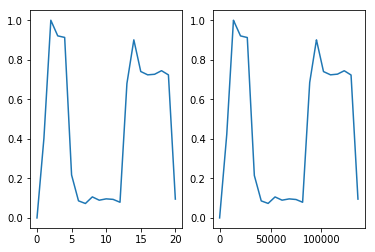

In [64]:
###################################################################################################################
np_BNN_TphiPredMeanFrame_norm, z_new1 = seismic_inline_tphi_pred_stat_results(TPHI_PredAvgCorrVals, k, jj, False, 'Mean')
# Standardized the data between -1.3875 and 1.3875 (done within function, where each seismic inline is min/max
# normalized separately instead of all together)
print(np_BNN_TphiPredMeanFrame_norm.shape)
np_seismic_lucy_toc = df_seismic_lucy_tphi_bnn['TOC_Norm'].values
y_target_norm0 = np_seismic_lucy_toc
print(np_seismic_lucy_toc.shape)
###################################################################################################################
np_plot_tphi_mean_test = np_BNN_TphiPredMeanFrame_norm.ravel()
###################################################################################################################
plt.subplot(1, 2, 1)
plt.plot(y_target_norm0)
###################################################################################################################
plt.subplot(1, 2, 2)
target_interp01 = interp.interp1d(np.arange(y_target_norm0.size), y_target_norm0)
target_compress01 = target_interp01(np.linspace(0, y_target_norm0.size - 1, np_plot_tphi_mean_test.size))
print('target_compress.shape', target_compress01.shape)
plt.plot(target_compress01)
###################################################################################################################

In [65]:
###################################################################################################################
timer05 = time.time()
start_i = start_ii  # 1001
end_i = end_ii      # 2277
diff_i = end_i - start_i
i = start_i
j = 0
###################################################################################################################
np_BNN_TphiPredMeanFrame_norm_dum, z_new1_dum = seismic_inline_tphi_pred_stat_results(TPHI_PredAvgCorrVals, start_i, j, False, 'Mean')
###################################################################################################################
fx_train_mean_list_array02 = np.zeros((z_new1_dum.size, 615, diff_i+1))
fx_train_p10_list_array02  = np.zeros((z_new1_dum.size, 615, diff_i+1))
fx_train_p90_list_array02  = np.zeros((z_new1_dum.size, 615, diff_i+1))
###################################################################################################################
np_pred_mean_new01 = np.zeros((z_new1_dum.size, 615, diff_i+1))
np_pred_p10_new01 = np.zeros((z_new1_dum.size, 615, diff_i+1))
np_pred_p90_new01 = np.zeros((z_new1_dum.size, 615, diff_i+1))
###################################################################################################################
with segyio.open(filename, iline=189, xline=193) as segyfile:
    ###############################################################################################################
    # Memory map file for faster reading (especially if file is big...)
    segyfile.mmap()
    ###############################################################################################################  
    while i <= end_i:
        ###################################################################################################################
        numSamples = 300
        burnin = 0.85 * numSamples
        np_BNN_TphiPredMeanFrame_norm, z_new1 = seismic_inline_tphi_pred_stat_results(TPHI_PredAvgCorrVals, i, j, False, 'Mean')
        ###############################################################################################################   
        def pad(A, length):
            arr = np.zeros(length)
            arr[:len(A)] = A
            return arr
        ###################################################################################################################
        fx_train_mean_list_array0 = np.zeros((z_new1.size, 615))
        fx_train_p10_list_array0  = np.zeros((z_new1.size, 615))
        fx_train_p90_list_array0  = np.zeros((z_new1.size, 615))
        ###################################################################################################################
        for column in range(0, 615):
            data_for_given_xline0 = np_BNN_TphiPredMeanFrame_norm[:, column]
            data_for_given_xline0 = data_for_given_xline0[~np.isnan(data_for_given_xline0)]
            if len(data_for_given_xline0) != 0:

                random.seed(time.time())
                tphi_pred_data = data_for_given_xline0
                target_interp0 = interp.interp1d(np.arange(y_target_norm.size), y_target_norm)
                target_compress0 = target_interp0(np.linspace(0, y_target_norm.size - 1, tphi_pred_data.size))
                np_pred_data_with_toc = np.vstack([tphi_pred_data, target_compress0]).transpose()

                mcmc = MCMC(use_langevin_gradients, l_prob, learn_rate, numSamples, np_pred_data_with_toc, np_pred_data_with_toc, topology)
                pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio, hidden_update, hidden_update_acc, r2value_train, r2value_test, var_exp_train, var_exp_test, MAPE_train, MAPE_test = mcmc.sampler(w_limit, tau_limit, path_db, plot=False, rdn_hid_update=False)

                fx_mu_train = fx_train[int(burnin):, ].mean(axis=0)
                fx_p10_train = np.percentile(fx_train[int(burnin):, ], 10, axis=0)
                fx_p90_train = np.percentile(fx_train[int(burnin):, ], 90, axis=0)

                fx_train_mean_list_array0 = np.insert(fx_train_mean_list_array0, column, pad(fx_mu_train, z_new1.size), axis=1)
                fx_train_p10_list_array0  = np.insert(fx_train_p10_list_array0, column, pad(fx_p10_train, z_new1.size), axis=1)
                fx_train_p90_list_array0  = np.insert(fx_train_p90_list_array0, column, pad(fx_p90_train, z_new1.size), axis=1)             
        ###################################################################################################################
        fx_train_mean_list_array01 = np.delete(fx_train_mean_list_array0, np.s_[615:], axis=1)
        fx_train_p10_list_array01  = np.delete(fx_train_p10_list_array0, np.s_[615:], axis=1)
        fx_train_p90_list_array01  = np.delete(fx_train_p90_list_array0, np.s_[615:], axis=1)
        fx_train_mean_list_array02[:, :, j] = fx_train_mean_list_array01
        fx_train_p10_list_array02[:, :, j]  = fx_train_p10_list_array01
        fx_train_p90_list_array02[:, :, j]  = fx_train_p90_list_array01
        ###################################################################################################################
        for column in range(0, 615):
            for index in range(0, z_new1.size):
                if fx_train_mean_list_array02[index, column, j] == int(0):
                    fx_train_mean_list_array02[index, column, j] = np.nan
                if fx_train_p10_list_array02[index, column, j] == int(0):
                    fx_train_p10_list_array02[index, column, j] = np.nan
                if fx_train_p90_list_array02[index, column, j] == int(0):
                    fx_train_p90_list_array02[index, column, j] = np.nan
        ###################################################################################################################
        np_pred_mean_dummy0 = fx_train_mean_list_array02
        np_pred_p10_dummy0 = fx_train_p10_list_array02
        np_pred_p90_dummy0 = fx_train_p90_list_array02
        ###################################################################################################################
        col = 0
        np_BNN_TphiPredMeanFrame_norm_loop = np_BNN_TphiPredMeanFrame_norm
        while col < 615:
            idx = 0
            while idx < z_new1.size:
                np_BNN_TphiPredMeanFrame_norm_dummy = np_BNN_TphiPredMeanFrame_norm_loop[idx, col]
                null_check0 = np_BNN_TphiPredMeanFrame_norm_dummy[np.isnan(np_BNN_TphiPredMeanFrame_norm_dummy)]
                if len(null_check0) == 0:
                    pred_orig_idx = idx + 1
                    for idx in range(pred_orig_idx, z_new1.size):
                        np_pred_mean_new01[idx, col, j] = np_pred_mean_dummy0[idx - pred_orig_idx, col, j]
                        np_pred_p10_new01[idx, col, j] = np_pred_p10_dummy0[idx - pred_orig_idx, col, j]
                        np_pred_p90_new01[idx, col, j] = np_pred_p90_dummy0[idx - pred_orig_idx, col, j]
                else:
                    np_pred_mean_new01[idx, col, j] = np.nan
                    np_pred_p10_new01[idx, col, j] = np.nan
                    np_pred_p90_new01[idx, col, j] = np.nan
                idx += 1
            col += 1
        ###################################################################################################################
        pred_mean_corrected_vals0 = np_pred_mean_new01
        pred_p10_corrected_vals0 = np_pred_p10_new01
        pred_p90_corrected_vals0 = np_pred_p90_new01
        ###################################################################################################################
        # print(str(start_i + j) + ' inline with pred_mean_corrected_vals0 shape of ' + str(pred_mean_corrected_vals0.shape))
        i += 1; j += 1
        ###################################################################################################################
###################################################################################################################
timer06 = time.time()
timetotal_min0000 = (timer06 - timer05) / 60
print(str(round(timetotal_min0000, 5)) + '  minutes to evaluate')
print(str(round(timetotal_min0000/60, 5)) + '  hours to evaluate full 3D volume')
# 000.000  minutes to evaluate for 785,354 iterations with 100 sub iterations for each of the 785,354 iterations
###################################################################################################################
TOC_PredAvgCorrVals = pred_mean_corrected_vals0
TOC_PredP10CorrVals = pred_p10_corrected_vals0
TOC_PredP90CorrVals = pred_p90_corrected_vals0
df_PredAvgCorrVals0 = pd.DataFrame(TOC_PredAvgCorrVals.ravel())
df_PredP10CorrVals0 = pd.DataFrame(TOC_PredP10CorrVals.ravel())
df_PredP90CorrVals0 = pd.DataFrame(TOC_PredP90CorrVals.ravel())
###################################################################################################################
with pd.ExcelWriter("Predicted_3D_TOC_Results.xlsx") as writer:
    df_PredAvgCorrVals0.to_excel(writer, sheet_name='Pred_Avg')
    df_PredP10CorrVals0.to_excel(writer, sheet_name='Pred_P10')
    df_PredP90CorrVals0.to_excel(writer, sheet_name='Pred_P90')
print("Successfully Written to Excel File")
###################################################################################################################

59.16582  minutes to evaluate
0.9861  hours to evaluate full 3D volume
Successfully Written to Excel File


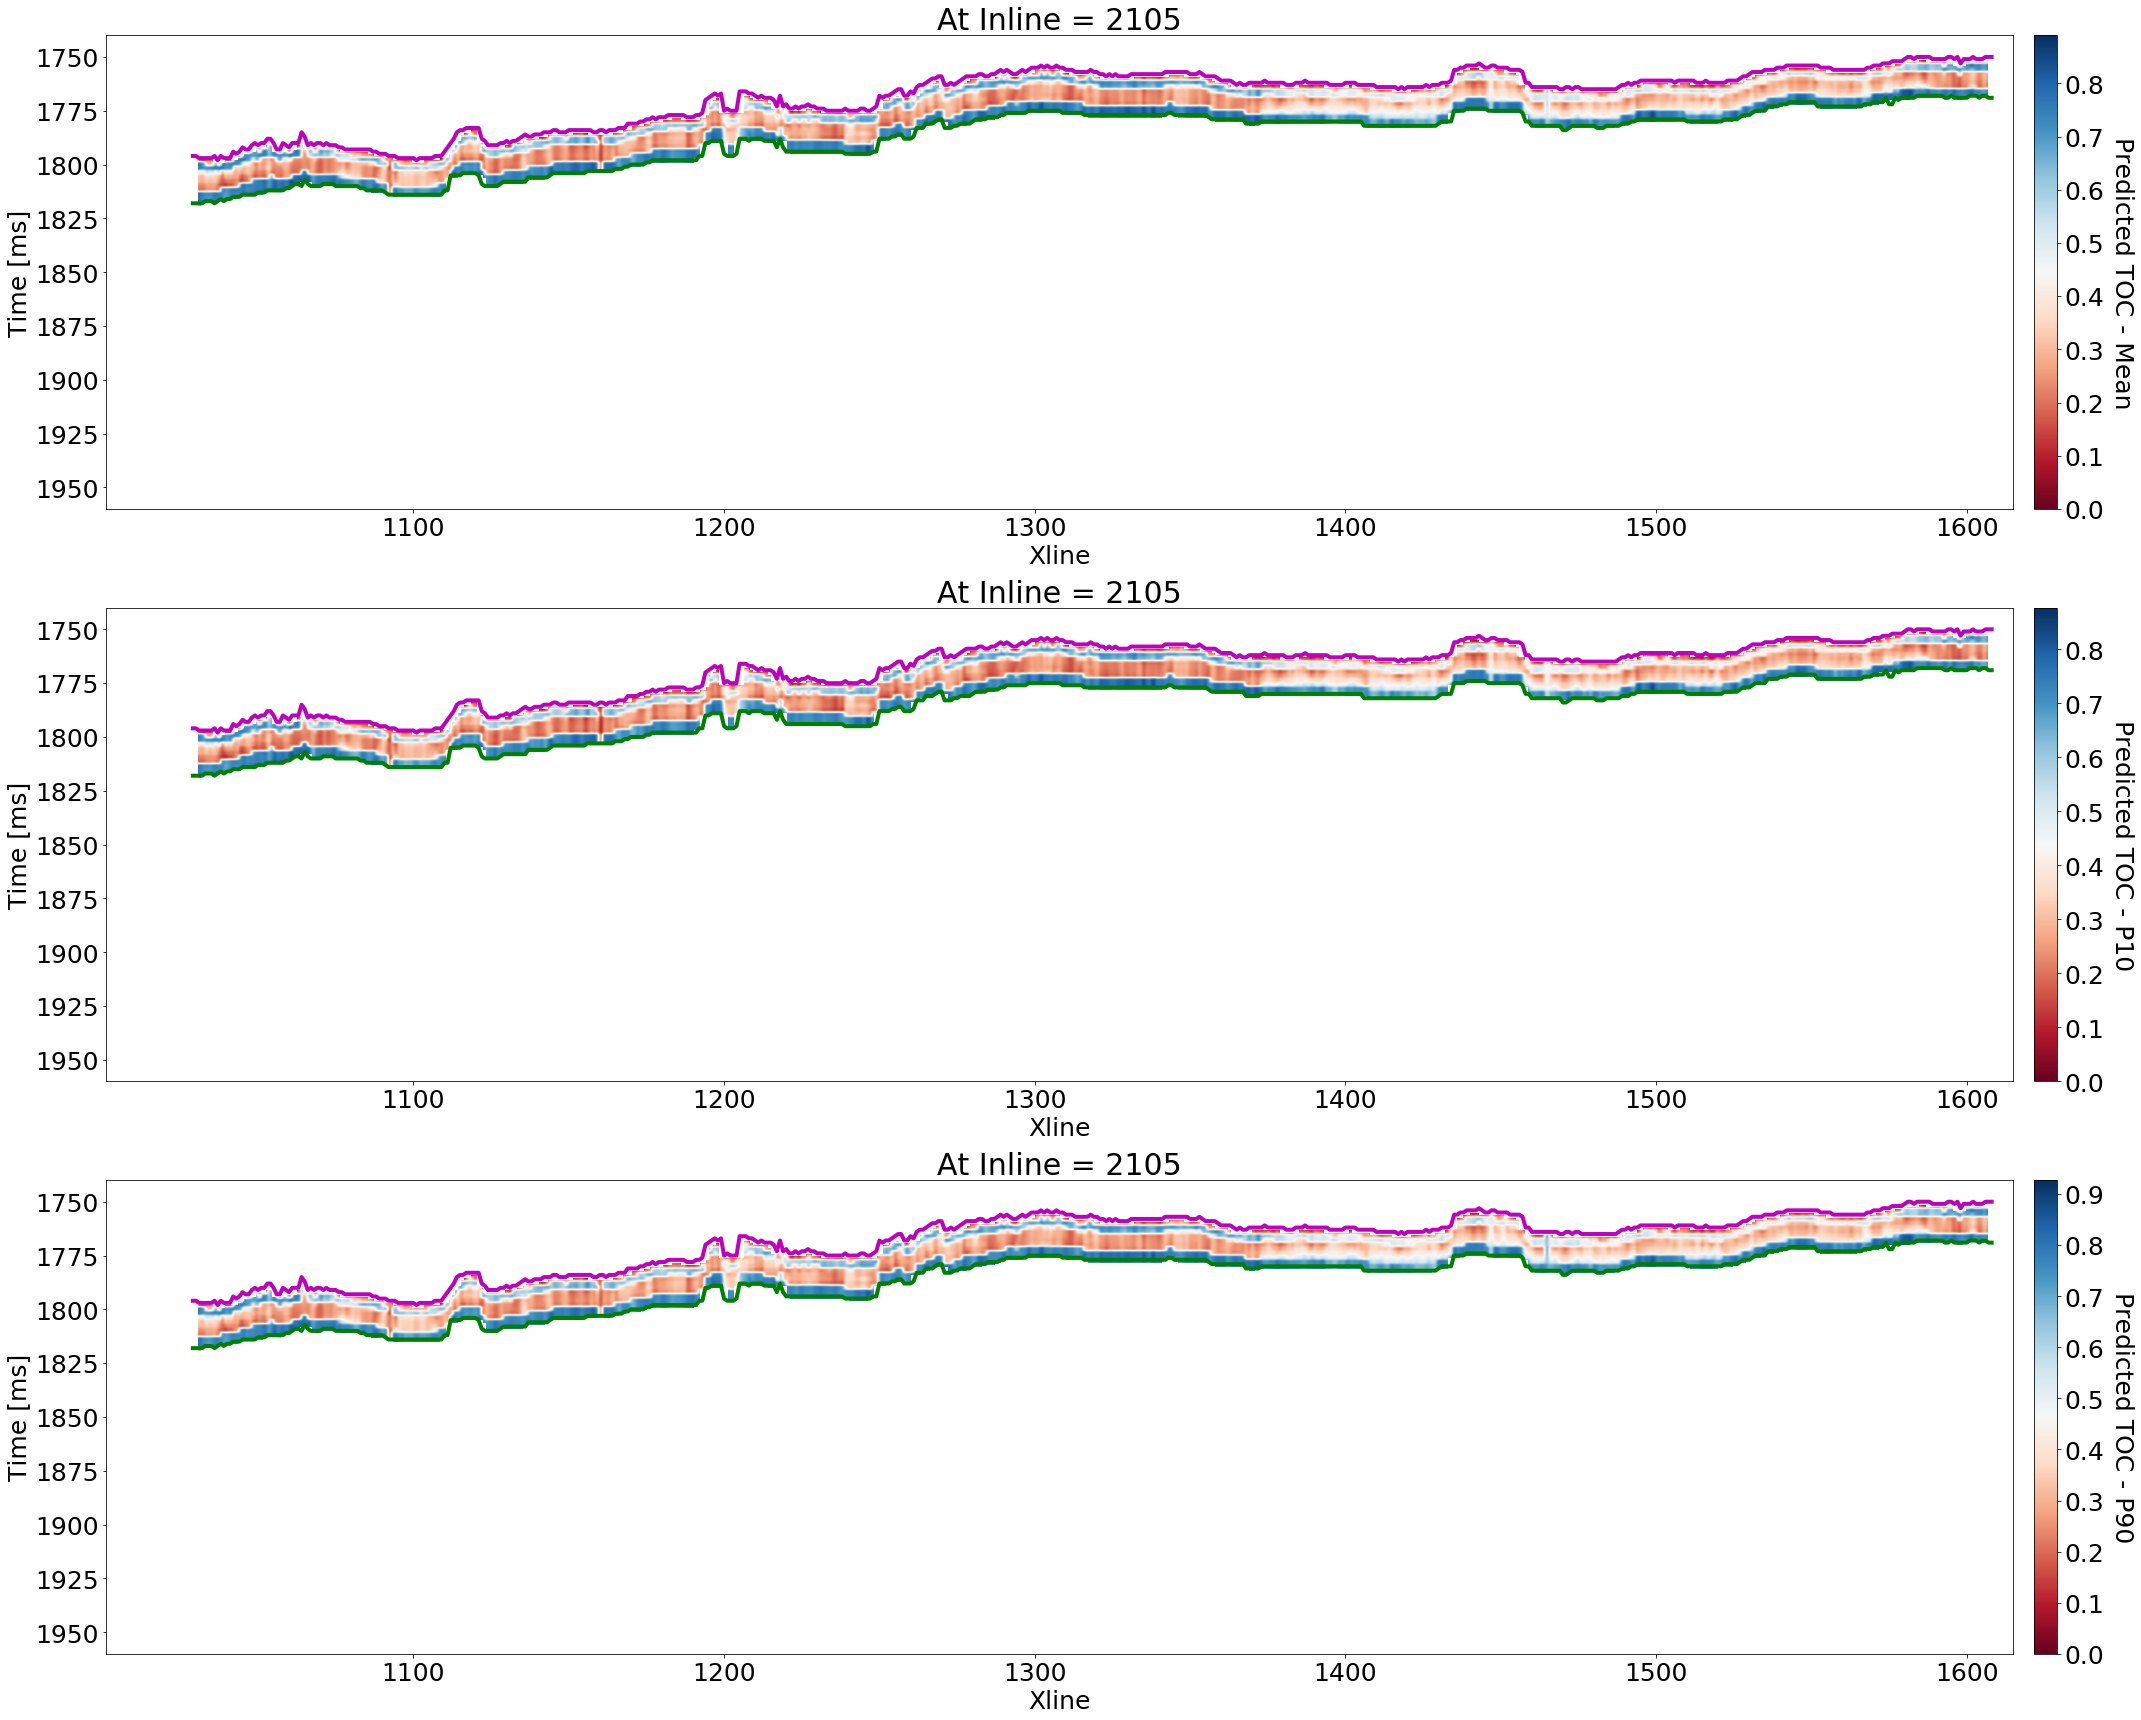

In [66]:
def seismic_inline_toc_pred_results_all3(i, j, plot_bool):
    ###################################################################################################################
    df_horizons_updated_bnn = df_horizons_updated.iloc[:, [0, 1, 4, 5]]
    df_horizons_updated_bnn = df_horizons_updated_bnn.loc[df_horizons_updated_bnn['Inline'].values == i]
    np_bk_horizons_bnn = df_horizons_updated_bnn['Bakken_Horizon_Floor_Time_ms'].values
    np_tf_horizons_bnn = df_horizons_updated_bnn['ThreeFork_Horizon_Ceiling_Time_ms'].values
    map_horiz_bak_inline = seismic_data[:, inl_array.tolist().index(i), :]            
    np_bk_horizons_bnn_plt = np_bk_horizons_bnn[map_horiz_bak_inline[0] != 0]
    np_tf_horizons_bnn_plt = np_tf_horizons_bnn[map_horiz_bak_inline[0] != 0]
    xl_array_new = xl_array; xl_array_new = xl_array_new[map_horiz_bak_inline[0] != 0]
    z_new1 = np.array(np.arange(1740.0, 1960.0 + 1.0, 1.0), dtype=np.int64)
    ###################################################################################################################
    if plot_bool == True:        
        ###################################################################################################################
        fig = plt.figure(figsize=(30, 24))
        xleft, xrite = xl_array.min(), xl_array.max()
        twt_min = z_new1.min(); twt_max = z_new1.max()
        ext = [xleft, xrite, twt_max, twt_min]
        ###################################################################################################################
        ax = fig.add_subplot(3, 1, 1)
        amp = ax.imshow(TOC_PredAvgCorrVals[:, :, j], cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
        cbar.ax.set_ylabel('Predicted TOC - Mean', rotation=270, labelpad=30, size=25)
        cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
        cbar.ax.tick_params(labelsize=25)
        ax.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=4)
        ax.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=4)
        plt.title('At Inline = %d' % i, size=30)
        plt.ylabel("Time [ms]", size=25)
        plt.xlabel("Xline", size=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        ###################################################################################################################
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=23)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=23)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
        ###################################################################################################################
        ax2 = fig.add_subplot(3, 1, 2); ax = ax2
        amp = ax.imshow(TOC_PredP10CorrVals[:, :, j], cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
        cbar.ax.set_ylabel('Predicted TOC - P10', rotation=270, labelpad=30, size=25)
        cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
        cbar.ax.tick_params(labelsize=25)
        ax.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=4)
        ax.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=4)
        plt.title('At Inline = %d' % i, size=30)
        plt.ylabel("Time [ms]", size=25)
        plt.xlabel("Xline", size=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        ###################################################################################################################
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=23)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=23)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
        ###################################################################################################################
        ax3 = fig.add_subplot(3, 1, 3); ax = ax3
        amp = ax.imshow(TOC_PredP90CorrVals[:, :, j], cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
        cbar.ax.set_ylabel('Predicted TOC - P90', rotation=270, labelpad=30, size=25)
        cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
        cbar.ax.tick_params(labelsize=25)
        ax.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=4)
        ax.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=4)
        plt.title('At Inline = %d' % i, size=30)
        plt.ylabel("Time [ms]", size=25)
        plt.xlabel("Xline", size=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        ###################################################################################################################
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=23)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=4)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=23)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=4)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
    
        plt.tight_layout()

def seismic_inline_toc_pred_stat_results(pred_stat, i, j, plot_bool, cbar_label):
    ###################################################################################################################
    df_horizons_updated_bnn = df_horizons_updated.iloc[:, [0, 1, 4, 5]]
    df_horizons_updated_bnn = df_horizons_updated_bnn.loc[df_horizons_updated_bnn['Inline'].values == i]
    np_bk_horizons_bnn = df_horizons_updated_bnn['Bakken_Horizon_Floor_Time_ms'].values
    np_tf_horizons_bnn = df_horizons_updated_bnn['ThreeFork_Horizon_Ceiling_Time_ms'].values
    map_horiz_bak_inline = seismic_data[:, inl_array.tolist().index(i), :]            
    np_bk_horizons_bnn_plt = np_bk_horizons_bnn[map_horiz_bak_inline[0] != 0]
    np_tf_horizons_bnn_plt = np_tf_horizons_bnn[map_horiz_bak_inline[0] != 0]
    xl_array_new = xl_array; xl_array_new = xl_array_new[map_horiz_bak_inline[0] != 0]
    z_new1 = np.array(np.arange(1740.0, 1960.0 + 1.0, 1.0), dtype=np.int64)
    ###################################################################################################################
    if plot_bool == True:        
        ###################################################################################################################
        fig = plt.figure(figsize=(24, 8))
        xleft, xrite = xl_array.min(), xl_array.max()
        twt_min = z_new1.min(); twt_max = z_new1.max()
        ext = [xleft, xrite, twt_max, twt_min]
        ###################################################################################################################
        ax = fig.add_subplot(1, 1, 1)
        amp = ax.imshow(pred_stat[:, :, j], cmap='RdBu', aspect='auto', extent=ext, interpolation='bicubic')
        cbar = fig.colorbar(amp, ax=ax, fraction=0.046, pad=0.01, shrink=1.0, ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
        cbar.ax.set_ylabel('Predicted TOC - ' + str(cbar_label), rotation=270, labelpad=30, size=20)
        cbar.ax.set_yticklabels(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
        cbar.ax.tick_params(labelsize=20)
        ax.plot(xl_array_new, np_bk_horizons_bnn_plt, color='m', linewidth=4)
        ax.plot(xl_array_new, np_tf_horizons_bnn_plt, color='g', linewidth=4)
        plt.title('At Inline = %d' % i, size=25)
        plt.ylabel("Time [ms]", size=20)
        plt.xlabel("Xline", size=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ###################################################################################################################
        if i == 2108:
            ###################################################################################################################
            well_name_loc = 1732
            apx_max_well_twt_lucy = 1828
            well_xl_lucy = 1165
            TWT_ms_min_lucy = df_well_lucy['TWT_ms'].min()
            TWT_ms_max_lucy = df_well_lucy['TWT_ms'].max()
            ax.arrow(well_xl_lucy, 0, 0, apx_max_well_twt_lucy, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_lucy, well_name_loc, 'LUCY 11-23H Well', ha='center', va='center', rotation='horizontal', size=20)
            ###################################################################################################################
            # Plot well log tops --> note: -18ft to get get surface elv
            BKKNU_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8718.0]       # TWT_ms = 1781.51 (Really = 8718.00 MD_ft_KB)
            BKKNU_lucy = BKKNU_lucy['TWT_ms'].values
            BKKNM_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8733.0]       # TWT_ms = 1785.45 (Really = 8733.31 MD_ft_KB)
            BKKNM_lucy = BKKNM_lucy['TWT_ms'].values
            BKKNL_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8775.5]       # TWT_ms = 1793.04 (Really = 8775.40 MD_ft_KB)
            BKKNL_lucy = BKKNL_lucy['TWT_ms'].values
            TRFK_lucy = df_well_lucy.loc[df_well_lucy['MD_KB_ft'] == 8808.5]        # TWT_ms = 1800.38 (Really = 8808.38 MD_ft_KB)
            TRFK_lucy = TRFK_lucy['TWT_ms'].values
            ###################################################################################################################
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=3)
            ax.text(well_xl_lucy+15, BKKNU_lucy-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=3)
            ax.text(well_xl_lucy+15, BKKNM_lucy, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=3)
            ax.text(well_xl_lucy+15, BKKNL_lucy, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_lucy, xmin=well_xl_lucy-6, xmax=well_xl_lucy+6, color='black', linewidth=3)
            ax.text(well_xl_lucy+15, TRFK_lucy, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ###################################################################################################################
        if i == 1824:
            well_name_loc = 1732
            apx_max_well_twt_edwards = 1872
            well_xl_edwards = 1073
            TWT_ms_min_edwards = df_well_edwards['TWT_ms'].min()
            TWT_ms_max_edwards = df_well_edwards['TWT_ms'].max()
            ax.arrow(well_xl_edwards, 0, 0, apx_max_well_twt_edwards, width=0.5, color='k', length_includes_head=True, head_width=0)
            ax.text(well_xl_edwards, well_name_loc, 'Edwards_44_9H Well', ha='center', va='center', rotation='horizontal', size=20)
            # Plot well log tops --> note:-21ft to get get surface elv
            BKKNU_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9040.0] # TWT_ms = 1821.69 (Really = 9040.14 MD_ft_KB)
            BKKNU_edwards = BKKNU_edwards['TWT_ms'].values
            BKKNM_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9057.5] # TWT_ms = 1826.29 (Really = 9057.53 MD_ft_KB)
            BKKNM_edwards = BKKNM_edwards['TWT_ms'].values
            BKKNL_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9104.0] # TWT_ms = 1834.58 (Really = 9104.27 MD_ft_KB)
            BKKNL_edwards = BKKNL_edwards['TWT_ms'].values
            TRFK_edwards = df_well_edwards.loc[df_well_edwards['MD_KB_ft'] == 9136.0]  # TWT_ms = 1838.41 (Really = 9135.88 MD_ft_KB)
            TRFK_edwards = TRFK_edwards['TWT_ms'].values
            # Plot where the major well log tops are on the well
            ax.hlines(y=BKKNU_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=3)
            ax.text(well_xl_edwards+15, BKKNU_edwards-2, 'BKKU', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNM_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=3)
            ax.text(well_xl_edwards+15, BKKNM_edwards+2, 'BKKM', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=BKKNL_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=3)
            ax.text(well_xl_edwards+15, BKKNL_edwards, 'BKKL', ha='center', va='center', rotation='horizontal', color='black', size=14)
            ax.hlines(y=TRFK_edwards, xmin=well_xl_edwards-6, xmax=well_xl_edwards+6, color='black', linewidth=3)
            ax.text(well_xl_edwards+15, TRFK_edwards, 'TRFK', ha='center', va='center', rotation='horizontal', color='black', size=14)
    
        plt.tight_layout()

###################################################################################################################
jj = 0; k = start_i + jj
# seismic_inline_toc_pred_stat_results(TOC_PredAvgCorrVals, k, jj, True, 'Mean')
# seismic_inline_toc_pred_stat_results(TOC_PredP10CorrVals, k, jj, True, 'P10')
# seismic_inline_toc_pred_stat_results(TOC_PredP90CorrVals, k, jj, True, 'P90')
seismic_inline_toc_pred_results_all3(k, jj, True)
###################################################################################################################

#### Make an iterative plot video of the predicted TPHI and TOC results across each seismic inline, and plot seismic horizon slices of the respective predicted petrophysical properties in order to finalize this unconventional reservoir characterization workflow of the Bakken

In [72]:
###################################################################################################################
# os.chdir("/home/u1/jrt3658/Thesis_BNN_Bakken_Code/Thesis_Bakken_BNN_Code_Results/")
os.chdir("/Users/jacksontomski/Desktop/Desktop_Folders/xx_Thesis_New/")
name_new_inl = 'BNN_Code_Results/Estimated_TPHI_Inline'
problemfolder_db_new = 'Thesis_Bakken'
path_db_new_tphi_inl = (problemfolder_db_new + '_' + name_new_inl)
print(path_db_new_tphi_inl)
# If the directory does not exist
if not (os.path.exists(path_db_new_tphi_inl)):
    os.makedirs(path_db_new_tphi_inl)                            # Make the directory
else:                                                       # Else, the directory exists
    shutil.rmtree(path_db_new_tphi_inl)
    os.makedirs(path_db_new_tphi_inl)
###################################################################################################################

Thesis_Bakken_BNN_Code_Results/Estimated_TPHI_Inline


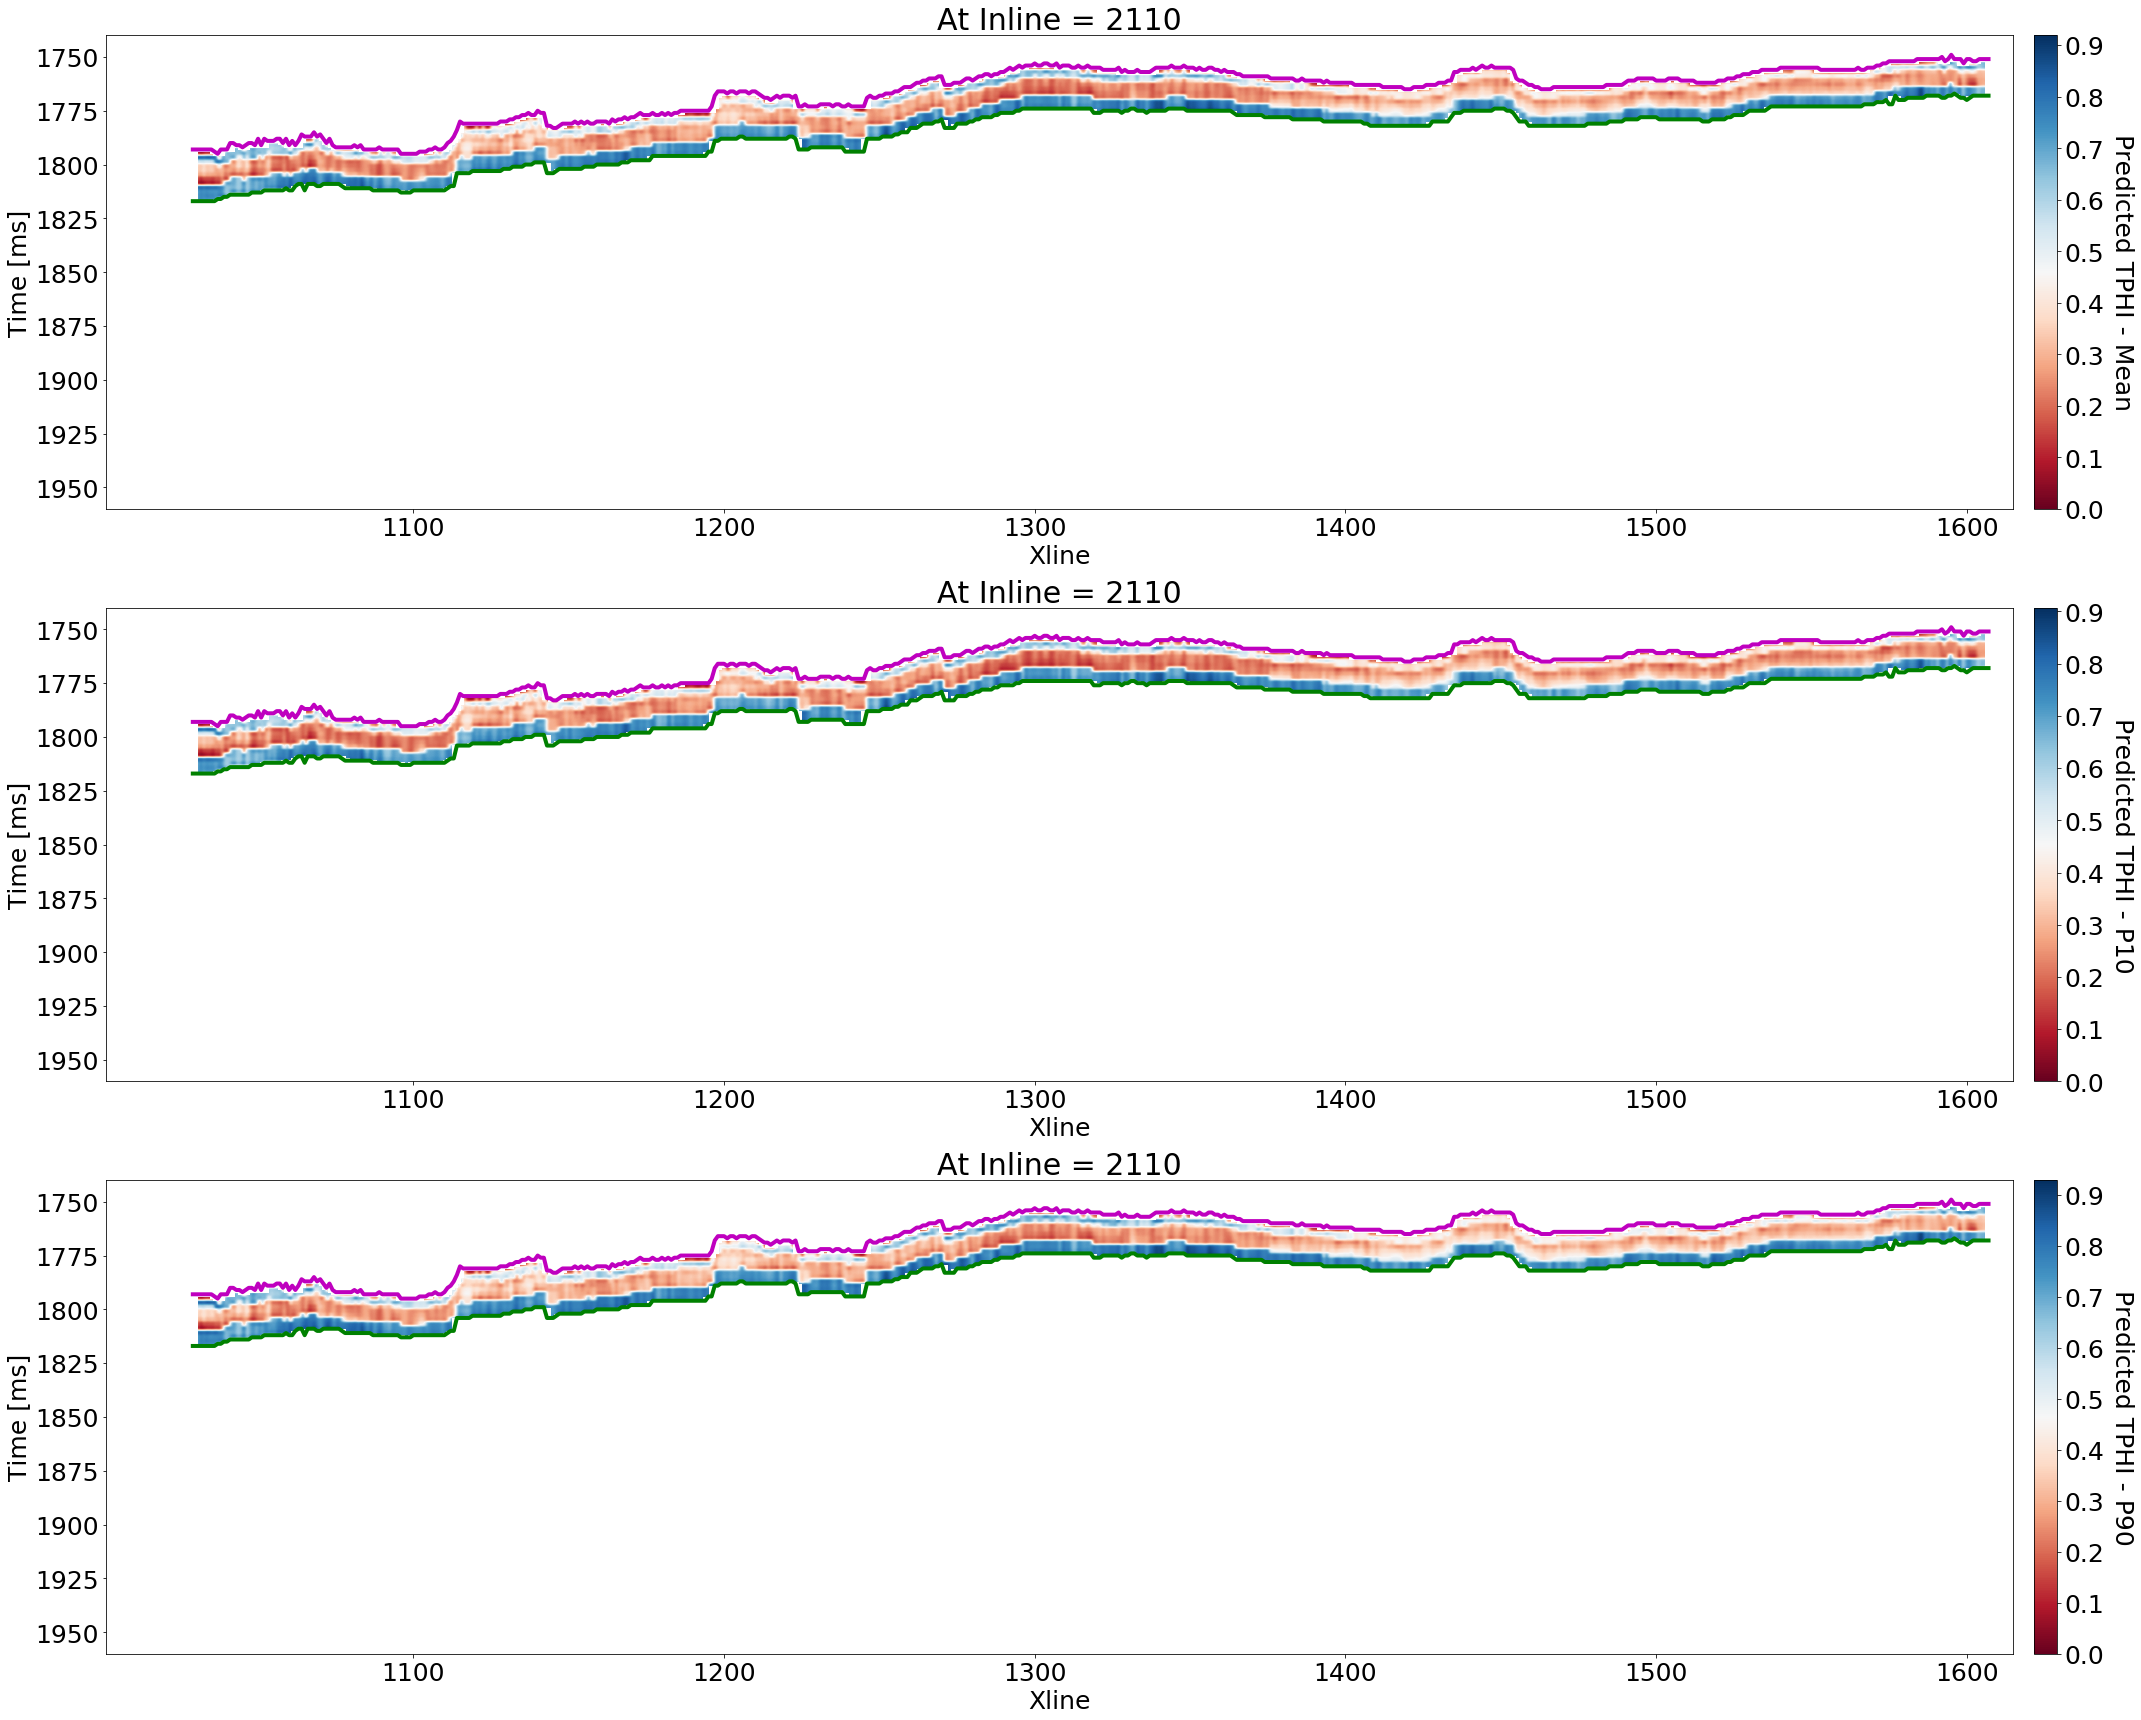

In [73]:
###################################################################################################################
def plot_inline_iteratively_tphi(start_ii, end_ii, path_db):
    i = start_ii
    j = 0
    while i <= end_ii:
        seismic_inline_tphi_pred_results_all3(i, j, True)
        plt.savefig(path_db + '/plot_iteratively_tphi_at_inline_' + str(i) + '.png')
        plt.pause(0.00000000000001)
        clear_output(wait=True)
        i += 1
        j += 1
    plt.show()
###################################################################################################################
plot_inline_iteratively_tphi(start_ii=start_ii, end_ii=end_ii, path_db=path_db_new_tphi_inl)
###################################################################################################################

In [74]:
###################################################################################################################
# os.chdir("/home/u1/jrt3658/Thesis_BNN_Bakken_Code/Thesis_Bakken_BNN_Code_Results/")
os.chdir("/Users/jacksontomski/Desktop/Desktop_Folders/xx_Thesis_New/")
name_new_inl = 'BNN_Code_Results/Estimated_TOC_Inline'
problemfolder_db_new = 'Thesis_Bakken'
path_db_new_toc_inl = (problemfolder_db_new + '_' + name_new_inl)
print(path_db_new_toc_inl)
# If the directory does not exist
if not (os.path.exists(path_db_new_toc_inl)):
    os.makedirs(path_db_new_toc_inl)                            # Make the directory
else:                                                       # Else, the directory exists
    shutil.rmtree(path_db_new_toc_inl)
    os.makedirs(path_db_new_toc_inl)
###################################################################################################################

Thesis_Bakken_BNN_Code_Results/Estimated_TOC_Inline


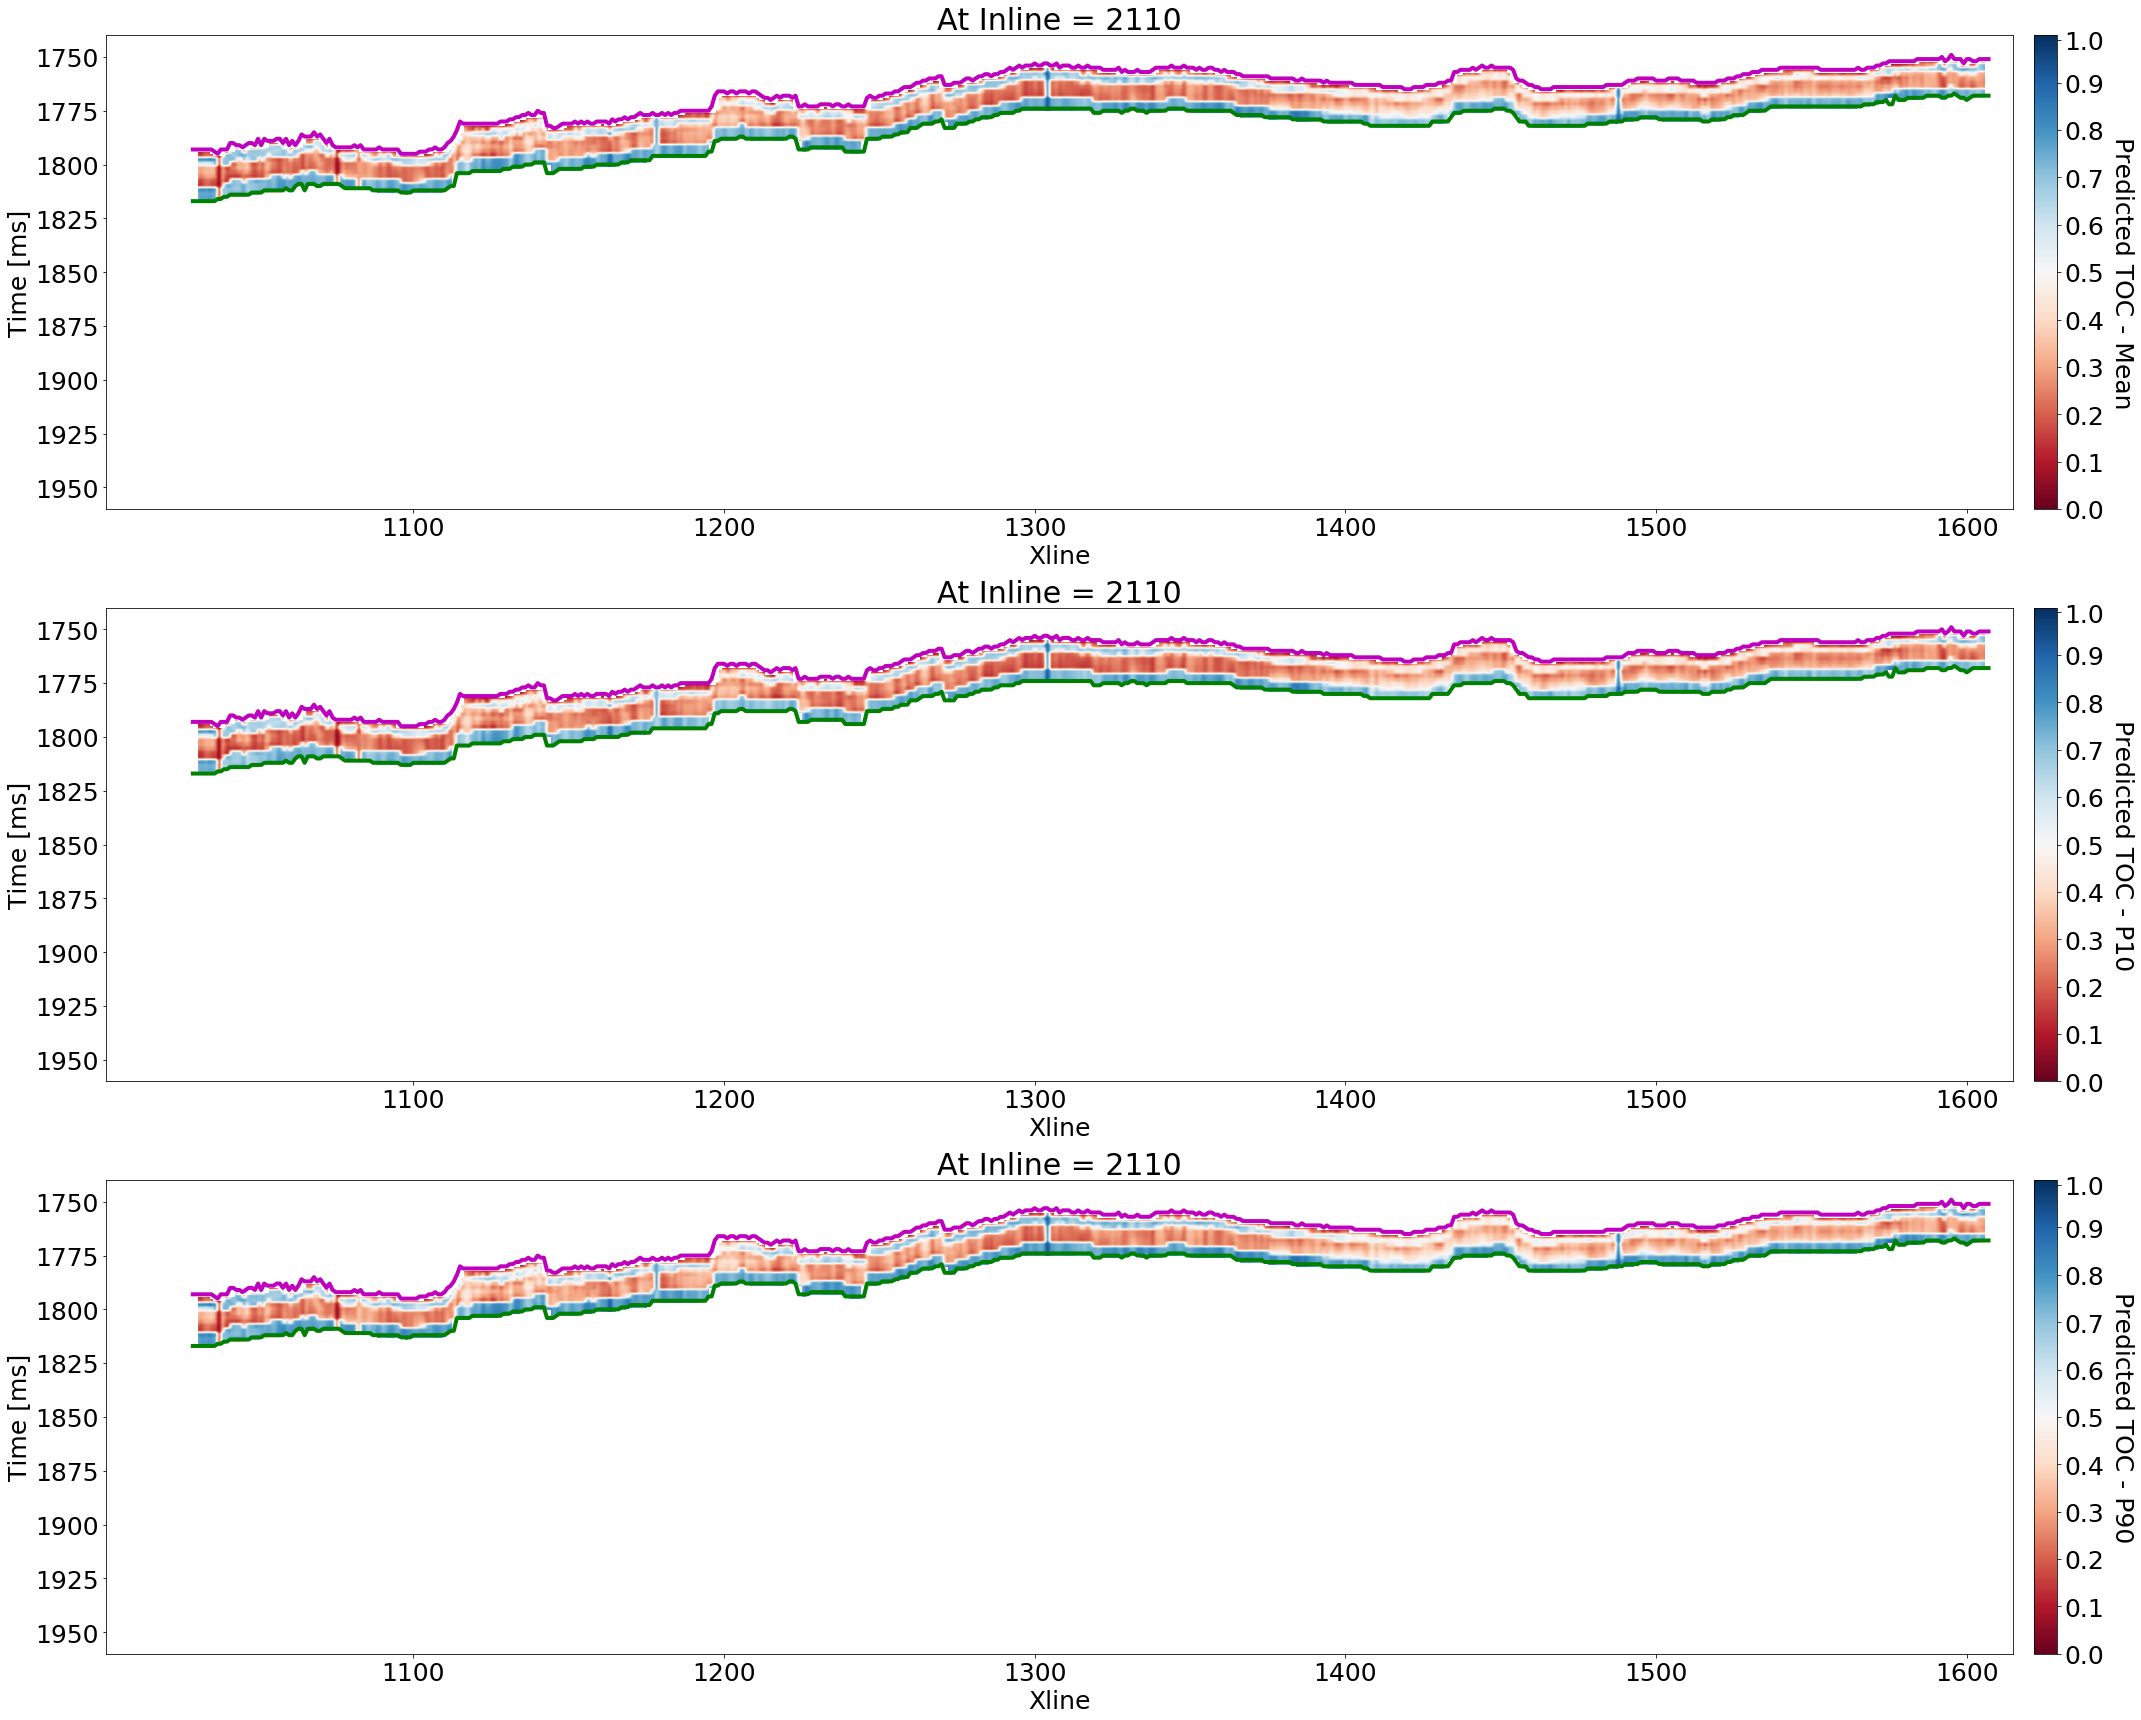

In [75]:
###################################################################################################################
def plot_inline_iteratively_toc(start_ii, end_ii, path_db):
    i = start_ii
    j = 0
    while i <= end_ii:
        seismic_inline_toc_pred_results_all3(i, j, True)
        plt.savefig(path_db + '/plot_iteratively_tphi_at_inline_' + str(i) + '.png')
        plt.pause(0.00000000000001)
        clear_output(wait=True)
        i += 1
        j += 1
    plt.show()
###################################################################################################################
plot_inline_iteratively_toc(start_ii=start_ii, end_ii=end_ii, path_db=path_db_new_toc_inl)
###################################################################################################################

#### Now make respective predicted petrophysical properies across upper and lower Bakken horizon slices